<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Netherlands/Unilever/Unilever_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "UNANLEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-09-03 01:51:39,464 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-09-03 01:51:39,466 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for UNANLEUR
2019-09-03 01:51:41,451 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.
2019-09-03 01:52:24,271 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-09-03 01:54:30,488 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-09-03 01:55:41,743 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-09-03 01:56:50,956 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-09-03 01:58:01,102 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-09-03 01:59:02,244 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-09-03 02:00:02,542 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-09-03 02:04:37,694 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_UNANLEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-UNANLEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-UNANLEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.46972  0.47007  0.46432  0.46537  8.461237
2018-01-02 09:00:00  0.46543  0.46707  0.46472  0.46538  8.926034
2018-01-02 10:00:00  0.46538  0.46703  0.46522  0.46588  5.078299
2018-01-02 11:00:00  0.46587  0.46843  0.46587  0.46768  3.783289
2018-01-02 12:00:00  0.46767  0.46813  0.46642  0.46683  3.621654
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.46738  0.46933  0.46642  0.46882  5.645418
2018-12-31 09:00:00  0.46883  0.47022  0.46857  0.47018  3.749582
2018-12-31 10:00:00  0.47023  0.47238  0.47023  0.47198  3.953187
2018-12-31 11:00:00  0.47197  0.47253  0.47117  0.47233  3.578822
2018-12-31 12:00:00  0.47233  0.47418  0.47157  0.47398  3.073008

[2278 rows x 5 columns]

Open         High          Low        Close       Volume
count  2278.000000  2278.000000  2278.000000  2278.000000  2278.000000
mean      0.471129     0.472270     0.470103     0.471219     5.611320
std       0.018761     0.018682     0.018766     0.018727     2.427142
min       0.421830     0.423530     0.421030     0.422480     0.128877
25%       0.461372     0.462323     0.460340     0.461470     3.888166
50%       0.474845     0.475855     0.473925     0.474930     5.119281
75%       0.483908     0.484830     0.482770     0.483957     6.833594
max       0.500770     0.501380     0.500370     0.500680    23.282787

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.46938  0.46998  0.46882  0.46993  4.063199    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.470142  0.467005 -0.472966  0.470136  0.470273  0.470146    0.470680    0.471050  0.472389  0.470445  0.469727  0.470417  0.470217  0.470445  0.470013  0.470140                0.472035                 0.470445                0.468855                0.472830                 0.470445                0.468060                0.473625                 0.470445                0.467265                0.474420                 0.470445                0.466470  0.470273  0.469975  0.470318                0.471863                 0.470273                0.468684                0.472658                 0.470273                0.467889                0.473453                 0.470273                0.467094                0.474248                 0.470273   
2018-01-09 14:00:00  0.46993  0.47143  0.46942  0.46972  9.341429    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.470121  0.467082 -0.472717  0.469948  0.470150  0.470132    0.470680    0.471050  0.472104  0.470287  0.469579  0.470272  0.470056  0.470287  0.469825  0.470187                0.471884                 0.470287                0.468691                0.472682                 0.470287                0.467893                0.473480                 0.470287                0.467095                0.474278                 0.470287                0.466297  0.470150  0.469777  0.470335                0.471747                 0.470150                0.468554                0.472545                 0.470150                0.467756                0.473343                 0.470150                0.466958                0.474141                 0.470150   
2018-01-09 15:00:00  0.46973  0.47007  0.46902  0.47003 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000    2228.000000  2228.000000   2228.000000     2228.000000     2228.000000       2228.000000  2228.000000  2228.000000  2228.000000  2228.000000   2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000   
mean      0.471224     0.472368     0.470195     0.471315     5.640287    16.002244     2.019300   185.559695      30.423698    11.375673      0.034111        0.023788        0.002244          0.004039     6.601436     2.534560    26.960503     2.019300      2.004488    26.960503     0.471341     0.471319    -0.002955     0.471313     0.471314     0.471172     0.471280     0.471182     0.471063     0.471313     0.471314     0.471313     0.471313     0.471313     0.471315     0.471316                0.474421                 0.471313                0.468206                0.475974                 0.471313                0.466652                0.477528                 0.471313                0.465099                0.479082                 0.471313                0.463545     0.471314     0.471315     0.471316                0.474421                 0.471314                0.468207                0.475975                 0.471314                0.466653                0.477529   
std       0.018953     0.018873     0.018959     0.018920     2.435490     8.579614     1.412334   101.858436       0.853958     2.619789      0.181556        0.152423        0.047330          0.063443     3.351177     1.102786    14.552207     1.412334      1.404009    14.552207     0.018858     0.018619     0.471659     0.018956     0.018791     0.018591     0.018777     0.018769     0.018891     0.018834     0.018941     0.018852     0.018847     0.018834     0.018899     0.018677                0.018624                 0.018834                0.019214                0.018586                 0.018834                0.019466                0.018593                 0.018834                0.019757                0.018644                 0.018834                0.020085     0.018791     0.018886     0.018700                0.018581                 0.018791                0.019173                0.018542                 0.018791                0.019426                0.018548   
min       0.421830     0.423530     0.4210

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.602356  0.596660  0.602344  0.606777  0.169920    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.604738  0.557853  0.028394  0.607937  0.609921  0.604907    0.616160    0.621724  0.639195  0.611510  0.600810  0.611021  0.609306  0.611510  0.606490  0.605544                0.614580                 0.611510                0.606493                0.599671                 0.611510                0.613967                0.577423                 0.611510                0.621273                0.557045                 0.611510                0.628092  0.609921  0.606014  0.608581                0.612235                 0.609921                0.609337                0.593263                 0.609921                0.617353                0.572887                 0.609921                0.624733                0.552736                 0.609921   
2018-01-09 14:00:00  0.609324  0.615286  0.609906  0.604092  0.397883    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.604461  0.558907  0.028642  0.605530  0.608315  0.604726    0.616160    0.621724  0.635641  0.609458  0.598916  0.609143  0.607212  0.609458  0.604062  0.606174                0.612621                 0.609458                0.604401                0.597811                 0.609458                0.611908                0.575683                 0.609458                0.619247                0.555414                 0.609458                0.626097  0.608315  0.603475  0.608798                0.610722                 0.608315                0.607687                0.591845                 0.608315                0.615723                0.571564                 0.608315                0.623121                0.551506                 0.608315   
2018-01-09 15:00:00  0.606790  0.597816  

140146

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnmlkkg40
  JVM stdout: /tmp/tmpnmlkkg40/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpnmlkkg40/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 15 days
H2O cluster name:           H2O_from_python_unknownUser_idd8m2
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.564003  0.693151              0.483051  0.500002  0.250002
1  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.559241  0.726008              0.466102  0.513212  0.263386
2  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.537127  0.931433              0.500000  0.589571  0.347594
3  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.528168  0.809947              0.495763  0.548677  0.301046
4  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.527845  0.705380              0.495763  0.505898  0.255932
5  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.522195  1.924877              0.475101  0.644134  0.414908
6              DeepLearning_1_AutoML_20190903_021428  0.521429  0.814741              0.500000  0.520068  0.270471
7  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.503955  0.952666              0.495763  0.574045  0.329528
8  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.492413  0.696268              0.500000  0.501557  0.251559
9  DeepLearning_grid_1_AutoML_20190903_021428_mod...  0.487651  0.705013              0.500000  0.505329  0.255357

variable  relative_importance  scaled_importance  percentage
0                       CCI_8             1.000000           1.000000    0.001149
1                   CORREL_24             0.993702           0.993702    0.001142
2                HT_TRENDMODE             0.993370           0.993370    0.001142
3                 aroondown_8             0.987970           0.987970    0.001136
4                      SAREXT             0.986226           0.986226    0.001134
...                       ...                  ...                ...         ...
1033                   SMA_20             0.760733           0.760733    0.000874
1034  BBANDS_upperband_12_5_2             0.752756           0.752756    0.000865
1035              CDLMARUBOZU             0.748487           0.748487    0.000860
1036             CDLENGULFING             0.739977           0.739977    0.000851
1037              CDL3OUTSIDE             0.738064           0.738064    0.000848

[1038 rows x 4 columns]

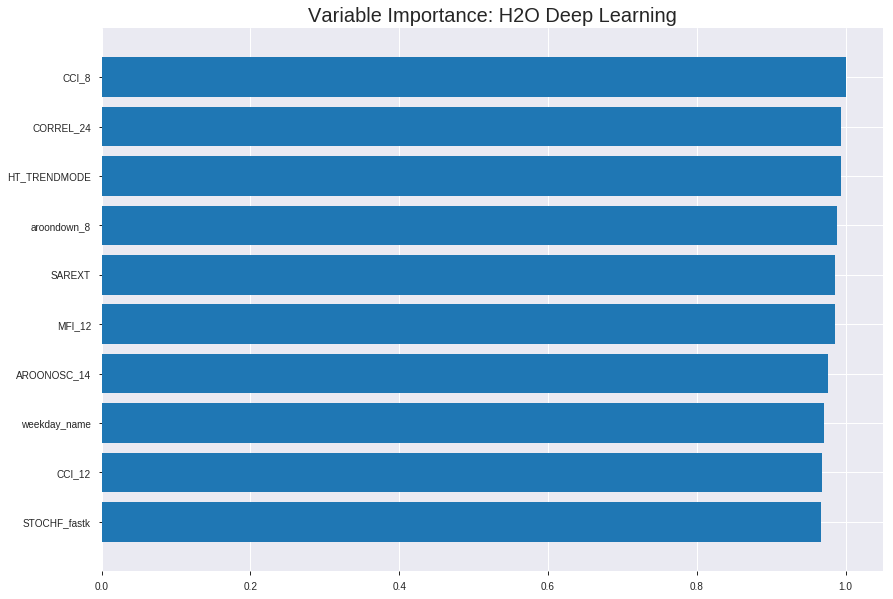

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_021428_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24989209141133506
RMSE: 0.49989207976455785
LogLoss: 0.692931367955142
Mean Per-Class Error: 0.48256547233851477
AUC: 0.5016392847237814
pr_auc: 0.5146406052194104
Gini: 0.0032785694475627736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4943782333535134: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    746   1        (746.0/746.0)
1      0    812   0        (0.0/812.0)
Total  0    1558  0.4788   (746.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.494378     0.685232   399
max f2                       0.494378     0.844777   399
max f0point5                 0.494535     0.576595   397
max accuracy                 0.494535     0.521823   397
max precision                0.506588     0.557333   107
max recall                   0.494378     1          399
max specificity              0.51182      0.99866    0
max absolute_mcc             0.508994     0.0627436  45
max min_per_class_accuracy   0.504633     0.5        173
max mean_per_class_accuracy  0.506588     0.517435   107

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.510782           1.07928   1.07928            0.5625           0.511181  0.5625                      0.511181            0.0110837       0.0110837                  7.92796    7.92796
    2        0.0205392                   0.510492           0.83944   0.95936            0.4375           0.510616  0.5                         0.510898            0.00862069      0.0197044                  -16.056    -4.06404
    3        0.0301669                   0.510237           0.767488  0.898124           0.4              0.510376  0.468085                    0.510732            0.00738916      0.0270936                  -23.2512   -10.1876
    4        0.0404365                   0.51012            0.95936   0.913676           0.5              0.510182  0.47619                     0.510592            0.00985222      0.0369458                  -4.06404   -8.63242
    5        0.0500642                   0.50991            0.639573  0.860964           0.333333         0.509984  0.448718                    0.510475            0.00615764      0.0431034                  -36.0427   -13.9036
    6        0.100128                    0.508803           0.836365  0.848664           0.435897         0.509323  0.442308                    0.509899            0.0418719       0.0849754                  -16.3635   -15.1336
    7        0.150193                    0.507523           1.18075   0.95936            0.615385         0.508039  0.5                         0.509279            0.0591133       0.144089                   18.075     -4.06404
    8        0.200257                    0.506925           1.18075   1.01471            0.615385         0.507193  0.528846                    0.508757            0.0591133       0.203202                   18.075     1.47073
    9        0.300385                    0.506178           0.996258  1.00856            0.519231         0.506525  0.525641                    0.508013            0.0997537       0.302956                   -0.374195  0.855753
    10       0.399872                    0.5055             0.990307  1.00402            0.516129         0.505822  0.523274                    0.507468            0.0985222       0.401478                   -0.969331  0.401679
    11       0.5                         0.504627           0.983959  1                  0.512821         0.505078  0.521181                    0.50699             0.0985222       0.5                        -1.60414   0
    12       0.600128                    0.503247           1.04546   1.00758            0.544872         0.504023  0.525134                    0.506495            0.10468         0.60468                    4.5456     0.75841
    13       0.699615                    0.501341           1.01506   1.00865            0.529032         0.502298  0.525688                    0.505898            0.100985        0.705665                   1.50644    0.864781
    14       0.799743                    0.500011           0.94706   1.00094            0.49359          0.500702  0.521669                    0.505247            0.0948276       0.800493                   -5.29399   0.0936989
    15       0.899872                    0.498375           0.922461  0.992205           0.480769         0.499283  0.517118                    0.504584            0.0923645       0.892857                   -7.75388   -0.779499
    16       1                           0.494378           1.07005   1                  0.557692         0.496465  0.521181             



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2495315716290466
RMSE: 0.4995313519980969
LogLoss: 0.6922102404814352
Mean Per-Class Error: 0.4512510088781275
AUC: 0.5400625504439064
pr_auc: 0.5530107270153319
Gini: 0.08012510088781277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5025652405017406: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    208  0.9905   (208.0/210.0)
1      0    236  0        (0.0/236.0)
Total  2    444  0.4664   (208.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502565     0.694118  397
max f2                       0.502565     0.850144  397
max f0point5                 0.503849     0.598901  352
max accuracy                 0.504098     0.560538  343
max precision                0.510772     1         0
max recall                   0.502565     1         397
max specificity              0.510772     1         0
max absolute_mcc             0.503849     0.120413  352
max min_per_class_accuracy   0.506456     0.538095  197
max mean_per_class_accuracy  0.505982     0.548749  231

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 50.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.510291           0.755932  0.755932           0.4              0.510533  0.4                         0.510533            0.00847458      0.00847458                 -24.4068  -24.4068
    2        0.0201794                   0.509952           1.41737   1.04991            0.75             0.51017   0.555556                    0.510372            0.0127119       0.0211864                  41.7373   4.99058
    3        0.0313901                   0.509723           1.1339    1.0799             0.6              0.509799  0.571429                    0.510167            0.0127119       0.0338983                  13.3898   7.99031
    4        0.0403587                   0.509626           0.944915  1.04991            0.5              0.509666  0.555556                    0.510056            0.00847458      0.0423729                  -5.50847  4.99058
    5        0.0515695                   0.509492           1.1339    1.06817            0.6              0.509541  0.565217                    0.509944            0.0127119       0.0550847                  13.3898   6.81651
    6        0.100897                    0.509159           1.28852   1.17589            0.681818         0.509333  0.622222                    0.509645            0.0635593       0.118644                   28.8521   17.5895
    7        0.150224                    0.508739           1.11672   1.15646            0.590909         0.508962  0.61194                     0.509421            0.0550847       0.173729                   11.6718   15.6463
    8        0.201794                    0.508212           0.657332  1.02891            0.347826         0.508503  0.544444                    0.509186            0.0338983       0.207627                   -34.2668  2.89077
    9        0.300448                    0.507679           0.816063  0.959018           0.431818         0.507949  0.507463                    0.50878             0.0805085       0.288136                   -18.3937  -4.09815
    10       0.401345                    0.507102           1.21789   1.0241             0.644444         0.507398  0.541899                    0.508432            0.122881        0.411017                   21.7891   2.40981
    11       0.5                         0.506465           1.24557   1.0678             0.659091         0.506738  0.565022                    0.508098            0.122881        0.533898                   24.557    6.77966
    12       0.600897                    0.505945           1.04991   1.06479            0.555556         0.50618   0.563433                    0.507776            0.105932        0.639831                   4.99058   6.47926
    13       0.699552                    0.50537            1.03082   1.06               0.545455         0.505682  0.560897                    0.507481            0.101695        0.741525                   3.08166   6.00011
    14       0.800448                    0.504646           0.755932  1.02167            0.4              0.505046  0.540616                    0.507174            0.0762712       0.817797                   -24.4068  2.16731
    15       0.899103                    0.503752           1.07377   1.02739            0.568182         0.504182  0.543641                    0.506846            0.105932        0.923729                   7.37673   2.73892
    16       1                           0.502451           0.755932  1                  0.4              0.503317  0.529148                    0.50649        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:32:25  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:32:27  5 min 21.808 sec  291 obs/sec       0.293967  1             458        0.61342          1.65959             -0.507842      0.512898        0.53374            1.07928          0.478819                         0.555776           0.908284              -0.23976         0.500353          0.543349             1.1339             0.46861
    2019-09-03 02:33:04  6 min  0.166 sec  239 obs/sec       5.46534   18            8515       0.501122         0.6954              -0.00629897    0.510073        0.524334           0.95936          0.474968                         0.501354           0.69586               -0.00885369      0.541546          0.539689             0.755932           0.43722
    2019-09-03 02:33:49  6 min 44.705 sec  248 obs/sec       12.0603   40            18790      0.499892         0.692931            -0.00136536    0.501639        0.514641           1.07928          0.478819                         0.499531           0.69221               -0.00152991      0.540063          0.553011             0.755932           0.466368
    2019-09-03 02:34:32  7 min 27.807 sec  269 obs/sec       19.8415   66            30913      0.500054         0.693255            -0.00201329    0.542585        0.508433           1.00181          0.478177                         0.500194           0.693534              -0.00418704      0.524778          0.459847             0.958224           0.466368
    2019-09-03 02:35:16  8 min 11.428 sec  290 obs/sec       28.6675   95            44664      0.502649         0.69863             -0.0124394     0.546282        0.539838           1.07091          0.476252                         0.504221           0.70188               -0.0204236       0.536158          0.507901             1.1474             0.466368
    2019-09-03 02:35:59  8 min 55.079 sec  316 obs/sec       39.2677   130           61179      0.499947         0.693029            -0.00158361    0.544498        0.101611           1.05385          0.464698                         0.501085           0.695324              -0.00777056      0.517211          0.18153              1.02366            0.46861
    2019-09-03 02:36:42  9 min 37.705 sec  333 obs/sec       49.5225   164           77156      0.497511         0.687543            0.00815169     0.541956        0.644435           1.43904          0.459564                         0.501326           0.69584               -0.00873748      0.500858          0.530569             1.1339             0.470852
    2019-09-03 02:36:46  9 min 42.436 sec  332 obs/sec       49.5225   164           77156      0.499892         0.692931            -0.00136536    0.501639        0.514641           1.07928          0.478819                         0.499531           0.69221               -0.00152991      0.540063          0.553011             0.755932           0.466368

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CCI_8                    1.0                    1.0                  0.0011494997599516793
CORREL_24                0.9937021732330322     0.9937021732330322   0.0011422604095948324
HT_TRENDMODE             0.9933702349662781     0.9933702349662781   0.0011418788466368798
aroondown_8              0.9879698753356934     0.9879698753356934   0.00113567113453787
SAREXT                   0.986226499080658      0.986226499080658    0.0011336671239512014
---                      ---                    ---                  ---
SMA_20                   0.7607329487800598     0.7607329487800598   0.0008744623420100118
BBANDS_upperband_12_5_2  0.7527555823326111     0.7527555823326111   0.0008652923611936229
CDLMARUBOZU              0.7484866976737976     0.7484866976737976   0.0008603852793030555
CDLENGULFING             0.7399771213531494     0.7399771213531494   0.0008506035233651799
CDL3OUTSIDE              0.7380644083023071     0.7380644083023071   0.0008484048601723802


See the whole table with table.as_data_frame()


('accuracy', 0.57847533632287)

('F1', 0.6481481481481481)

('auc', 0.5640032284100082)

('logloss', 0.6931508266095087)

('mean_per_class_error', 0.42401129943502824)

('rmse', 0.5000018519445218)

('mse', 0.2500018519479515)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


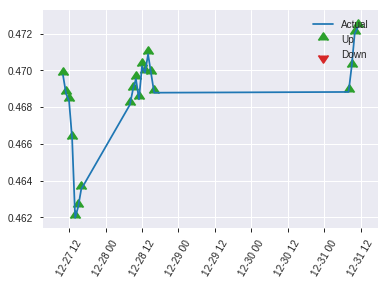


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2500018519479515
RMSE: 0.5000018519445218
LogLoss: 0.6931508266095087
Mean Per-Class Error: 0.42401129943502824
AUC: 0.5640032284100082
pr_auc: 0.534054382605898
Gini: 0.12800645682001632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.50017786730905: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    114  0.9661   (114.0/118.0)
1      0    105  0        (0.0/105.0)
Total  4    219  0.5112   (114.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500178     0.648148  218
max f2                       0.500178     0.821596  218
max f0point5                 0.503187     0.550907  152
max accuracy                 0.504332     0.578475  98
max precision                0.511221     1         0
max recall                   0.500178     1         218
max specificity              0.511221     1         0
max absolute_mcc             0.504291     0.152396  100
max min_per_class_accuracy   0.504094     0.559322  110
max mean_per_class_accuracy  0.504291     0.575989  100

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.510803           2.12381   2.12381            1                0.511013  1                           0.511013            0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.510589           1.0619    1.69905            0.5              0.510694  0.8                         0.510885            0.00952381      0.0380952                  6.19048   69.9048
    3        0.0313901                   0.510521           0         1.21361            0                0.510577  0.571429                    0.510797            0               0.0380952                  -100      21.3605
    4        0.0403587                   0.510471           0         0.943915           0                0.510497  0.444444                    0.51073             0               0.0380952                  -100      -5.60847
    5        0.0538117                   0.510435           2.12381   1.23889            1                0.510457  0.583333                    0.510662            0.0285714       0.0666667                  112.381   23.8889
    6        0.103139                    0.509591           1.35152   1.29275            0.636364         0.510058  0.608696                    0.510373            0.0666667       0.133333                   35.1515   29.2754
    7        0.152466                    0.508969           0.965368  1.18683            0.454545         0.509291  0.558824                    0.510023            0.047619        0.180952                   -3.4632   18.6835
    8        0.201794                    0.508248           1.35152   1.22709            0.636364         0.508594  0.577778                    0.509674            0.0666667       0.247619                   35.1515   22.709
    9        0.300448                    0.505913           0.965368  1.14115            0.454545         0.507334  0.537313                    0.508905            0.0952381       0.342857                   -3.4632   14.1151
    10       0.399103                    0.50457            1.15844   1.14543            0.545455         0.505025  0.539326                    0.507946            0.114286        0.457143                   15.8442   14.5425
    11       0.502242                    0.504062           1.01573   1.11879            0.478261         0.5043    0.526786                    0.507197            0.104762        0.561905                   1.5735    11.8793
    12       0.600897                    0.503528           0.772294  1.0619             0.363636         0.503773  0.5                         0.506635            0.0761905       0.638095                   -22.7706  6.19048
    13       0.699552                    0.503098           1.25498   1.08913            0.590909         0.503312  0.512821                    0.506166            0.12381         0.761905                   25.4978   8.91331
    14       0.798206                    0.502515           0.386147  1.00225            0.181818         0.502828  0.47191                     0.505754            0.0380952       0.8                        -61.3853  0.224719
    15       0.896861                    0.500661           0.965368  0.99819            0.454545         0.501964  0.47                        0.505337            0.0952381       0.895238                   -3.4632   -0.180952
    16       1                           0.499728           1.01573   1                  0.478261         0.500288  0.470852                    0.504816      

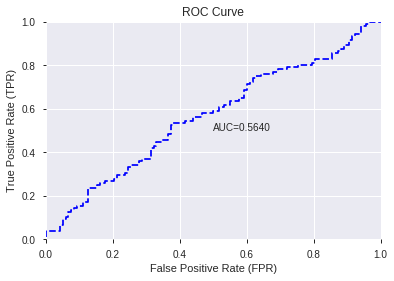

This function is available for GLM models only


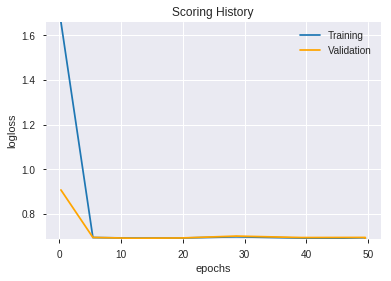

--2019-09-03 02:37:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  26.0MB/s    in 20s     

2019-09-03 02:37:20 (17.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_021428_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_021428_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_023734_model_4  0.576352  0.814415              0.500000  0.532566  0.283626
1               DeepLearning_1_AutoML_20190903_023734  0.564165  0.719497              0.475101  0.510102  0.260204
2  DeepLearning_grid_1_AutoML_20190903_023734_model_2  0.558676  0.901225              0.491525  0.542078  0.293849
3  DeepLearning_grid_1_AutoML_20190903_023734_model_3  0.557385  0.808211              0.495763  0.538324  0.289793
4  DeepLearning_grid_1_AutoML_20190903_023734_model_9  0.549153  0.694333              0.456013  0.500590  0.250590
5  DeepLearning_grid_1_AutoML_20190903_023734_model_5  0.548507  0.695317              0.491525  0.500689  0.250690
6  DeepLearning_grid_1_AutoML_20190903_023734_model_7  0.548184  0.772641              0.495763  0.529664  0.280544
7  DeepLearning_grid_1_AutoML_20190903_023734_model_6  0.537853  0.704674              0.487288  0.505265  0.255292
8  DeepLearning_grid_1_AutoML_20190903_023734_model_1  0.513398  1.055282              0.495763  0.585268  0.342539
9  DeepLearning_grid_1_AutoML_20190903_023734_model_8  0.494108  0.698593              0.500000  0.502709  0.252717

variable  relative_importance  scaled_importance  percentage
0     MACDFIX_hist_14             1.000000           1.000000    0.022956
1                 BOP             0.985557           0.985557    0.022624
2   LINEARREG_SLOPE_8             0.978828           0.978828    0.022470
3       days_in_month             0.976988           0.976988    0.022427
4              ADXR_8             0.975200           0.975200    0.022386
5           CORREL_30             0.917613           0.917613    0.021064
6        HT_TRENDMODE             0.915022           0.915022    0.021005
7              MFI_12             0.914353           0.914353    0.020990
8        aroondown_12             0.910818           0.910818    0.020908
9          PLUS_DI_12             0.909564           0.909564    0.020880
10         aroonup_30             0.908695           0.908695    0.020860
11         MINUS_DM_8             0.902562           0.902562    0.020719
12        HT_DCPERIOD             0.902256           0.902256    0.020712
13              DX_12             0.895473           0.895473    0.020556
14          aroonup_8             0.892967           0.892967    0.020499
15        AROONOSC_20             0.888858           0.888858    0.020404
16          CORREL_24             0.888025           0.888025    0.020385
17             CCI_14             0.887244           0.887244    0.020367
18             CMO_30             0.878627           0.878627    0.020170
19             SAREXT             0.877813           0.877813    0.020151
20           WILLR_20             0.873656           0.873656    0.020055
21        aroondown_8             0.868634           0.868634    0.019940
22     STOCHRSI_fastk             0.866129           0.866129    0.019883
23        MINUS_DI_20             0.865103           0.865103    0.019859
24         aroonup_14             0.863462           0.863462    0.019821
25              CCI_8             0.862224           0.862224    0.019793
26        MINUS_DM_14             0.861609           0.861609    0.019779
27           WILLR_12             0.859798           0.859798    0.019737
28        STOCH_slowk             0.858207           0.858207    0.019701
29       STOCHF_fastk             0.857899           0.857899    0.019694
30        AROONOSC_30             0.856250           0.856250    0.019656
31         aroonup_24             0.855222           0.855222    0.019632
32             CCI_12             0.852517           0.852517    0.019570
33        AROONOSC_24             0.852078           0.852078    0.019560
34     STOCHRSI_fastd             0.849694           0.849694    0.019505
35       STOCHF_fastd             0.847235           0.847235    0.019449
36        AROONOSC_14             0.845041           0.845041    0.019399
37             CCI_24             0.838436           0.838436    0.019247
38           WILLR_24             0.829170           0.829170    0.019034
39             RSI_12             0.828716           0.828716    0.019024
40             CMO_12             0.827192           0.827192    0.018989
41          dayofweek             0.825247           0.825247    0.018944
42              CMO_8             0.824973           0.824973    0.018938
43            WILLR_8             0.817687           0.817687    0.018771
44             MFI_14             0.814780           0.814780    0.018704
45         AROONOSC_8             0.811380           0.811380    0.018626
46       weekday_name             0.810399           0.810399    0.018603
47            weekday             0.793910           0.793910    0.018225
48          CORREL_20             0.770038           0.770038    0.017677
49             CMO_14             0.768994           0.768994    0.017653

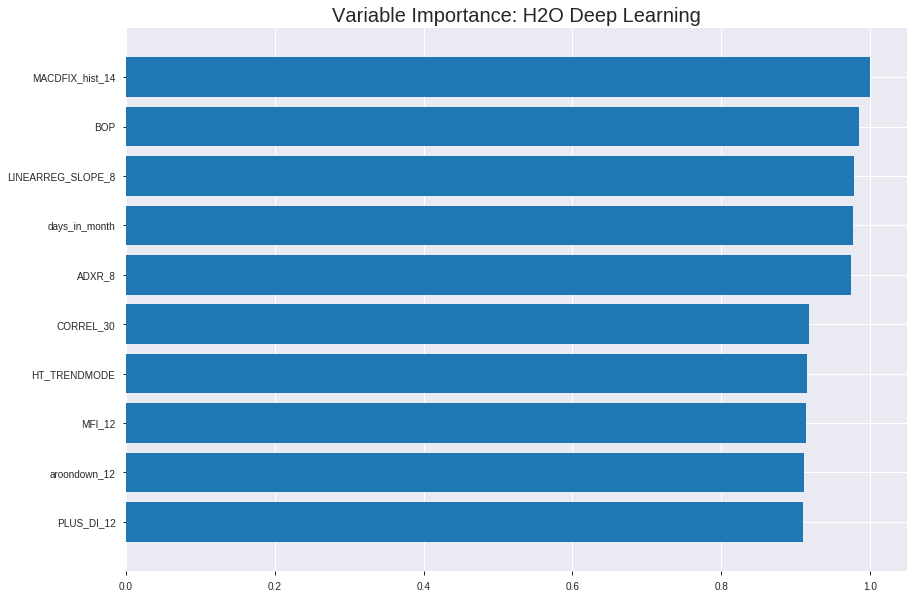

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_023734_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17693171291229465
RMSE: 0.4206325152818011
LogLoss: 0.5258419275186693
Mean Per-Class Error: 0.24070081485492412
AUC: 0.83637858397496
pr_auc: 0.8459884477324241
Gini: 0.67275716794992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2884528166522194: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      458  288   0.3861   (288.0/746.0)
1      99   713   0.1219   (99.0/812.0)
Total  557  1001  0.2484   (387.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288453     0.786542  271
max f2                       0.113057     0.86597   352
max f0point5                 0.485491     0.776017  182
max accuracy                 0.38169      0.759949  228
max precision                0.985472     1         0
max recall                   0.0430615    1         381
max specificity              0.985472     1         0
max absolute_mcc             0.38169      0.518852  228
max min_per_class_accuracy   0.393883     0.754692  223
max mean_per_class_accuracy  0.38169      0.759299  228

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 42.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.945232           1.91872   1.91872            1                0.964781   1                           0.964781            0.0197044       0.0197044                  91.8719   91.8719
    2        0.0205392                   0.928273           1.91872   1.91872            1                0.936464   1                           0.950623            0.0197044       0.0394089                  91.8719   91.8719
    3        0.0301669                   0.912243           1.91872   1.91872            1                0.92055    1                           0.941025            0.0184729       0.0578818                  91.8719   91.8719
    4        0.0404365                   0.893643           1.91872   1.91872            1                0.903694   1                           0.931544            0.0197044       0.0775862                  91.8719   91.8719
    5        0.0500642                   0.866846           1.91872   1.91872            1                0.878841   1                           0.921409            0.0184729       0.0960591                  91.8719   91.8719
    6        0.100128                    0.781994           1.77113   1.84492            0.923077         0.821299   0.961538                    0.871354            0.08867         0.184729                   77.1125   84.4922
    7        0.150193                    0.725759           1.74653   1.81212            0.910256         0.751644   0.944444                    0.831451            0.0874384       0.272167                   74.6526   81.2124
    8        0.200257                    0.677782           1.52514   1.74038            0.794872         0.700573   0.907051                    0.798731            0.0763547       0.348522                   52.5136   74.0377
    9        0.300385                    0.574425           1.52514   1.66863            0.794872         0.626268   0.869658                    0.741244            0.152709        0.501232                   52.5136   66.863
    10       0.399872                    0.489065           1.2874    1.57378            0.670968         0.532324   0.820225                    0.689265            0.128079        0.62931                    28.7399   57.3781
    11       0.5                         0.40396            1.11925   1.48276            0.583333         0.450602   0.772786                    0.641471            0.112069        0.741379                   11.9253   48.2759
    12       0.600128                    0.320371           0.95936   1.39543            0.5              0.35939    0.727273                    0.594408            0.0960591       0.837438                   -4.06404  39.5432
    13       0.699615                    0.242122           0.705594  1.29734            0.367742         0.28126    0.676147                    0.549877            0.070197        0.907635                   -29.4406  29.7336
    14       0.799743                    0.162928           0.442781  1.19035            0.230769         0.203416   0.620385                    0.5065              0.044335        0.95197                    -55.7219  19.0345
    15       0.899872                    0.0837868          0.368984  1.09895            0.192308         0.124242   0.572753                    0.463967            0.0369458       0.988916                   -63.1016  9.89526
    16       1                           0.00197255         0.110695  1                  0.0576923        0.0454214  0.521181                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2992264091054652
RMSE: 0.5470159130276424
LogLoss: 0.8534550302327926
Mean Per-Class Error: 0.43777239709443094
AUC: 0.5391747376916869
pr_auc: 0.5433069620134224
Gini: 0.07834947538337378
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08284214052973429: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   193  0.919    (193.0/210.0)
1      7    229  0.0297   (7.0/236.0)
Total  24   422  0.4484   (200.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0828421    0.696049  376
max f2                       0.0110597    0.849532  398
max f0point5                 0.0828421    0.595114  376
max accuracy                 0.425109     0.565022  218
max precision                0.968334     0.666667  2
max recall                   0.0110597    1         398
max specificity              0.989345     0.995238  0
max absolute_mcc             0.425109     0.12491   218
max min_per_class_accuracy   0.460434     0.547619  201
max mean_per_class_accuracy  0.425109     0.562228  218

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 47.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.946383           1.1339    1.1339             0.6              0.969253   0.6                         0.969253            0.0127119       0.0127119                  13.3898   13.3898
    2        0.0201794                   0.928046           0.472458  0.839925           0.25             0.938265   0.444444                    0.955481            0.00423729      0.0169492                  -52.7542  -16.0075
    3        0.0313901                   0.912063           0.755932  0.809927           0.4              0.921186   0.428571                    0.943233            0.00847458      0.0254237                  -24.4068  -19.0073
    4        0.0403587                   0.884725           1.41737   0.944915           0.75             0.895597   0.5                         0.932647            0.0127119       0.0381356                  41.7373   -5.50847
    5        0.0515695                   0.878018           1.51186   1.06817            0.8              0.881101   0.565217                    0.921441            0.0169492       0.0550847                  51.1864   6.81651
    6        0.100897                    0.826181           0.515408  0.797928           0.272727         0.857507   0.422222                    0.890185            0.0254237       0.0805085                  -48.4592  -20.2072
    7        0.150224                    0.761143           1.37442   0.987225           0.727273         0.793142   0.522388                    0.85832             0.0677966       0.148305                   37.4422   -1.27751
    8        0.201794                    0.714165           1.2325    1.04991            0.652174         0.736292   0.555556                    0.827135            0.0635593       0.211864                   23.2498   4.99058
    9        0.300448                    0.61165            1.20262   1.10005            0.636364         0.659258   0.58209                     0.772011            0.118644        0.330508                   20.2619   10.0051
    10       0.401345                    0.545878           1.00791   1.07689            0.533333         0.579148   0.569832                    0.723526            0.101695        0.432203                   0.79096   7.68867
    11       0.5                         0.463547           1.15967   1.09322            0.613636         0.502054   0.578475                    0.679827            0.114407        0.54661                    15.9669   9.32203
    12       0.600897                    0.394895           1.00791   1.0789             0.533333         0.42743    0.570896                    0.637447            0.101695        0.648305                   0.79096   7.88958
    13       0.699552                    0.312679           0.64426   1.0176             0.340909         0.350205   0.538462                    0.596939            0.0635593       0.711864                   -35.574   1.7601
    14       0.800448                    0.223272           0.965913  1.01109            0.511111         0.268301   0.535014                    0.555514            0.0974576       0.809322                   -3.40866  1.10858
    15       0.899103                    0.14099            1.07377   1.01796            0.568182         0.179029   0.538653                    0.514204            0.105932        0.915254                   7.37673   1.79636
    16       1                           0.00200255         0.839925  1                  0.444444         0.0779348  0.529148               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:39:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:39:25  5.269 sec         331 obs/sec       1         1             1558       0.672783         4.96792             -0.813805      0.547121        0.507228           0.83944          0.478819                         0.696259           5.36595               -0.945718        0.509776          0.514924             1.1339             0.470852
    2019-09-03 02:39:32  12.616 sec        404 obs/sec       3         3             4674       0.648179         2.55375             -0.683566      0.570058        0.560997           0.95936          0.478819                         0.686494           2.77372               -0.891526        0.521277          0.532648             1.51186            0.464126
    2019-09-03 02:39:39  18.758 sec        452 obs/sec       5         5             7790       0.658994         2.65501             -0.740216      0.579078        0.579214           1.1992           0.478819                         0.700381           3.07094               -0.968823        0.49884           0.514354             1.1339             0.446188
    2019-09-03 02:39:45  25.018 sec        474 obs/sec       7         7             10906      0.607512         1.46025             -0.478936      0.594877        0.577675           0.83944          0.442234                         0.636124           1.56173               -0.624136        0.536562          0.537762             1.51186            0.434978
    2019-09-03 02:39:51  31.709 sec        533 obs/sec       10        10            15580      0.609525         1.37224             -0.488754      0.608686        0.594001           1.1992           0.450578                         0.643646           1.47408               -0.662773        0.531891          0.538023             1.1339             0.452915
    2019-09-03 02:39:57  37.406 sec        588 obs/sec       13        13            20254      0.565023         1.06233             -0.279299      0.63194         0.623296           1.1992           0.444801                         0.630814           1.30998               -0.597133        0.523931          0.530205             1.51186            0.457399
    2019-09-03 02:40:02  42.680 sec        636 obs/sec       16        16            24928      0.539201         0.887032            -0.165043      0.668663        0.668685           1.67888          0.403081                         0.620827           1.18978               -0.546962        0.508313          0.533488             1.51186            0.457399
    2019-09-03 02:40:08  48.478 sec        700 obs/sec       20        20            31160      0.48483          0.686587            0.0580706      0.714669        0.717888           1.91872          0.367779                         0.57573            0.958714              -0.330383        0.518604          0.522465             1.1339             0.452915
    2019-09-03 02:40:14

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
MACDFIX_hist_14    1.0                    1.0                  0.02295571281961608
BOP                0.9855568408966064     0.9855568408966064   0.022624159807030555
LINEARREG_SLOPE_8  0.978827953338623      0.978827953338623    0.022469693396654
days_in_month      0.9769881367683411     0.9769881367683411   0.022427459095825834
ADXR_8             0.9752000570297241     0.9752000570297241   0.02238641245084757
---                ---                    ---                  ---
AROONOSC_8         0.8113804459571838     0.8113804459571838   0.018625816504845138
weekday_name       0.8103992938995361     0.8103992938995361   0.0186032934599774
weekday            0.7939099073410034     0.7939099073410034   0.018224767837568087
CORREL_20          0.7700382471084595     0.7700382471084595   0.017676776860742358
CMO_14             0.7689939141273499     0.7689939141273499   0.01765280345273995


See the whole table with table.as_data_frame()


('accuracy', 0.6188340807174888)

('F1', 0.6402439024390244)

('auc', 0.5763518966908797)

('logloss', 0.8144147456153538)

('mean_per_class_error', 0.3947941888619855)

('rmse', 0.5325657923235496)

('mse', 0.2836263231532101)

deeplearning prediction progress: |███████████████████████████████████████| 100%


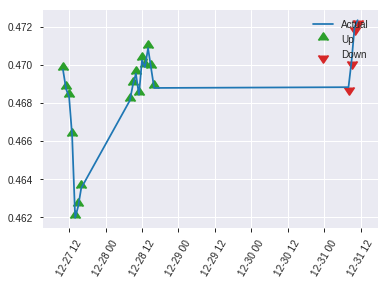


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2836263231532101
RMSE: 0.5325657923235496
LogLoss: 0.8144147456153538
Mean Per-Class Error: 0.3947941888619855
AUC: 0.5763518966908797
pr_auc: 0.5617171351248746
Gini: 0.15270379338175943
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.006062530316084099: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    105  0        (0.0/105.0)
Total  0    223  0.5291   (118.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00606253   0.640244  222
max f2                       0.00606253   0.816485  222
max f0point5                 0.716657     0.578635  57
max accuracy                 0.721085     0.618834  55
max precision                0.985934     1         0
max recall                   0.00606253   1         222
max specificity              0.985934     1         0
max absolute_mcc             0.721085     0.240981  55
max min_per_class_accuracy   0.56116      0.567797  110
max mean_per_class_accuracy  0.716657     0.605206  57

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 51.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.902476           1.41587   1.41587            0.666667         0.941199   0.666667                    0.941199            0.0190476       0.0190476                  41.5873   41.5873
    2        0.0224215                   0.879608           1.0619    1.27429            0.5              0.892283   0.6                         0.921633            0.00952381      0.0285714                  6.19048   27.4286
    3        0.0313901                   0.870591           1.0619    1.21361            0.5              0.875039   0.571429                    0.90832             0.00952381      0.0380952                  6.19048   21.3605
    4        0.0403587                   0.858137           1.0619    1.17989            0.5              0.865267   0.555556                    0.898753            0.00952381      0.047619                   6.19048   17.9894
    5        0.0538117                   0.838343           2.12381   1.41587            1                0.847307   0.666667                    0.885891            0.0285714       0.0761905                  112.381   41.5873
    6        0.103139                    0.809406           1.54459   1.47743            0.727273         0.822897   0.695652                    0.855764            0.0761905       0.152381                   54.4589   47.7433
    7        0.152466                    0.771105           1.54459   1.49916            0.727273         0.786205   0.705882                    0.833259            0.0761905       0.228571                   54.4589   49.916
    8        0.201794                    0.732783           1.15844   1.41587            0.545455         0.758925   0.666667                    0.815089            0.0571429       0.285714                   15.8442   41.5873
    9        0.300448                    0.693019           1.25498   1.36304            0.590909         0.717811   0.641791                    0.783147            0.12381         0.409524                   25.4978   36.3042
    10       0.399103                    0.624307           0.772294  1.21701            0.363636         0.662427   0.573034                    0.753306            0.0761905       0.485714                   -22.7706  21.7014
    11       0.502242                    0.558795           0.831056  1.13776            0.391304         0.592835   0.535714                    0.720352            0.0857143       0.571429                   -16.8944  13.7755
    12       0.600897                    0.476016           0.482684  1.03021            0.227273         0.515344   0.485075                    0.686694            0.047619        0.619048                   -51.7316  3.02061
    13       0.699552                    0.394649           0.868831  1.00745            0.409091         0.431623   0.474359                    0.650722            0.0857143       0.704762                   -13.1169  0.744811
    14       0.798206                    0.293391           0.965368  1.00225            0.454545         0.341113   0.47191                     0.612456            0.0952381       0.8                        -3.4632   0.224719
    15       0.896861                    0.176948           1.0619    1.00881            0.5              0.230613   0.475                       0.570453            0.104762        0.904762                   6.19048   0.880952
    16       1                           0.00606253         0.923395  1                  0.434783         0.0807695  0.470852                 

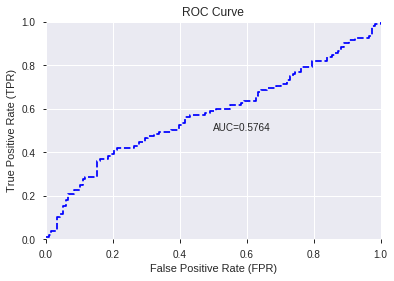

This function is available for GLM models only


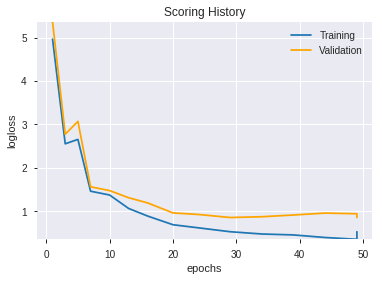

--2019-09-03 02:44:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_023734_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_023734_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['MACDFIX_hist_14',
 'BOP',
 'LINEARREG_SLOPE_8',
 'days_in_month',
 'ADXR_8',
 'CORREL_30',
 'HT_TRENDMODE',
 'MFI_12',
 'aroondown_12',
 'PLUS_DI_12',
 'aroonup_30',
 'MINUS_DM_8',
 'HT_DCPERIOD',
 'DX_12',
 'aroonup_8',
 'AROONOSC_20',
 'CORREL_24',
 'CCI_14',
 'CMO_30',
 'SAREXT',
 'WILLR_20',
 'aroondown_8',
 'STOCHRSI_fastk',
 'MINUS_DI_20',
 'aroonup_14',
 'CCI_8',
 'MINUS_DM_14',
 'WILLR_12',
 'STOCH_slowk',
 'STOCHF_fastk',
 'AROONOSC_30',
 'aroonup_24',
 'CCI_12',
 'AROONOSC_24',
 'STOCHRSI_fastd',
 'STOCHF_fastd',
 'AROONOSC_14',
 'CCI_24',
 'WILLR_24',
 'RSI_12',
 'CMO_12',
 'dayofweek',
 'CMO_8',
 'WILLR_8',
 'MFI_14',
 'AROONOSC_8',
 'weekday_name',
 'weekday',
 'CORREL_20',
 'CMO_14']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190903_024501_model_1  0.551009  0.695709              0.495763  0.501278  0.25128

variable  relative_importance  scaled_importance  percentage
0        weekday_name             0.008239           1.000000    0.045455
1             weekday             0.007919           0.961150    0.043689
2           dayofweek             0.007901           0.958951    0.043589
3              SAREXT             0.007480           0.907875    0.041267
4           aroonup_8             0.006789           0.823995    0.037454
5           CORREL_20             0.006770           0.821679    0.037349
6       days_in_month             0.006575           0.798040    0.036275
7      STOCHRSI_fastk             0.006026           0.731362    0.033244
8                 BOP             0.005845           0.709391    0.032245
9               DX_12             0.005701           0.691931    0.031452
10    MACDFIX_hist_14             0.005680           0.689357    0.031335
11       STOCHF_fastk             0.005542           0.672613    0.030573
12            WILLR_8             0.005270           0.639646    0.029075
13           WILLR_12             0.005221           0.633671    0.028803
14           WILLR_20             0.005121           0.621511    0.028251
15         AROONOSC_8             0.005109           0.620125    0.028188
16           WILLR_24             0.004807           0.583464    0.026521
17             ADXR_8             0.004658           0.565323    0.025697
18       aroondown_12             0.004149           0.503591    0.022891
19              CCI_8             0.003816           0.463140    0.021052
20       HT_TRENDMODE             0.003744           0.454451    0.020657
21             CMO_30             0.003706           0.449840    0.020447
22        HT_DCPERIOD             0.003679           0.446553    0.020298
23     STOCHRSI_fastd             0.003536           0.429145    0.019507
24  LINEARREG_SLOPE_8             0.002952           0.358255    0.016284
25             CCI_24             0.002929           0.355539    0.016161
26             MFI_12             0.002918           0.354144    0.016098
27             MFI_14             0.002771           0.336349    0.015289
28              CMO_8             0.002540           0.308296    0.014014
29        AROONOSC_20             0.002483           0.301381    0.013699
30             CMO_14             0.002350           0.285212    0.012964
31             CCI_14             0.002323           0.281999    0.012818
32             CMO_12             0.002259           0.274194    0.012463
33         aroonup_30             0.002252           0.273383    0.012427
34             RSI_12             0.002248           0.272828    0.012401
35         aroonup_14             0.002105           0.255477    0.011613
36        aroondown_8             0.001970           0.239146    0.010870
37         MINUS_DM_8             0.001955           0.237261    0.010785
38        STOCH_slowk             0.001858           0.225531    0.010251
39       STOCHF_fastd             0.001846           0.224086    0.010186
40         PLUS_DI_12             0.001708           0.207267    0.009421
41        MINUS_DM_14             0.001599           0.194041    0.008820
42        AROONOSC_30             0.001575           0.191213    0.008692
43             CCI_12             0.001338           0.162425    0.007383
44        AROONOSC_24             0.001000           0.121386    0.005518
45        MINUS_DI_20             0.000772           0.093677    0.004258
46          CORREL_24             0.000672           0.081555    0.003707
47          CORREL_30             0.000618           0.074968    0.003408
48         aroonup_24             0.000534           0.064757    0.002944
49        AROONOSC_14             0.000401           0.048725    0.002215

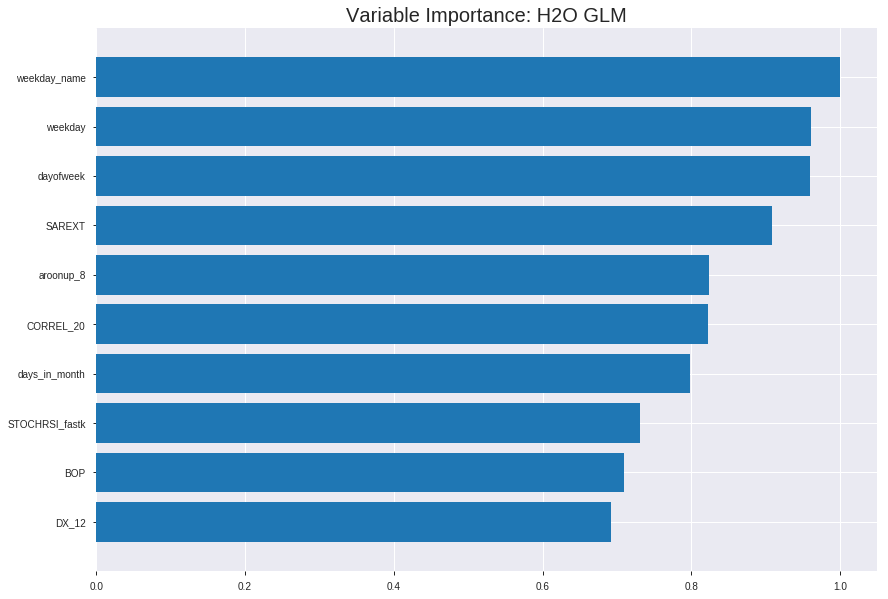

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_024501_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24810933518724773
RMSE: 0.4981057469927924
LogLoss: 0.6893579121254979
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2157.0498856314666
Residual deviance: 2148.0392541830524
AIC: 2250.0392541830524
AUC: 0.5685891255827468
pr_auc: 0.5839211443868362
Gini: 0.13717825116549354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4975665196675173: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      21   725   0.9718   (725.0/746.0)
1      10   802   0.0123   (10.0/812.0)
Total  31   1527  0.4718   (735.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497567     0.685763  377
max f2                       0.485166     0.844777  399
max f0point5                 0.501657     0.583882  355
max accuracy                 0.520221     0.557766  212
max precision                0.559738     1         0
max recall                   0.485166     1         399
max specificity              0.559738     1         0
max absolute_mcc             0.531728     0.119233  121
max min_per_class_accuracy   0.520614     0.554187  209
max mean_per_class_accuracy  0.520221     0.557271  212

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.551265           1.43904   1.43904            0.75             0.554048  0.75                        0.554048            0.0147783       0.0147783                  43.9039    43.9039
    2        0.0205392                   0.548276           1.1992    1.31912            0.625            0.549828  0.6875                      0.551938            0.0123153       0.0270936                  19.92      31.9119
    3        0.0301669                   0.545688           1.02332   1.22471            0.533333         0.546872  0.638298                    0.550321            0.00985222      0.0369458                  2.33169    22.4714
    4        0.0404365                   0.544274           1.1992    1.21823            0.625            0.544833  0.634921                    0.548927            0.0123153       0.0492611                  19.92      21.8234
    5        0.0500642                   0.542859           1.27915   1.22995            0.666667         0.543544  0.641026                    0.547892            0.0123153       0.0615764                  27.9146    22.9948
    6        0.100128                    0.539004           1.27915   1.25455            0.666667         0.540887  0.653846                    0.54439             0.0640394       0.125616                   27.9146    25.4547
    7        0.150193                    0.535946           1.00856   1.17255            0.525641         0.537557  0.611111                    0.542112            0.0504926       0.176108                   0.855753   17.2551
    8        0.200257                    0.533419           1.30375   1.20535            0.679487         0.534751  0.628205                    0.540272            0.0652709       0.241379                   30.3745    20.5349
    9        0.300385                    0.52878            1.03316   1.14795            0.538462         0.531072  0.598291                    0.537205            0.103448        0.344828                   3.31565    14.7952
    10       0.399872                    0.524569           0.965549  1.10257            0.503226         0.526691  0.574639                    0.534589            0.0960591       0.440887                   -3.4451    10.2571
    11       0.5                         0.520646           1.09465   1.10099            0.570513         0.522481  0.573813                    0.532165            0.109606        0.550493                   9.46539    10.0985
    12       0.600128                    0.516709           0.848664  1.05889            0.442308         0.518731  0.551872                    0.529923            0.0849754       0.635468                   -15.1336   5.88868
    13       0.699615                    0.513157           0.990307  1.04913            0.516129         0.514848  0.546789                    0.52778             0.0985222       0.73399                    -0.969331  4.91345
    14       0.799743                    0.509063           0.95936   1.03789            0.5              0.511035  0.540931                    0.525683            0.0960591       0.830049                   -4.06404   3.78947
    15       0.899872                    0.504073           0.885563  1.02094            0.461538         0.506673  0.532097                    0.523568            0.08867         0.918719                   -11.4437   2.09447
    16       1                           0.485166           0.811766  1                  0.423077         0.499729  0.521181                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.249589633973719
RMSE: 0.49958946543509003
LogLoss: 0.6923313803009273
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 616.8842253342874
Residual deviance: 617.5595912284272
AIC: 719.5595912284272
AUC: 0.5026533494753833
pr_auc: 0.5105199002003218
Gini: 0.005306698950766631
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49058793445871235: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    208  0.9905   (208.0/210.0)
1      1    235  0.0042   (1.0/236.0)
Total  3    443  0.4686   (209.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490588     0.692194  396
max f2                       0.485436     0.848921  399
max f0point5                 0.502591     0.585609  370
max accuracy                 0.514198     0.535874  262
max precision                0.525377     0.559524  153
max recall                   0.485436     1         399
max specificity              0.553533     0.995238  0
max absolute_mcc             0.548964     0.140651  16
max min_per_class_accuracy   0.520908     0.5       198
max mean_per_class_accuracy  0.514198     0.526816  262

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.551929           0.377966  0.377966           0.2              0.55269   0.2                         0.55269             0.00423729      0.00423729                 -62.2034  -62.2034
    2        0.0201794                   0.550054           0.472458  0.419962           0.25             0.551134  0.222222                    0.551999            0.00423729      0.00847458                 -52.7542  -58.0038
    3        0.0313901                   0.549283           0.377966  0.404964           0.2              0.549799  0.214286                    0.551213            0.00423729      0.0127119                  -62.2034  -59.5036
    4        0.0403587                   0.548216           0.472458  0.419962           0.25             0.548822  0.222222                    0.550682            0.00423729      0.0169492                  -52.7542  -58.0038
    5        0.0515695                   0.547027           1.51186   0.657332           0.8              0.547455  0.347826                    0.54998             0.0169492       0.0338983                  51.1864   -34.2668
    6        0.100897                    0.543628           1.03082   0.839925           0.545455         0.545553  0.444444                    0.547816            0.0508475       0.0847458                  3.08166   -16.0075
    7        0.150224                    0.538731           0.773112  0.817986           0.409091         0.5412    0.432836                    0.545643            0.0381356       0.122881                   -22.6888  -18.2014
    8        0.201794                    0.534041           1.15033   0.902919           0.608696         0.536223  0.477778                    0.543236            0.059322        0.182203                   15.0332   -9.7081
    9        0.300448                    0.528654           1.24557   1.01543            0.659091         0.530959  0.537313                    0.539205            0.122881        0.305085                   24.557    1.54313
    10       0.401345                    0.524458           1.0919    1.03466            0.577778         0.526412  0.547486                    0.535989            0.110169        0.415254                   9.19021   3.46558
    11       0.5                         0.520534           0.859014  1                  0.454545         0.522528  0.529148                    0.533333            0.0847458       0.5                        -14.0986  0
    12       0.600897                    0.517174           1.17589   1.02953            0.622222         0.518758  0.544776                    0.530885            0.118644        0.618644                   17.5895   2.95345
    13       0.699552                    0.512068           0.816063  0.99943            0.431818         0.51449   0.528846                    0.528573            0.0805085       0.699153                   -18.3937  -0.0570404
    14       0.800448                    0.50832            1.0919    1.01109            0.577778         0.510161  0.535014                    0.526252            0.110169        0.809322                   9.19021   1.10858
    15       0.899103                    0.504323           0.859014  0.9944             0.454545         0.506607  0.526185                    0.524097            0.0847458       0.894068                   -14.0986  -0.560041
    16       1                           0.485436           1.04991   1                  0.555556         0.499592  0.529148                    0.521624   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:45:02  0.000 sec   2            2.8       51            1.37872           1.38466
    2019-09-03 02:45:02  0.030 sec   4            1.8       51            1.37633           1.38587
    2019-09-03 02:45:02  0.059 sec   6            1.1       51            1.37319           1.38769
    2019-09-03 02:45:02  0.097 sec   8            0.68      51            1.36928           1.39026
    2019-09-03 02:45:02  0.124 sec   10           0.42      51            1.36467           1.39373

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6422018348623852)

('auc', 0.5510088781275223)

('logloss', 0.6957091070370731)

('mean_per_class_error', 0.4351896690879742)

('rmse', 0.5012784661154263)

('mse', 0.2512801005910345)

glm prediction progress: |████████████████████████████████████████████████| 100%


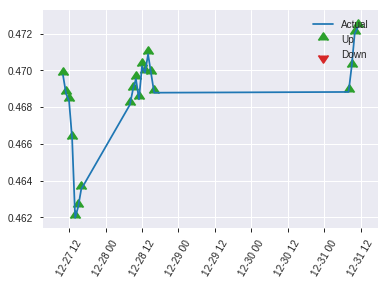


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2512801005910345
RMSE: 0.5012784661154263
LogLoss: 0.6957091070370731
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 310.6462559060497
Residual deviance: 310.2862617385346
AIC: 412.2862617385346
AUC: 0.5510088781275223
pr_auc: 0.5157206176642297
Gini: 0.10201775625504461
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49213425502590025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    117  0.9915   (117.0/118.0)
1      0    105  0        (0.0/105.0)
Total  1    222  0.5247   (117.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492134     0.642202  221
max f2                       0.492134     0.817757  221
max f0point5                 0.522149     0.546493  126
max accuracy                 0.535206     0.565022  51
max precision                0.551911     1         0
max recall                   0.492134     1         221
max specificity              0.551911     1         0
max absolute_mcc             0.522149     0.130669  126
max min_per_class_accuracy   0.52419      0.542857  109
max mean_per_class_accuracy  0.522149     0.56481   126

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 52.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.550251           2.12381   2.12381            1                0.550862  1                           0.550862            0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.5498             0         1.27429            0                0.550208  0.6                         0.550601            0               0.0285714                  -100      27.4286
    3        0.0313901                   0.548432           1.0619    1.21361            0.5              0.54902   0.571429                    0.550149            0.00952381      0.0380952                  6.19048   21.3605
    4        0.0403587                   0.547785           0         0.943915           0                0.548257  0.444444                    0.549729            0               0.0380952                  -100      -5.60847
    5        0.0538117                   0.54695            0.707937  0.884921           0.333333         0.547422  0.416667                    0.549152            0.00952381      0.047619                   -29.2063  -11.5079
    6        0.103139                    0.542416           1.73766   1.29275            0.818182         0.544439  0.608696                    0.546898            0.0857143       0.133333                   73.7662   29.2754
    7        0.152466                    0.539179           0.579221  1.0619             0.272727         0.54078   0.5                         0.544919            0.0285714       0.161905                   -42.0779  6.19048
    8        0.201794                    0.535665           1.73766   1.22709            0.818182         0.537723  0.577778                    0.54316             0.0857143       0.247619                   73.7662   22.709
    9        0.300448                    0.532919           0.965368  1.14115            0.454545         0.534658  0.537313                    0.540368            0.0952381       0.342857                   -3.4632   14.1151
    10       0.399103                    0.527778           0.965368  1.0977             0.454545         0.530439  0.516854                    0.537914            0.0952381       0.438095                   -3.4632   9.76993
    11       0.502242                    0.52405            1.10807   1.09983            0.521739         0.525805  0.517857                    0.535427            0.114286        0.552381                   10.8075   9.98299
    12       0.600897                    0.520751           1.15844   1.10945            0.545455         0.522473  0.522388                    0.5333              0.114286        0.666667                   15.8442   10.9453
    13       0.699552                    0.517436           0.579221  1.03468            0.272727         0.519095  0.487179                    0.531297            0.0571429       0.72381                    -42.0779  3.46764
    14       0.798206                    0.513351           0.868831  1.01418            0.409091         0.515677  0.477528                    0.529367            0.0857143       0.809524                   -13.1169  1.41787
    15       0.896861                    0.508577           0.965368  1.00881            0.454545         0.511101  0.475                       0.527357            0.0952381       0.904762                   -3.4632   0.880952
    16       1                           0.486537           0.923395  1                  0.434783         0.503497  0.470852                    0.524896       

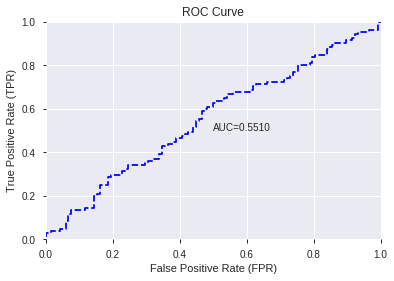

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


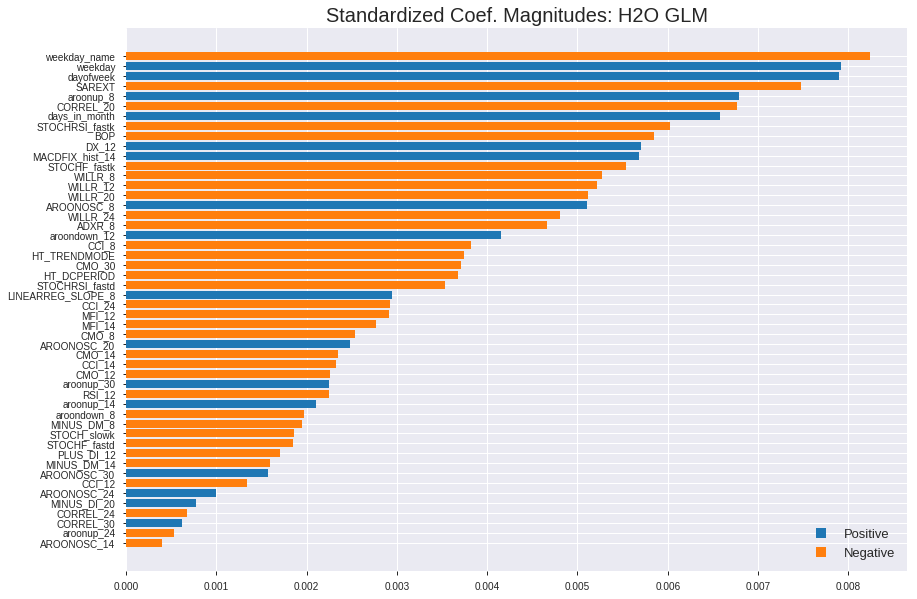

'log_likelihood'
--2019-09-03 02:45:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_024501_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_024501_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['weekday_name',
 'weekday',
 'dayofweek',
 'SAREXT',
 'aroonup_8',
 'CORREL_20',
 'days_in_month',
 'STOCHRSI_fastk',
 'BOP',
 'DX_12',
 'MACDFIX_hist_14',
 'STOCHF_fastk',
 'WILLR_8',
 'WILLR_12',
 'WILLR_20',
 'AROONOSC_8',
 'WILLR_24',
 'ADXR_8',
 'aroondown_12',
 'CCI_8',
 'HT_TRENDMODE',
 'CMO_30',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'LINEARREG_SLOPE_8',
 'CCI_24',
 'MFI_12',
 'MFI_14',
 'CMO_8',
 'AROONOSC_20',
 'CMO_14',
 'CCI_14',
 'CMO_12',
 'aroonup_30',
 'RSI_12',
 'aroonup_14',
 'aroondown_8',
 'MINUS_DM_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'PLUS_DI_12',
 'MINUS_DM_14',
 'AROONOSC_30',
 'CCI_12',
 'AROONOSC_24',
 'MINUS_DI_20',
 'CORREL_24',
 'CORREL_30',
 'aroonup_24',
 'AROONOSC_14']

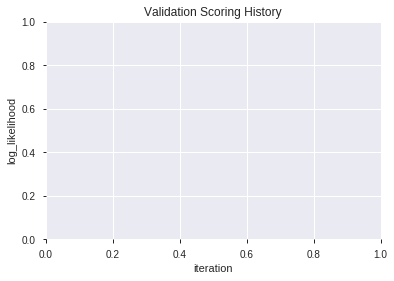

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_024518_model_2  0.602744  0.683050              0.492050  0.494957  0.244982
1  XGBoost_grid_1_AutoML_20190903_024518_model_6  0.588862  0.681453              0.495763  0.494305  0.244338
2  XGBoost_grid_1_AutoML_20190903_024518_model_7  0.583777  0.695674              0.479338  0.500481  0.250481
3               XGBoost_1_AutoML_20190903_024518  0.569734  0.695127              0.495763  0.500839  0.250840
4  XGBoost_grid_1_AutoML_20190903_024518_model_5  0.568765  0.714688              0.495763  0.508792  0.258869
5  XGBoost_grid_1_AutoML_20190903_024518_model_3  0.560129  0.697620              0.487813  0.501936  0.251939
6               XGBoost_2_AutoML_20190903_024518  0.554399  0.697078              0.487813  0.501708  0.251711
7  XGBoost_grid_1_AutoML_20190903_024518_model_1  0.554237  0.697592              0.491525  0.501986  0.251990
8               XGBoost_3_AutoML_20190903_024518  0.550847  0.702969              0.483575  0.504593  0.254614
9  XGBoost_grid_1_AutoML_20190903_024518_model_4  0.536239  0.700149              0.495763  0.503399  0.253411

variable  relative_importance  scaled_importance  percentage
0              SAREXT           331.726257           1.000000    0.066074
1                 BOP           255.746201           0.770956    0.050940
2     MACDFIX_hist_14           191.701508           0.577891    0.038184
3         HT_DCPERIOD           190.400925           0.573970    0.037925
4        STOCHF_fastk           185.910294           0.560433    0.037030
5              ADXR_8           182.372681           0.549769    0.036325
6              MFI_14           175.963272           0.530447    0.035049
7          PLUS_DI_12           167.197128           0.504021    0.033303
8         AROONOSC_30           158.505508           0.477820    0.031572
9          MINUS_DM_8           150.327866           0.453168    0.029943
10           WILLR_20           143.894135           0.433774    0.028661
11        MINUS_DI_20           142.368439           0.429174    0.028357
12              CCI_8           137.523285           0.414569    0.027392
13  LINEARREG_SLOPE_8           133.652298           0.402899    0.026621
14          CORREL_30           130.849869           0.394451    0.026063
15             CMO_30           126.637337           0.381753    0.025224
16        STOCH_slowk           121.556587           0.366436    0.024212
17             MFI_12           121.225838           0.365439    0.024146
18              DX_12           113.349388           0.341696    0.022577
19         aroonup_30           103.955894           0.313379    0.020706
20        MINUS_DM_14            97.186531           0.292972    0.019358
21          CORREL_20            94.772514           0.285695    0.018877
22            WILLR_8            90.914970           0.274066    0.018109
23             CMO_14            89.589630           0.270071    0.017845
24             CMO_12            89.432793           0.269598    0.017813
25          dayofweek            82.726242           0.249381    0.016478
26         AROONOSC_8            82.677361           0.249234    0.016468
27          aroonup_8            82.127708           0.247577    0.016358
28             CCI_14            81.610817           0.246019    0.016255
29     STOCHRSI_fastd            81.186363           0.244739    0.016171
30           WILLR_12            79.405609           0.239371    0.015816
31             CCI_24            72.612808           0.218894    0.014463
32       aroondown_12            71.798889           0.216440    0.014301
33        AROONOSC_20            69.724304           0.210186    0.013888
34        AROONOSC_14            68.643311           0.206928    0.013673
35     STOCHRSI_fastk            68.538635           0.206612    0.013652
36              CMO_8            65.571350           0.197667    0.013061
37             CCI_12            56.821171           0.171289    0.011318
38          CORREL_24            55.963203           0.168703    0.011147
39        AROONOSC_24            50.229298           0.151418    0.010005
40         aroonup_24            45.606873           0.137483    0.009084
41        aroondown_8            41.071041           0.123810    0.008181
42         aroonup_14            38.791473           0.116938    0.007727
43            weekday            25.699169           0.077471    0.005119
44           WILLR_24            25.587280           0.077134    0.005097
45       STOCHF_fastd            21.825270           0.065793    0.004347
46      days_in_month            18.171852           0.054780    0.003620
47       weekday_name             6.222002           0.018756    0.001239
48       HT_TRENDMODE             1.148272           0.003462    0.000229

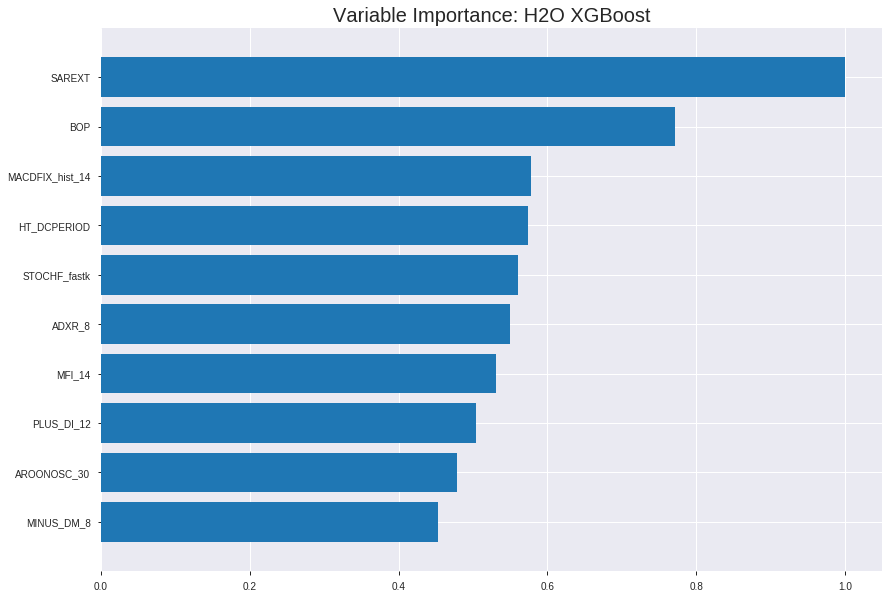

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_024518_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18921957962567035
RMSE: 0.43499376964006087
LogLoss: 0.5684217120042137
Mean Per-Class Error: 0.17143649546348994
AUC: 0.9041654010222006
pr_auc: 0.9013002521930596
Gini: 0.8083308020444011
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.520176370938619: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      617  129  0.1729   (129.0/746.0)
1      138  674  0.17     (138.0/812.0)
Total  755  803  0.1714   (267.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520176     0.834675  201
max f2                       0.439284     0.899638  289
max f0point5                 0.544217     0.850282  174
max accuracy                 0.520176     0.828626  201
max precision                0.750676     1         0
max recall                   0.36576      1         352
max specificity              0.750676     1         0
max absolute_mcc             0.520176     0.656849  201
max min_per_class_accuracy   0.520176     0.827078  201
max mean_per_class_accuracy  0.520176     0.828564  201

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.06 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.726749           1.91872    1.91872            1                0.738898  1                           0.738898            0.0197044       0.0197044                  91.8719   91.8719
    2        0.0205392                   0.713179           1.91872    1.91872            1                0.721156  1                           0.730027            0.0197044       0.0394089                  91.8719   91.8719
    3        0.0301669                   0.701248           1.91872    1.91872            1                0.70604   1                           0.722371            0.0184729       0.0578818                  91.8719   91.8719
    4        0.0404365                   0.692822           1.7988     1.88826            0.9375           0.696824  0.984127                    0.715883            0.0184729       0.0763547                  79.8799   88.8263
    5        0.0500642                   0.682384           1.91872    1.89412            1                0.68777   0.987179                    0.710477            0.0184729       0.0948276                  91.8719   89.412
    6        0.100128                    0.65461            1.79572    1.84492            0.935897         0.667058  0.961538                    0.688767            0.0899015       0.184729                   79.5724   84.4922
    7        0.150193                    0.638005           1.77113    1.82032            0.923077         0.646254  0.948718                    0.674596            0.08867         0.273399                   77.1125   82.0323
    8        0.200257                    0.618391           1.79572    1.81417            0.935897         0.627147  0.945513                    0.662734            0.0899015       0.3633                     79.5724   81.4174
    9        0.300385                    0.585452           1.70963    1.77933            0.891026         0.600929  0.92735                     0.642132            0.171182        0.534483                   70.9628   77.9325
    10       0.399872                    0.553541           1.54735    1.72161            0.806452         0.569313  0.897271                    0.624015            0.153941        0.688424                   54.7354   72.1612
    11       0.5                         0.526              1.20535    1.61823            0.628205         0.540129  0.843389                    0.607216            0.12069         0.809113                   20.5349   61.8227
    12       0.600128                    0.492343           0.860964   1.49188            0.448718         0.508006  0.77754                     0.590664            0.0862069       0.89532                    -13.9036  49.1881
    13       0.699615                    0.454808           0.606563   1.36599            0.316129         0.473505  0.711927                    0.574003            0.0603448       0.955665                   -39.3437  36.5987
    14       0.799743                    0.424248           0.344385   1.23808            0.179487         0.440138  0.645265                    0.557243            0.0344828       0.990148                   -65.5615  23.8082
    15       0.899872                    0.379579           0.0860964  1.1099             0.0448718        0.402524  0.578459                    0.540028            0.00862069      0.998768                   -91.3904  10.9901
    16       1                           0.244324           0.0122995  1                  0.00641026       0.346281  0.521181                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2530244371059787
RMSE: 0.5030153448017055
LogLoss: 0.6997851464770185
Mean Per-Class Error: 0.4448547215496368
AUC: 0.5304882970137208
pr_auc: 0.5416797632116779
Gini: 0.0609765940274416
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3456626236438751: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    204  0.9714   (204.0/210.0)
1      1    235  0.0042   (1.0/236.0)
Total  7    439  0.4596   (205.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345663     0.696296  392
max f2                       0.345663     0.849602  392
max f0point5                 0.471574     0.596515  278
max accuracy                 0.478435     0.565022  266
max precision                0.741086     1         0
max recall                   0.321941     1         398
max specificity              0.741086     1         0
max absolute_mcc             0.478435     0.117319  266
max min_per_class_accuracy   0.507348     0.495238  206
max mean_per_class_accuracy  0.478435     0.555145  266

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.721926           1.1339    1.1339             0.6              0.730689  0.6                         0.730689            0.0127119       0.0127119                  13.3898   13.3898
    2        0.0201794                   0.712888           0.944915  1.04991            0.5              0.716249  0.555556                    0.724271            0.00847458      0.0211864                  -5.50847  4.99058
    3        0.0313901                   0.699038           0.755932  0.944915           0.4              0.70628   0.5                         0.717846            0.00847458      0.029661                   -24.4068  -5.50847
    4        0.0403587                   0.687419           0.944915  0.944915           0.5              0.692038  0.5                         0.712111            0.00847458      0.0381356                  -5.50847  -5.50847
    5        0.0515695                   0.679935           0.755932  0.903832           0.4              0.683769  0.478261                    0.70595             0.00847458      0.0466102                  -24.4068  -9.6168
    6        0.100897                    0.644803           1.03082   0.965913           0.545455         0.659943  0.511111                    0.683457            0.0508475       0.0974576                  3.08166   -3.40866
    7        0.150224                    0.624647           0.859014  0.930812           0.454545         0.633978  0.492537                    0.66721             0.0423729       0.139831                   -14.0986  -6.9188
    8        0.201794                    0.605183           1.39683   1.04991            0.73913          0.613032  0.555556                    0.653365            0.0720339       0.211864                   39.6831   4.99058
    9        0.300448                    0.565156           0.987866  1.02953            0.522727         0.586548  0.544776                    0.631425            0.0974576       0.309322                   -1.21341  2.95345
    10       0.401345                    0.533723           1.0919    1.04521            0.577778         0.549503  0.553073                    0.61083             0.110169        0.419492                   9.19021   4.52135
    11       0.5                         0.507143           0.773112  0.991525           0.409091         0.519069  0.524664                    0.592725            0.0762712       0.495763                   -22.6888  -0.847458
    12       0.600897                    0.491414           1.51186   1.0789             0.8              0.498025  0.570896                    0.576823            0.152542        0.648305                   51.1864   7.88958
    13       0.699552                    0.472453           1.03082   1.07212            0.545455         0.48266   0.567308                    0.563544            0.101695        0.75                       3.08166   7.21154
    14       0.800448                    0.443021           0.713936  1.02697            0.377778         0.458723  0.543417                    0.550331            0.0720339       0.822034                   -28.6064  2.69667
    15       0.899103                    0.410518           0.901965  1.01325            0.477273         0.429691  0.53616                     0.537094            0.0889831       0.911017                   -9.80354  1.32508
    16       1                           0.321542           0.881921  1                  0.466667         0.377542  0.529148                    0.520996    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:45:23  0.966 sec   0                  0.5              0.693147            0.5             0                  1                0.478819                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 02:45:23  1.097 sec   5                  0.490214         0.673741            0.765636        0.696678           1.75331          0.297176                         0.500512           0.694174              0.496651          0.497343             0.903832           0.470852
    2019-09-03 02:45:23  1.170 sec   10                 0.482762         0.659151            0.803755        0.774834           1.80585          0.274069                         0.500246           0.69365               0.511996          0.522355             0.377966           0.459641
    2019-09-03 02:45:23  1.240 sec   15                 0.475174         0.644416            0.819471        0.803182           1.91872          0.252246                         0.501122           0.695453              0.510038          0.521067             0.377966           0.46861
    2019-09-03 02:45:23  1.312 sec   20                 0.468214         0.631025            0.841022        0.834679           1.91872          0.233633                         0.500277           0.693779              0.526604          0.534179             0.755932           0.461883
    2019-09-03 02:45:24  1.392 sec   25                 0.461923         0.618996            0.853906        0.848196           1.91872          0.223363                         0.49971            0.692676              0.539447          0.545244             0.755932           0.459641
    2019-09-03 02:45:24  1.480 sec   30                 0.456451         0.608574            0.865313        0.857935           1.91872          0.227856                         0.500054           0.693426              0.538519          0.546711             0.755932           0.452915
    2019-09-03 02:45:24  1.555 sec   35                 0.450495         0.597321            0.876378        0.871958           1.91872          0.220154                         0.500708           0.694847              0.538882          0.545086             0.755932           0.452915
    2019-09-03 02:45:24  1.653 sec   40                 0.445368         0.587701            0.885516        0.883778           1.91872          0.202824                         0.501276           0.696012              0.535825          0.545311             1.1339             0.459641
    2019-09-03 02:45:24  1.729 sec   45                 0.440362         0.578384            0.896172        0.894918           1.91872          0.191271                         0.501869           0.697289              0.534151          0.543792             1.1339             0.457399
    2019-09-03 02:45:24  1.811 sec   50                 0.434994         0.568422            0.904165        0.9013             1.91872          0.171374                         0.503015           0.699785              0.530488          0.54168              1.1339             0.459641

Variable Importances: 


variable         relative_importance    scaled_importance      percentage
---------------  ---------------------  ---------------------  ----------------------
SAREXT           331.72625732421875     1.0                    0.06607406436313346
BOP              255.74620056152344     0.7709555542103657     0.05094016691001092
MACDFIX_hist_14  191.70150756835938     0.5778906653777376     0.03818358501902265
HT_DCPERIOD      190.4009246826172      0.5739700143679773     0.03792453167185837
STOCHF_fastk     185.91029357910156     0.5604328553268508     0.037030076554081
---              ---                    ---                    ---
WILLR_24         25.5872802734375       0.07713372007338358    0.005096538384696666
STOCHF_fastd     21.82526969909668      0.0657930122117688     0.0043472117235248365
days_in_month    18.171852111816406     0.054779661575163806   0.003619514884708042
weekday_name     6.222001552581787      0.018756433701600534   0.0012393138076223992
HT_TRENDMODE     1.1482723951339722     0.0034615058946379606  0.00022871576327567446


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6143497757847534)

('F1', 0.6419753086419753)

('auc', 0.6027441485068604)

('logloss', 0.6830498896547746)

('mean_per_class_error', 0.39430992736077486)

('rmse', 0.49495656496374113)

('mse', 0.2449820012007061)

xgboost prediction progress: |████████████████████████████████████████████| 100%


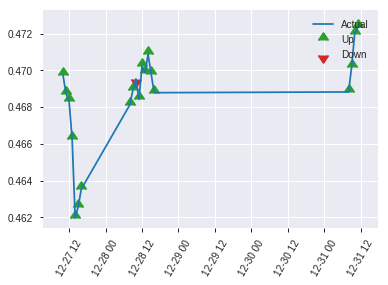


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2449820012007061
RMSE: 0.49495656496374113
LogLoss: 0.6830498896547746
Mean Per-Class Error: 0.39430992736077486
AUC: 0.6027441485068604
pr_auc: 0.5741208337069186
Gini: 0.20548829701372084
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34690287709236145: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    115  0.9746   (115.0/118.0)
1      1    104  0.0095   (1.0/105.0)
Total  4    219  0.5202   (116.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346903     0.641975  218
max f2                       0.307405     0.816485  222
max f0point5                 0.529918     0.582878  110
max accuracy                 0.567948     0.61435   76
max precision                0.712913     1         0
max recall                   0.307405     1         222
max specificity              0.712913     1         0
max absolute_mcc             0.567948     0.221911  76
max min_per_class_accuracy   0.529918     0.601695  110
max mean_per_class_accuracy  0.567948     0.60569   76

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.704453           1.41587   1.41587            0.666667         0.709664  0.666667                    0.709664            0.0190476       0.0190476                  41.5873   41.5873
    2        0.0224215                   0.692741           1.0619    1.27429            0.5              0.699196  0.6                         0.705477            0.00952381      0.0285714                  6.19048   27.4286
    3        0.0313901                   0.677648           2.12381   1.51701            1                0.683617  0.714286                    0.699231            0.0190476       0.047619                   112.381   51.7007
    4        0.0403587                   0.671761           2.12381   1.65185            1                0.67603   0.777778                    0.694075            0.0190476       0.0666667                  112.381   65.1852
    5        0.0538117                   0.66911            1.41587   1.59286            0.666667         0.670386  0.75                        0.688153            0.0190476       0.0857143                  41.5873   59.2857
    6        0.103139                    0.64098            1.35152   1.47743            0.636364         0.649994  0.695652                    0.669903            0.0666667       0.152381                   35.1515   47.7433
    7        0.152466                    0.608799           0.772294  1.2493             0.363636         0.621569  0.588235                    0.654266            0.0380952       0.190476                   -22.7706  24.93
    8        0.201794                    0.596862           1.54459   1.32148            0.727273         0.601574  0.622222                    0.641386            0.0761905       0.266667                   54.4589   32.1481
    9        0.300448                    0.574752           1.25498   1.29964            0.590909         0.586853  0.61194                     0.623479            0.12381         0.390476                   25.4978   29.9645
    10       0.399103                    0.548057           0.868831  1.19315            0.409091         0.563377  0.561798                    0.608623            0.0857143       0.47619                    -13.1169  19.3151
    11       0.502242                    0.529726           1.29275   1.21361            0.608696         0.538508  0.571429                    0.594224            0.133333        0.609524                   29.2754   21.3605
    12       0.600897                    0.496605           0.482684  1.0936             0.227273         0.512391  0.514925                    0.580789            0.047619        0.657143                   -51.7316  9.36034
    13       0.699552                    0.478588           0.965368  1.07552            0.454545         0.486589  0.50641                     0.567504            0.0952381       0.752381                   -3.4632   7.55189
    14       0.798206                    0.45059            0.868831  1.04997            0.409091         0.462502  0.494382                    0.554526            0.0857143       0.838095                   -13.1169  4.99732
    15       0.896861                    0.412541           0.579221  0.99819            0.272727         0.43215   0.47                        0.541065            0.0571429       0.895238                   -42.0779  -0.180952
    16       1                           0.307405           1.01573   1                  0.478261         0.372108  0.470852                    0.523639         

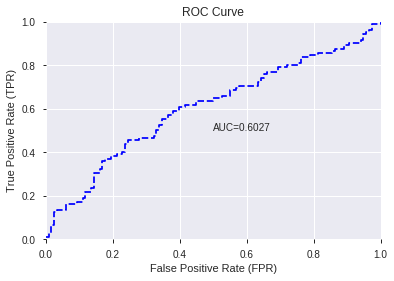

This function is available for GLM models only


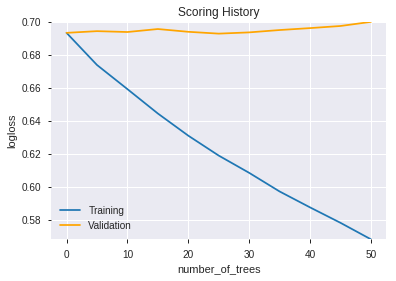

--2019-09-03 02:45:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_024518_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_024518_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SAREXT',
 'BOP',
 'MACDFIX_hist_14',
 'HT_DCPERIOD',
 'STOCHF_fastk',
 'ADXR_8',
 'MFI_14',
 'PLUS_DI_12',
 'AROONOSC_30',
 'MINUS_DM_8',
 'WILLR_20',
 'MINUS_DI_20',
 'CCI_8',
 'LINEARREG_SLOPE_8',
 'CORREL_30',
 'CMO_30',
 'STOCH_slowk',
 'MFI_12',
 'DX_12',
 'aroonup_30',
 'MINUS_DM_14',
 'CORREL_20',
 'WILLR_8',
 'CMO_14',
 'CMO_12',
 'dayofweek',
 'AROONOSC_8',
 'aroonup_8',
 'CCI_14',
 'STOCHRSI_fastd',
 'WILLR_12',
 'CCI_24',
 'aroondown_12',
 'AROONOSC_20',
 'AROONOSC_14',
 'STOCHRSI_fastk',
 'CMO_8',
 'CCI_12',
 'CORREL_24',
 'AROONOSC_24',
 'aroonup_24',
 'aroondown_8',
 'aroonup_14',
 'weekday',
 'WILLR_24',
 'STOCHF_fastd',
 'days_in_month',
 'weekday_name',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_024546_model_1  0.570541  0.69417              0.487288  0.500517  0.250517

variable  relative_importance  scaled_importance  percentage
0                 weekday_name             0.008311           1.000000    0.009929
1           CDLCLOSINGMARUBOZU             0.007942           0.955551    0.009488
2                    dayofweek             0.007758           0.933461    0.009268
3                      weekday             0.007755           0.933099    0.009265
4                       SAREXT             0.007671           0.923017    0.009165
...                        ...                  ...                ...         ...
1033   BBANDS_middleband_8_1_3             0.000004           0.000511    0.000005
1034                 MAVP_24_3             0.000004           0.000510    0.000005
1035   BBANDS_upperband_12_7_2             0.000004           0.000471    0.000005
1036                       EXP             0.000004           0.000448    0.000004
1037  BBANDS_middleband_24_1_2             0.000002           0.000285    0.000003

[1038 rows x 4 columns]

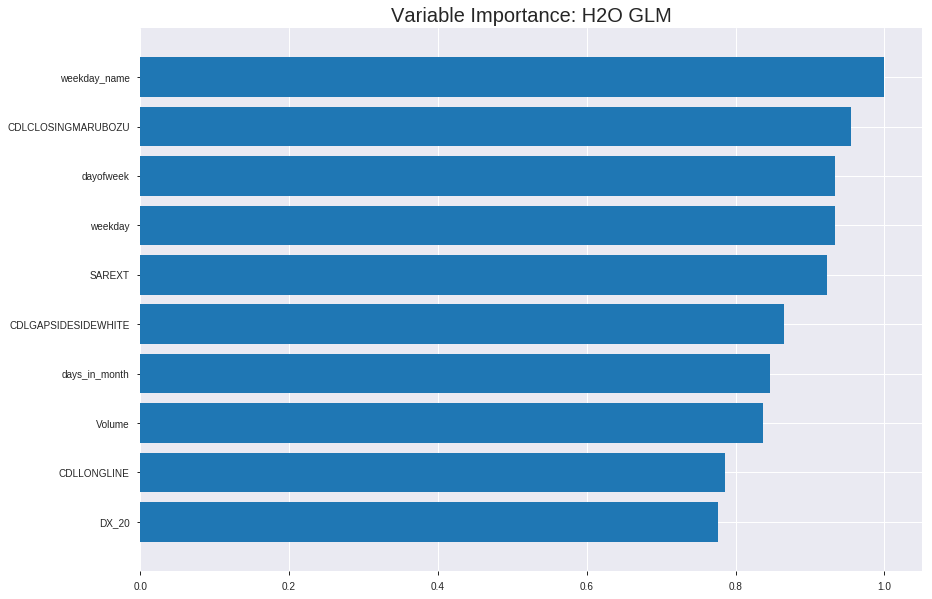

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_024546_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2455030848851611
RMSE: 0.4954826786933738
LogLoss: 0.6841201541166592
Null degrees of freedom: 1557
Residual degrees of freedom: 519
Null deviance: 2157.0498856314666
Residual deviance: 2131.71840022751
AIC: 4209.71840022751
AUC: 0.6143570305999815
pr_auc: 0.6209187416037079
Gini: 0.22871406119996296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47632994370423504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      30   716   0.9598   (716.0/746.0)
1      14   798   0.0172   (14.0/812.0)
Total  44   1514  0.4685   (730.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47633      0.686156  368
max f2                       0.452883     0.845305  396
max f0point5                 0.518996     0.608173  212
max accuracy                 0.523367     0.591784  191
max precision                0.604235     1         0
max recall                   0.452883     1         396
max specificity              0.604235     1         0
max absolute_mcc             0.528941     0.19548   168
max min_per_class_accuracy   0.521129     0.58867   202
max mean_per_class_accuracy  0.528667     0.594689  169

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.576104           1.7988    1.7988             0.9375           0.587497  0.9375                      0.587497            0.0184729       0.0184729                  79.8799   79.8799
    2        0.0205392                   0.569938           1.31912   1.55896            0.6875           0.572736  0.8125                      0.580117            0.0135468       0.0320197                  31.9119   55.8959
    3        0.0301669                   0.567074           1.15123   1.42883            0.6              0.568156  0.744681                    0.576299            0.0110837       0.0431034                  15.1232   42.8833
    4        0.0404365                   0.564877           0.95936   1.3096             0.5              0.566244  0.68254                     0.573746            0.00985222      0.0529557                  -4.06404  30.9602
    5        0.0500642                   0.561416           1.02332   1.25455            0.533333         0.563306  0.653846                    0.571738            0.00985222      0.0628079                  2.33169   25.4547
    6        0.100128                    0.550816           1.25455   1.25455            0.653846         0.554928  0.653846                    0.563333            0.0628079       0.125616                   25.4547   25.4547
    7        0.150193                    0.545138           1.30375   1.27095            0.679487         0.547775  0.662393                    0.558147            0.0652709       0.190887                   30.3745   27.0946
    8        0.200257                    0.540384           1.20535   1.25455            0.628205         0.542747  0.653846                    0.554297            0.0603448       0.251232                   20.5349   25.4547
    9        0.300385                    0.532921           1.10695   1.20535            0.576923         0.536507  0.628205                    0.548367            0.110837        0.362069                   10.6953   20.5349
    10       0.399872                    0.527115           1.27502   1.22268            0.664516         0.529962  0.637239                    0.543788            0.126847        0.488916                   27.502    22.2683
    11       0.5                         0.521267           0.971659  1.17241            0.50641          0.524118  0.61104                     0.539849            0.0972906       0.586207                   -2.83409  17.2414
    12       0.600128                    0.515407           0.934761  1.13276            0.487179         0.518248  0.590374                    0.536245            0.0935961       0.679803                   -6.52394  13.2763
    13       0.699615                    0.508752           0.866518  1.0949             0.451613         0.512147  0.570642                    0.532818            0.0862069       0.76601                    -13.3482  9.49022
    14       0.799743                    0.50241            0.897862  1.07023            0.467949         0.505846  0.557785                    0.529441            0.0899015       0.855911                   -10.2138  7.02326
    15       0.899872                    0.491389           0.71337   1.03052            0.371795         0.497185  0.53709                     0.525852            0.0714286       0.92734                    -28.663   3.05247
    16       1                           0.439865           0.725669  1                  0.378205         0.479201  0.521181                    0.521181         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.250013350085328
RMSE: 0.500013349907108
LogLoss: 0.6932009037721395
Null degrees of freedom: 445
Residual degrees of freedom: -593
Null deviance: 616.8842253342874
Residual deviance: 618.3352061647485
AIC: 2696.3352061647483
AUC: 0.5104015334947538
pr_auc: 0.5123528401644676
Gini: 0.020803066989507624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.469045033540124: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    208  0.9905   (208.0/210.0)
1      1    235  0.0042   (1.0/236.0)
Total  3    443  0.4686   (209.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469045     0.692194  396
max f2                       0.447036     0.848921  399
max f0point5                 0.499503     0.589474  369
max accuracy                 0.520933     0.55157   243
max precision                0.596887     1         0
max recall                   0.447036     1         399
max specificity              0.596887     1         0
max absolute_mcc             0.570119     0.117192  16
max min_per_class_accuracy   0.52498      0.514286  204
max mean_per_class_accuracy  0.520933     0.545319  243

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.583799           0.755932  0.755932           0.4              0.587187  0.4                         0.587187            0.00847458      0.00847458                 -24.4068  -24.4068
    2        0.0201794                   0.577384           0.472458  0.629944           0.25             0.581647  0.333333                    0.584725            0.00423729      0.0127119                  -52.7542  -37.0056
    3        0.0313901                   0.574102           0.377966  0.539952           0.2              0.575576  0.285714                    0.581458            0.00423729      0.0169492                  -62.2034  -46.0048
    4        0.0403587                   0.56923            0.472458  0.524953           0.25             0.570857  0.277778                    0.579102            0.00423729      0.0211864                  -52.7542  -47.5047
    5        0.0515695                   0.567463           0.755932  0.575166           0.4              0.568615  0.304348                    0.576822            0.00847458      0.029661                   -24.4068  -42.4834
    6        0.100897                    0.556078           1.03082   0.797928           0.545455         0.561011  0.422222                    0.569092            0.0508475       0.0805085                  3.08166   -20.2072
    7        0.150224                    0.547885           0.687211  0.761573           0.363636         0.551879  0.402985                    0.56344             0.0338983       0.114407                   -31.2789  -23.8427
    8        0.201794                    0.542098           1.39683   0.923917           0.73913          0.544724  0.488889                    0.558657            0.0720339       0.186441                   39.6831   -7.60829
    9        0.300448                    0.535033           1.24557   1.02953            0.659091         0.538102  0.544776                    0.551908            0.122881        0.309322                   24.557    2.95345
    10       0.401345                    0.53067            0.881921  0.992425           0.466667         0.532516  0.52514                     0.547033            0.0889831       0.398305                   -11.8079  -0.757504
    11       0.5                         0.525194           1.15967   1.02542            0.613636         0.528367  0.542601                    0.54335             0.114407        0.512712                   15.9669   2.54237
    12       0.600897                    0.521264           1.25989   1.06479            0.666667         0.523082  0.563433                    0.539947            0.127119        0.639831                   25.9887   6.47926
    13       0.699552                    0.517123           0.730162  1.0176             0.386364         0.519416  0.538462                    0.537051            0.0720339       0.711864                   -26.9838  1.7601
    14       0.800448                    0.511691           1.04991   1.02167            0.555556         0.514579  0.540616                    0.534219            0.105932        0.817797                   4.99058   2.16731
    15       0.899103                    0.502743           0.859014  1.00383            0.454545         0.507682  0.531172                    0.531307            0.0847458       0.902542                   -14.0986  0.382518
    16       1                           0.447036           0.965913  1                  0.511111         0.491132  0.529148                    0.52725


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:45:49  0.000 sec   2            2.9       1039          1.36824           1.3864
    2019-09-03 02:45:51  1.961 sec   4            2.1       1039          1.36417           1.38734
    2019-09-03 02:45:53  3.919 sec   6            1.5       1039          1.35953           1.38871
    2019-09-03 02:45:55  5.905 sec   8            1.1       1039          1.35425           1.39053
    2019-09-03 02:45:57  7.866 sec   10           0.81      1039          1.34832           1.39259

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5919282511210763)

('F1', 0.6461538461538462)

('auc', 0.5705407586763519)

('logloss', 0.6941699863167469)

('mean_per_class_error', 0.4081517352703794)

('rmse', 0.5005168134891901)

('mse', 0.2505170805853727)

glm prediction progress: |████████████████████████████████████████████████| 100%


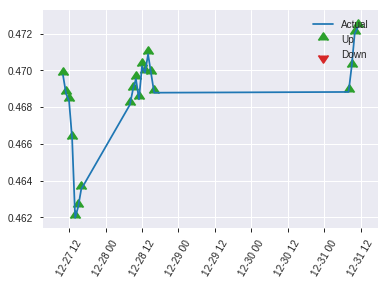


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2505170805853727
RMSE: 0.5005168134891901
LogLoss: 0.6941699863167469
Null degrees of freedom: 222
Residual degrees of freedom: -816
Null deviance: 310.6462559060497
Residual deviance: 309.5998138972691
AIC: 2387.599813897269
AUC: 0.5705407586763519
pr_auc: 0.52901994785498
Gini: 0.1410815173527038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48652464660249045: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    115  0.9746   (115.0/118.0)
1      0    105  0        (0.0/105.0)
Total  3    220  0.5157   (115.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486525     0.646154  219
max f2                       0.486525     0.820313  219
max f0point5                 0.529963     0.568807  109
max accuracy                 0.530302     0.591928  107
max precision                0.603482     1         0
max recall                   0.486525     1         219
max specificity              0.603482     1         0
max absolute_mcc             0.529963     0.183401  109
max min_per_class_accuracy   0.529963     0.590476  109
max mean_per_class_accuracy  0.529963     0.591848  109

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 53.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.58555            2.12381   2.12381            1                0.593339  1                           0.593339            0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.576628           1.0619    1.69905            0.5              0.582168  0.8                         0.58887             0.00952381      0.0380952                  6.19048   69.9048
    3        0.0313901                   0.571451           0         1.21361            0                0.572379  0.571429                    0.584159            0               0.0380952                  -100      21.3605
    4        0.0403587                   0.569602           2.12381   1.41587            1                0.570895  0.666667                    0.581211            0.0190476       0.0571429                  112.381   41.5873
    5        0.0538117                   0.569053           0.707937  1.23889            0.333333         0.569283  0.583333                    0.578229            0.00952381      0.0666667                  -29.2063  23.8889
    6        0.103139                    0.559369           0.965368  1.10807            0.454545         0.563541  0.521739                    0.571205            0.047619        0.114286                   -3.4632   10.8075
    7        0.152466                    0.554206           0.965368  1.0619             0.454545         0.556693  0.5                         0.56651             0.047619        0.161905                   -3.4632   6.19048
    8        0.201794                    0.54834            1.15844   1.0855             0.545455         0.551157  0.511111                    0.562757            0.0571429       0.219048                   15.8442   8.55026
    9        0.300448                    0.540788           1.25498   1.14115            0.590909         0.543896  0.537313                    0.556564            0.12381         0.342857                   25.4978   14.1151
    10       0.399103                    0.533462           1.35152   1.19315            0.636364         0.537022  0.561798                    0.551733            0.133333        0.47619                    35.1515   19.3151
    11       0.502242                    0.529642           1.10807   1.17568            0.521739         0.531629  0.553571                    0.547605            0.114286        0.590476                   10.8075   17.568
    12       0.600897                    0.525185           0.579221  1.07775            0.272727         0.527064  0.507463                    0.544232            0.0571429       0.647619                   -42.0779  7.77541
    13       0.699552                    0.521189           0.965368  1.0619             0.454545         0.522903  0.5                         0.541224            0.0952381       0.742857                   -3.4632   6.19048
    14       0.798206                    0.513872           0.868831  1.03804            0.409091         0.517878  0.488764                    0.538339            0.0857143       0.828571                   -13.1169  3.80417
    15       0.896861                    0.505557           0.675758  0.99819            0.318182         0.509838  0.47                        0.535204            0.0666667       0.895238                   -32.4242  -0.180952
    16       1                           0.437474           1.01573   1                  0.478261         0.494004  0.470852                    0.530954        

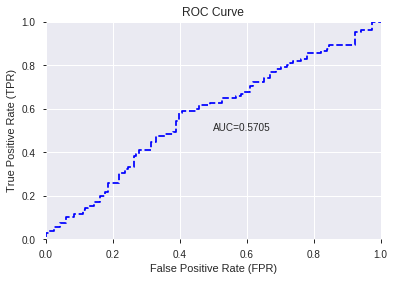

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


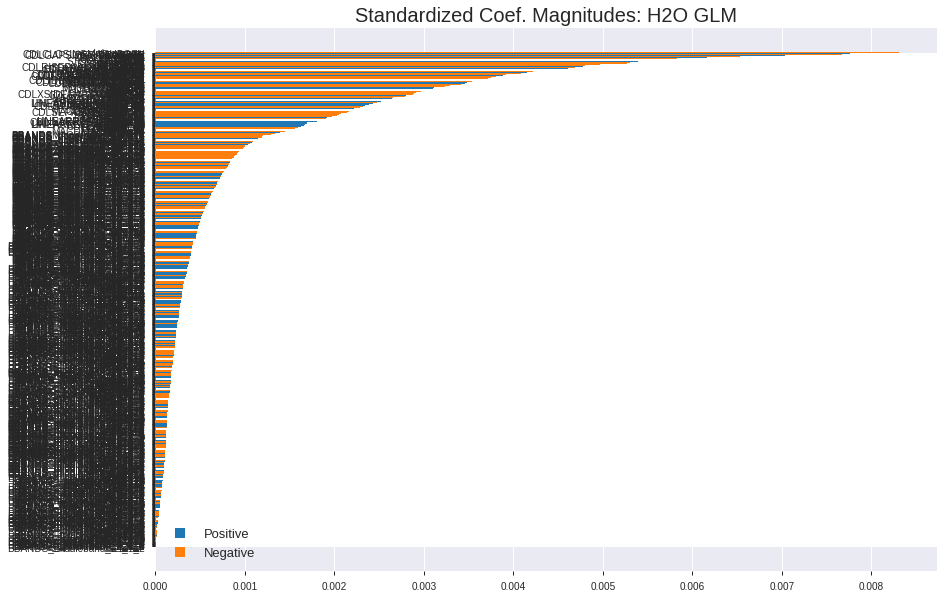

'log_likelihood'
--2019-09-03 02:46:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_024546_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_024546_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

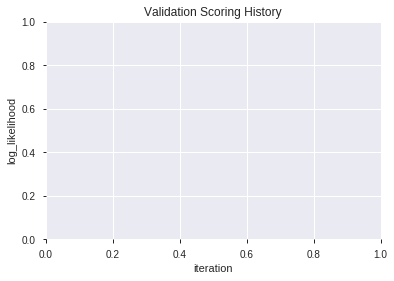

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_024631_model_3  0.575303  0.689193              0.458676  0.497995  0.247999
1               XGBoost_3_AutoML_20190903_024631  0.574576  0.689344              0.478814  0.498176  0.248179
2  XGBoost_grid_1_AutoML_20190903_024631_model_6  0.569734  0.695224              0.483051  0.500934  0.250935
3  XGBoost_grid_1_AutoML_20190903_024631_model_4  0.566828  0.691674              0.441162  0.499333  0.249334
4               XGBoost_1_AutoML_20190903_024631  0.563761  0.700105              0.468725  0.503205  0.253216
5  XGBoost_grid_1_AutoML_20190903_024631_model_2  0.563196  0.692188              0.474576  0.499481  0.249481
6               XGBoost_2_AutoML_20190903_024631  0.550282  0.695649              0.459201  0.501227  0.251228
7  XGBoost_grid_1_AutoML_20190903_024631_model_5  0.532526  0.742502              0.500000  0.520887  0.271323
8  XGBoost_grid_1_AutoML_20190903_024631_model_1  0.530508  0.707771              0.500000  0.506897  0.256944
9  XGBoost_grid_1_AutoML_20190903_024631_model_7  0.515900  0.727315              0.453349  0.515390  0.265626

variable  relative_importance  scaled_importance  percentage
0                        BOP           141.307571           1.000000    0.024702
1                     Volume           131.512375           0.930682    0.022990
2                     SAREXT           103.155846           0.730009    0.018033
3                   WILLR_20            79.953415           0.565811    0.013977
4                        SUB            78.274620           0.553931    0.013683
..                       ...                  ...                ...         ...
317  BBANDS_upperband_12_2_5             1.271791           0.009000    0.000222
318  BBANDS_lowerband_20_0_2             1.251093           0.008854    0.000219
319                    month             1.013970           0.007176    0.000177
320  BBANDS_upperband_12_7_4             0.806561           0.005708    0.000141
321  BBANDS_upperband_20_1_3             0.085930           0.000608    0.000015

[322 rows x 4 columns]

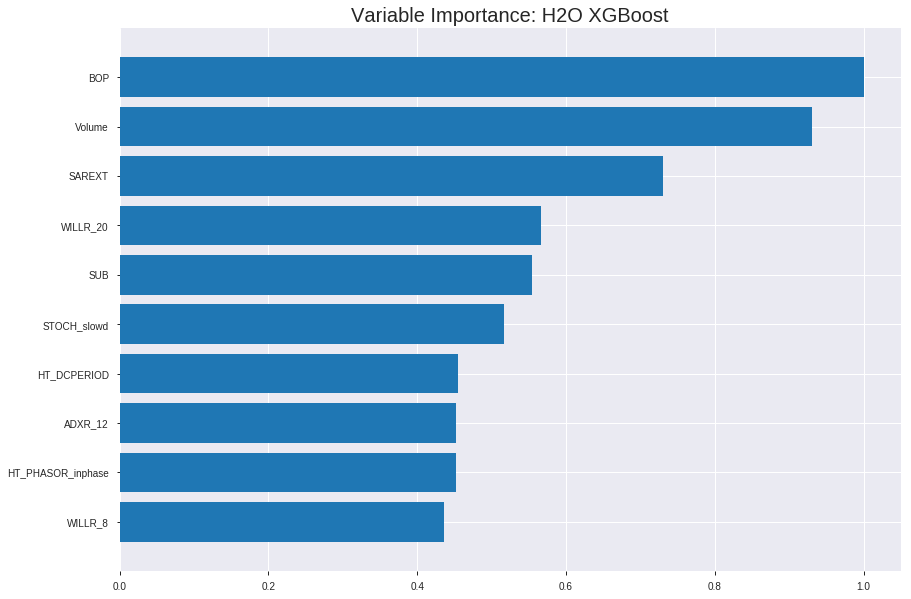

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_024631_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17004387134643834
RMSE: 0.41236376095195165
LogLoss: 0.5272486387723216
Mean Per-Class Error: 0.13206064528057682
AUC: 0.9402841426854555
pr_auc: 0.9410355217226521
Gini: 0.8805682853709109
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.518646776676178: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      639  107  0.1434   (107.0/746.0)
1      98   714  0.1207   (98.0/812.0)
Total  737  821  0.1316   (205.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518647     0.874464  195
max f2                       0.455948     0.91727   244
max f0point5                 0.560287     0.886814  157
max accuracy                 0.518647     0.868421  195
max precision                0.787585     1         0
max recall                   0.360416     1         324
max specificity              0.787585     1         0
max absolute_mcc             0.518647     0.736289  195
max min_per_class_accuracy   0.521498     0.864611  192
max mean_per_class_accuracy  0.518647     0.867939  195

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.05 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.755118           1.91872    1.91872            1                0.769847  1                           0.769847            0.0197044       0.0197044                  91.8719   91.8719
    2        0.0205392                   0.743987           1.91872    1.91872            1                0.748491  1                           0.759169            0.0197044       0.0394089                  91.8719   91.8719
    3        0.0301669                   0.731844           1.91872    1.91872            1                0.735709  1                           0.751682            0.0184729       0.0578818                  91.8719   91.8719
    4        0.0404365                   0.722386           1.91872    1.91872            1                0.726743  1                           0.745348            0.0197044       0.0775862                  91.8719   91.8719
    5        0.0500642                   0.715613           1.7908     1.89412            0.933333         0.718724  0.987179                    0.740228            0.0172414       0.0948276                  79.0805   89.412
    6        0.100128                    0.686376           1.89412    1.89412            0.987179         0.700397  0.987179                    0.720312            0.0948276       0.189655                   89.412    89.412
    7        0.150193                    0.66344            1.86952    1.88592            0.974359         0.674613  0.982906                    0.705079            0.0935961       0.283251                   86.9521   88.5921
    8        0.200257                    0.644125           1.84492    1.87567            0.961538         0.653234  0.977564                    0.692118            0.0923645       0.375616                   84.4922   87.5671
    9        0.300385                    0.604176           1.82032    1.85722            0.948718         0.624959  0.967949                    0.669732            0.182266        0.557882                   82.0323   85.7222
    10       0.399872                    0.567665           1.60925    1.79553            0.83871          0.586677  0.935795                    0.649068            0.160099        0.71798                    60.9248   79.5527
    11       0.5                         0.526527           1.29145    1.69458            0.673077         0.546548  0.883184                    0.628538            0.12931         0.847291                   29.1446   69.4581
    12       0.600128                    0.485951           0.873263   1.55755            0.455128         0.50797   0.811765                    0.608421            0.0874384       0.934729                   -12.6737  55.7549
    13       0.699615                    0.442535           0.433259   1.39767            0.225806         0.462616  0.72844                     0.587688            0.0431034       0.977833                   -56.6741  39.7673
    14       0.799743                    0.399192           0.159893   1.2427             0.0833333        0.420656  0.647673                    0.566775            0.0160099       0.993842                   -84.0107  24.2702
    15       0.899872                    0.348779           0.0614974  1.11127            0.0320513        0.375251  0.579173                    0.545464            0.00615764      1                          -93.8503  11.127
    16       1                           0.155504           0          1                  0                0.296493  0.521181                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2523543724377439
RMSE: 0.5023488553164462
LogLoss: 0.6983260066460238
Mean Per-Class Error: 0.4612792574656982
AUC: 0.528591606133979
pr_auc: 0.5382591293005684
Gini: 0.05718321226795808
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3680928349494934: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   196  0.9333   (196.0/210.0)
1      6    230  0.0254   (6.0/236.0)
Total  20   426  0.4529   (202.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368093     0.694864  382
max f2                       0.282952     0.849532  398
max f0point5                 0.400334     0.595366  362
max accuracy                 0.401965     0.553812  361
max precision                0.750236     1         0
max recall                   0.282952     1         398
max specificity              0.750236     1         0
max absolute_mcc             0.400334     0.104089  362
max min_per_class_accuracy   0.525921     0.521186  202
max mean_per_class_accuracy  0.48665      0.538721  260

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.713456           1.51186   1.51186            0.8              0.726682  0.8                         0.726682            0.0169492       0.0169492                  51.1864   51.1864
    2        0.0201794                   0.688819           0.472458  1.04991            0.25             0.699643  0.555556                    0.714665            0.00423729      0.0211864                  -52.7542  4.99058
    3        0.0313901                   0.683406           0.755932  0.944915           0.4              0.685353  0.5                         0.704196            0.00847458      0.029661                   -24.4068  -5.50847
    4        0.0403587                   0.67106            0.472458  0.839925           0.25             0.679195  0.444444                    0.69864             0.00423729      0.0338983                  -52.7542  -16.0075
    5        0.0515695                   0.666913           1.1339    0.903832           0.6              0.668908  0.478261                    0.692177            0.0127119       0.0466102                  13.3898   -9.6168
    6        0.100897                    0.638032           0.773112  0.839925           0.409091         0.654227  0.444444                    0.673624            0.0381356       0.0847458                  -22.6888  -16.0075
    7        0.150224                    0.620803           1.20262   0.959018           0.636364         0.628115  0.507463                    0.658681            0.059322        0.144068                   20.2619   -4.09815
    8        0.201794                    0.60378            1.2325    1.02891            0.652174         0.612745  0.544444                    0.646942            0.0635593       0.207627                   23.2498   2.89077
    9        0.300448                    0.574936           1.07377   1.04364            0.568182         0.588453  0.552239                    0.627736            0.105932        0.313559                   7.37673   4.36377
    10       0.401345                    0.547624           1.04991   1.04521            0.555556         0.56185   0.553073                    0.611173            0.105932        0.419492                   4.99058   4.52135
    11       0.5                         0.525555           1.03082   1.04237            0.545455         0.537107  0.55157                     0.596559            0.101695        0.521186                   3.08166   4.23729
    12       0.600897                    0.499405           0.965913  1.02953            0.511111         0.511506  0.544776                    0.582278            0.0974576       0.618644                   -3.40866  2.95345
    13       0.699552                    0.468103           1.07377   1.03577            0.568182         0.484445  0.548077                    0.568481            0.105932        0.724576                   7.37673   3.57725
    14       0.800448                    0.447846           0.881921  1.01638            0.466667         0.458284  0.537815                    0.55459             0.0889831       0.813559                   -11.8079  1.63794
    15       0.899103                    0.403765           1.11672   1.02739            0.590909         0.427323  0.543641                    0.540626            0.110169        0.923729                   11.6718   2.73892
    16       1                           0.268664           0.755932  1                  0.4              0.365254  0.529148                    0.522931     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:46:54  6.959 sec   0                  0.5              0.693147            0.5             0                  1                0.478819                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 02:46:55  8.141 sec   5                  0.488153         0.669676            0.759449        0.759949           1.91872          0.322208                         0.499185           0.691521              0.527815          0.532182             0.377966           0.459641
    2019-09-03 02:46:55  8.488 sec   10                 0.476553         0.647055            0.81191         0.810264           1.7988           0.292683                         0.498479           0.690106              0.53637           0.535459             0.755932           0.461883
    2019-09-03 02:46:56  8.829 sec   15                 0.468273         0.631109            0.84575         0.844893           1.91872          0.238768                         0.498131           0.689387              0.537389          0.55105              1.51186            0.457399
    2019-09-03 02:46:56  9.179 sec   20                 0.458857         0.613138            0.868387        0.865722           1.7988           0.208601                         0.49913            0.691449              0.535412          0.544084             0.755932           0.464126
    2019-09-03 02:46:56  9.530 sec   25                 0.450531         0.59751             0.890194        0.890075           1.7988           0.188703                         0.499413           0.69204               0.530579          0.538429             1.1339             0.446188
    2019-09-03 02:46:57  9.884 sec   30                 0.440907         0.57944             0.902491        0.902939           1.91872          0.182927                         0.499012           0.691322              0.54096           0.542174             0.755932           0.443946
    2019-09-03 02:46:57  10.265 sec  35                 0.43343          0.565473            0.911617        0.914864           1.91872          0.174583                         0.499036           0.69129               0.53637           0.548421             1.51186            0.43722
    2019-09-03 02:46:58  10.648 sec  40                 0.426275         0.55233             0.921834        0.924764           1.91872          0.152118                         0.501352           0.696153              0.530831          0.538372             1.1339             0.441704
    2019-09-03 02:46:58  11.015 sec  45                 0.418074         0.537542            0.932728        0.933206           1.91872          0.141849                         0.50226            0.698192              0.526079          0.531233             1.1339             0.446188
    2019-09-03 02:46:58  11.388 sec  50                 0.412364         0.527249            0.940284        0.941036           1.91872          0.131579                         0.502349           0.698326              0.528592          0.538259             1.51186            0.452915

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      141.3075714111328      1.0                    0.024701903576329905
Volume                   131.5123748779297      0.9306817289732897     0.022989610329350204
SAREXT                   103.15584564208984     0.7300093307948734     0.018032620099116083
WILLR_20                 79.95341491699219      0.565811259216738      0.013976615167573668
SUB                      78.27462005615234      0.5539308281536678     0.013683145905008472
---                      ---                    ---                    ---
BBANDS_upperband_12_2_5  1.2717914581298828     0.0090001649977383     0.00022232120794519095
BBANDS_lowerband_20_0_2  1.2510929107666016     0.008853686311871858   0.00021870290557093056
month                    1.0139703750610352     0.0071756266485601084  0.0001772516375724751
BBANDS_upperband_12_7_4  0.8065605163574219     0.0057078365179084635  0.0001409944272948295
BBANDS_upperband_20_1_3  0.08592987060546875    0.0006081052115421101  1.5021356299776903e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.6560509554140127)

('auc', 0.5753026634382566)

('logloss', 0.6891928634291755)

('mean_per_class_error', 0.4351896690879742)

('rmse', 0.4979952155666102)

('mse', 0.24799923472723456)

xgboost prediction progress: |████████████████████████████████████████████| 100%


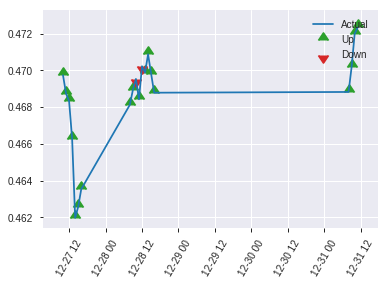


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24799923472723456
RMSE: 0.4979952155666102
LogLoss: 0.6891928634291755
Mean Per-Class Error: 0.4351896690879742
AUC: 0.5753026634382566
pr_auc: 0.5342567191940958
Gini: 0.1506053268765133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37301957607269287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   106  0.8983   (106.0/118.0)
1      2    103  0.019    (2.0/105.0)
Total  14   209  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37302      0.656051  208
max f2                       0.361982     0.821485  212
max f0point5                 0.469218     0.548697  155
max accuracy                 0.592459     0.573991  57
max precision                0.717992     1         0
max recall                   0.340125     1         219
max specificity              0.717992     1         0
max absolute_mcc             0.37302      0.17007   208
max min_per_class_accuracy   0.521407     0.542373  110
max mean_per_class_accuracy  0.504774     0.56481   126

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.700483           2.12381   2.12381            1                0.710347  1                           0.710347            0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.694252           0         1.27429            0                0.695139  0.6                         0.704264            0               0.0285714                  -100      27.4286
    3        0.0313901                   0.691415           1.0619    1.21361            0.5              0.693479  0.571429                    0.701182            0.00952381      0.0380952                  6.19048   21.3605
    4        0.0403587                   0.67354            1.0619    1.17989            0.5              0.686079  0.555556                    0.697826            0.00952381      0.047619                   6.19048   17.9894
    5        0.0538117                   0.669808           1.41587   1.23889            0.666667         0.671466  0.583333                    0.691236            0.0190476       0.0666667                  41.5873   23.8889
    6        0.103139                    0.650073           1.35152   1.29275            0.636364         0.657434  0.608696                    0.67507             0.0666667       0.133333                   35.1515   29.2754
    7        0.152466                    0.631256           1.15844   1.2493             0.545455         0.638844  0.588235                    0.66335             0.0571429       0.190476                   15.8442   24.93
    8        0.201794                    0.618373           0.965368  1.17989            0.454545         0.624346  0.555556                    0.653816            0.047619        0.238095                   -3.4632   17.9894
    9        0.300448                    0.578774           1.15844   1.17285            0.545455         0.594723  0.552239                    0.634412            0.114286        0.352381                   15.8442   17.285
    10       0.399103                    0.555365           0.965368  1.12156            0.454545         0.566589  0.52809                     0.617647            0.0952381       0.447619                   -3.4632   12.1562
    11       0.502242                    0.519402           0.923395  1.08087            0.434783         0.534212  0.508929                    0.600513            0.0952381       0.542857                   -7.66046  8.08673
    12       0.600897                    0.499767           1.15844   1.0936             0.545455         0.507922  0.514925                    0.585311            0.114286        0.657143                   15.8442   9.36034
    13       0.699552                    0.469125           1.0619    1.08913            0.5              0.483079  0.512821                    0.570894            0.104762        0.761905                   6.19048   8.91331
    14       0.798206                    0.44678            0.579221  1.02611            0.272727         0.459766  0.483146                    0.557159            0.0571429       0.819048                   -42.0779  2.61102
    15       0.896861                    0.395084           1.0619    1.03005            0.5              0.417656  0.485                       0.541814            0.104762        0.92381                    6.19048   3.00476
    16       1                           0.327915           0.738716  1                  0.347826         0.365124  0.470852                    0.52359             

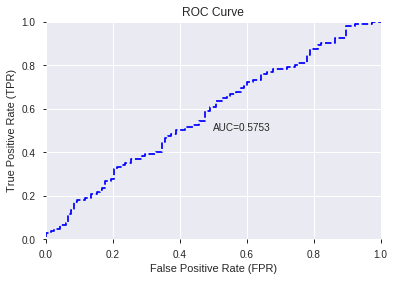

This function is available for GLM models only


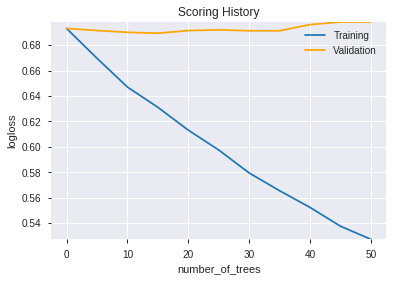

--2019-09-03 02:47:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.212
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.212|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_024631_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_024631_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_024736_model_2  0.574092  0.960112              0.491525  0.562534  0.316444
1  DeepLearning_grid_1_AutoML_20190903_024736_model_4  0.570460  0.813010              0.487813  0.537501  0.288907
2  DeepLearning_grid_1_AutoML_20190903_024736_model_6  0.564084  0.685164              0.466102  0.496079  0.246094
3               DeepLearning_1_AutoML_20190903_024736  0.563358  0.727495              0.459201  0.513828  0.264019
4  DeepLearning_grid_1_AutoML_20190903_024736_model_3  0.551977  0.763387              0.495763  0.522659  0.273173
5  DeepLearning_grid_1_AutoML_20190903_024736_model_1  0.541889  0.951516              0.484100  0.567586  0.322154
6  DeepLearning_grid_1_AutoML_20190903_024736_model_8  0.536804  0.720703              0.500000  0.512364  0.262517
7  DeepLearning_grid_1_AutoML_20190903_024736_model_5  0.533495  0.718483              0.491525  0.509353  0.259440
8  DeepLearning_grid_1_AutoML_20190903_024736_model_7  0.530751  0.921886              0.491525  0.547092  0.299310
9  DeepLearning_grid_1_AutoML_20190903_024736_model_9  0.522034  0.693509              0.500000  0.500178  0.250178

variable  relative_importance  scaled_importance  percentage
0        HT_TRENDMODE             1.000000           1.000000    0.030589
1              SAREXT             0.939477           0.939477    0.028738
2        aroondown_12             0.935964           0.935964    0.028630
3                 BOP             0.859746           0.859746    0.026299
4           aroonup_8             0.856455           0.856455    0.026198
5       days_in_month             0.850875           0.850875    0.026028
6           CORREL_24             0.820501           0.820501    0.025098
7      STOCHRSI_fastk             0.797792           0.797792    0.024404
8        weekday_name             0.789853           0.789853    0.024161
9           CORREL_20             0.780039           0.780039    0.023861
10         aroonup_14             0.771259           0.771259    0.023592
11        aroondown_8             0.766435           0.766435    0.023445
12              DX_12             0.765811           0.765811    0.023425
13        AROONOSC_24             0.755116           0.755116    0.023098
14          CORREL_30             0.749707           0.749707    0.022933
15     STOCHRSI_fastd             0.737481           0.737481    0.022559
16        AROONOSC_20             0.736924           0.736924    0.022542
17         aroonup_30             0.729878           0.729878    0.022326
18         aroonup_24             0.713733           0.713733    0.021832
19        AROONOSC_14             0.710817           0.710817    0.021743
20             MFI_14             0.710315           0.710315    0.021728
21        HT_DCPERIOD             0.709333           0.709333    0.021698
22             ADXR_8             0.700204           0.700204    0.021419
23             MFI_12             0.694859           0.694859    0.021255
24        AROONOSC_30             0.659993           0.659993    0.020189
25       STOCHF_fastd             0.657800           0.657800    0.020122
26            weekday             0.655032           0.655032    0.020037
27          dayofweek             0.635886           0.635886    0.019451
28         AROONOSC_8             0.626756           0.626756    0.019172
29        STOCH_slowk             0.613551           0.613551    0.018768
30            WILLR_8             0.598459           0.598459    0.018306
31       STOCHF_fastk             0.589573           0.589573    0.018035
32         PLUS_DI_12             0.585924           0.585924    0.017923
33              CCI_8             0.572328           0.572328    0.017507
34             CCI_12             0.569824           0.569824    0.017430
35    MACDFIX_hist_14             0.563022           0.563022    0.017222
36           WILLR_12             0.556098           0.556098    0.017011
37           WILLR_20             0.529964           0.529964    0.016211
38           WILLR_24             0.524300           0.524300    0.016038
39        MINUS_DI_20             0.521223           0.521223    0.015944
40             CCI_14             0.508791           0.508791    0.015563
41  LINEARREG_SLOPE_8             0.503510           0.503510    0.015402
42             CMO_30             0.473489           0.473489    0.014484
43             CCI_24             0.462047           0.462047    0.014134
44         MINUS_DM_8             0.429316           0.429316    0.013132
45        MINUS_DM_14             0.416032           0.416032    0.012726
46             CMO_12             0.414838           0.414838    0.012690
47             CMO_14             0.393458           0.393458    0.012036
48             RSI_12             0.374558           0.374558    0.011457
49              CMO_8             0.373037           0.373037    0.011411

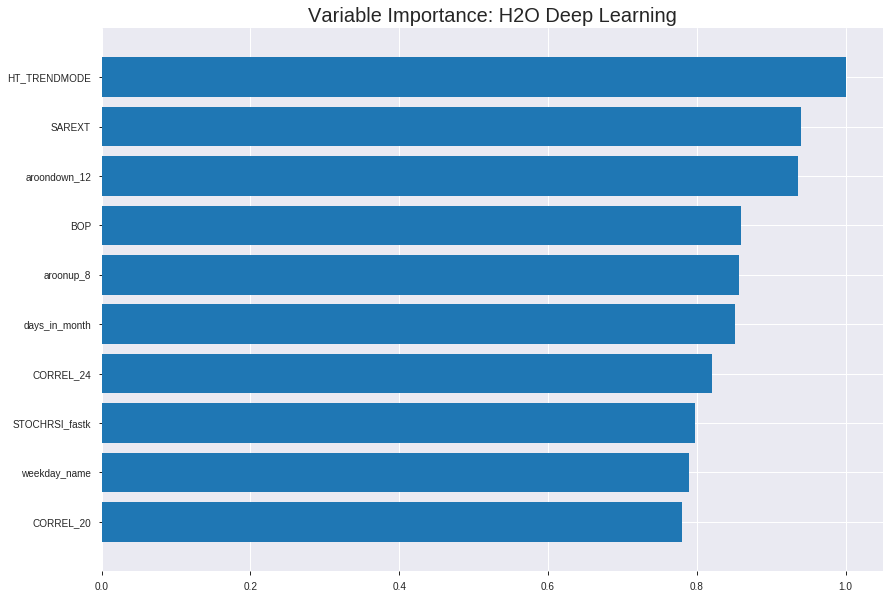

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_024736_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26149085249418
RMSE: 0.5113617628393621
LogLoss: 0.8113114253641972
Mean Per-Class Error: 0.3718848637726331
AUC: 0.6597064475230788
pr_auc: 0.6538991332172732
Gini: 0.31941289504615766
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16009543721770225: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      203  543   0.7279   (543.0/746.0)
1      93   719   0.1145   (93.0/812.0)
Total  296  1262  0.4082   (636.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.160095     0.693346  337
max f2                       0.00218193   0.845305  398
max f0point5                 0.573694     0.643165  179
max accuracy                 0.573694     0.626444  179
max precision                0.982252     0.8125    6
max recall                   0.00218193   1         398
max specificity              0.996666     0.997319  0
max absolute_mcc             0.573694     0.256595  179
max min_per_class_accuracy   0.523328     0.621921  197
max mean_per_class_accuracy  0.573694     0.628115  179

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 51.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.988095           1.31912   1.31912            0.6875           0.993156   0.6875                      0.993156            0.0135468       0.0135468                  31.9119   31.9119
    2        0.0205392                   0.981393           1.7988    1.55896            0.9375           0.984533   0.8125                      0.988844            0.0184729       0.0320197                  79.8799   55.8959
    3        0.0301669                   0.971591           1.53498   1.5513             0.8              0.977061   0.808511                    0.985084            0.0147783       0.046798                   53.4975   55.1305
    4        0.0404365                   0.964225           1.07928   1.43143            0.5625           0.968142   0.746032                    0.980781            0.0110837       0.0578818                  7.92796   43.1425
    5        0.0500642                   0.959623           1.40706   1.42674            0.733333         0.962228   0.74359                     0.977213            0.0135468       0.0714286                  40.7061   42.674
    6        0.100128                    0.922995           1.37754   1.40214            0.717949         0.942299   0.730769                    0.959756            0.0689655       0.140394                   37.7542   40.2141
    7        0.150193                    0.888001           1.37754   1.39394            0.717949         0.905071   0.726496                    0.941528            0.0689655       0.20936                    37.7542   39.3941
    8        0.200257                    0.845364           1.22995   1.35294            0.641026         0.866888   0.705128                    0.922868            0.0615764       0.270936                   22.9948   35.2943
    9        0.300385                    0.749767           1.27915   1.32834            0.666667         0.801677   0.692308                    0.882471            0.128079        0.399015                   27.9146   32.8344
    10       0.399872                    0.64642            1.10172   1.27196            0.574194         0.697655   0.662921                    0.836489            0.109606        0.508621                   10.1716   27.196
    11       0.5                         0.52714            1.09465   1.23645            0.570513         0.588065   0.644416                    0.786741            0.109606        0.618227                   9.46539   23.6453
    12       0.600128                    0.410847           0.873263  1.17586            0.455128         0.466223   0.612834                    0.733264            0.0874384       0.705665                   -12.6737  17.5857
    13       0.699615                    0.293713           0.878897  1.13363            0.458065         0.352377   0.590826                    0.679101            0.0874384       0.793103                   -12.1103  13.3629
    14       0.799743                    0.171288           0.787167  1.09025            0.410256         0.228128   0.568218                    0.622639            0.0788177       0.871921                   -21.2833  9.02514
    15       0.899872                    0.0571914          0.664172  1.04284            0.346154         0.109777   0.543509                    0.565573            0.0665025       0.938424                   -33.5828  4.28417
    16       1                           0.000254851        0.614974  1                  0.320513         0.0228111  0.521181                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.32143265346106614
RMSE: 0.5669503095166861
LogLoss: 0.98204354224685
Mean Per-Class Error: 0.43638014527845037
AUC: 0.5505347054075868
pr_auc: 0.5582712305887634
Gini: 0.10106941081517351
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.042351244953677855: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   190  0.9048   (190.0/210.0)
1      7    229  0.0297   (7.0/236.0)
Total  27   419  0.4417   (197.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0423512    0.699237  378
max f2                       0.0134782    0.852601  395
max f0point5                 0.333707     0.602617  274
max accuracy                 0.333707     0.573991  274
max precision                0.946929     0.657895  32
max recall                   0.0134782    1         395
max specificity              0.998661     0.995238  0
max absolute_mcc             0.0423512    0.137255  378
max min_per_class_accuracy   0.593607     0.529661  197
max mean_per_class_accuracy  0.333707     0.56362   274

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.992309           0.755932  0.755932           0.4              0.995837   0.4                         0.995837            0.00847458      0.00847458                 -24.4068  -24.4068
    2        0.0201794                   0.983464           0.944915  0.839925           0.5              0.988252   0.444444                    0.992466            0.00847458      0.0169492                  -5.50847  -16.0075
    3        0.0313901                   0.979025           0.755932  0.809927           0.4              0.981224   0.428571                    0.988451            0.00847458      0.0254237                  -24.4068  -19.0073
    4        0.0403587                   0.968296           1.41737   0.944915           0.75             0.973465   0.5                         0.985121            0.0127119       0.0381356                  41.7373   -5.50847
    5        0.0515695                   0.963542           1.88983   1.15033            1                0.966266   0.608696                    0.981022            0.0211864       0.059322                   88.9831   15.0332
    6        0.100897                    0.931444           1.11672   1.1339             0.590909         0.949276   0.6                         0.965502            0.0550847       0.114407                   11.6718   13.3898
    7        0.150224                    0.901444           1.20262   1.15646            0.636364         0.917046   0.61194                     0.949591            0.059322        0.173729                   20.2619   15.6463
    8        0.201794                    0.862499           0.657332  1.02891            0.347826         0.882775   0.544444                    0.932516            0.0338983       0.207627                   -34.2668  2.89077
    9        0.300448                    0.782888           1.15967   1.07184            0.613636         0.818192   0.567164                    0.894977            0.114407        0.322034                   15.9669   7.18442
    10       0.401345                    0.707617           1.00791   1.05577            0.533333         0.744513   0.558659                    0.85715             0.101695        0.423729                   0.79096   5.57712
    11       0.5                         0.59301            1.07377   1.05932            0.568182         0.656664   0.560538                    0.817593            0.105932        0.529661                   7.37673   5.9322
    12       0.600897                    0.46776            0.965913  1.04364            0.511111         0.524004   0.552239                    0.768296            0.0974576       0.627119                   -3.40866  4.36377
    13       0.699552                    0.307725           1.24557   1.07212            0.659091         0.376783   0.567308                    0.713083            0.122881        0.75                       24.557    7.21154
    14       0.800448                    0.170131           0.797928  1.03755            0.422222         0.236034   0.54902                     0.65295             0.0805085       0.830508                   -20.2072  3.7554
    15       0.899103                    0.0721249          0.944915  1.02739            0.5              0.119518   0.543641                    0.594419            0.0932203       0.923729                   -5.50847  2.73892
    16       1                           0.00627866         0.755932  1                  0.4              0.0353948  0.529148                 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:48:32  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:48:35  57.719 sec        5712 obs/sec      9.62516   1             14996      0.555005         0.937519            -0.234338      0.584768        0.605764           1.43904          0.47561                          0.588914           1.0174                -0.392008        0.524748          0.530267             1.1339             0.434978
    2019-09-03 02:48:41  1 min  3.466 sec  9026 obs/sec      48.1258   5             74980      0.511362         0.811311            -0.0478438     0.659706        0.653899           1.31912          0.408216                         0.56695            0.982044              -0.290115        0.550535          0.558271             0.755932           0.441704
    2019-09-03 02:48:46  1 min  8.586 sec  11255 obs/sec     96.2606   10            149974     0.466632         0.69188             0.127454       0.751919        0.751132           1.7988           0.355584                         0.57962            1.14102               -0.348419        0.554419          0.570426             0.377966           0.466368
    2019-09-03 02:48:51  1 min 13.634 sec  13112 obs/sec     154.048   16            240007     0.410905         0.534172            0.323414       0.841263        0.847827           1.7988           0.262516                         0.564621           1.08261               -0.279535        0.574576          0.575143             0.377966           0.464126
    2019-09-03 02:48:57  1 min 19.916 sec  13460 obs/sec     211.849   22            330060     0.386038         0.479593            0.402826       0.88272         0.876992           1.91872          0.20154                          0.56705            1.20643               -0.290568        0.581275          0.577001             0.377966           0.464126
    2019-09-03 02:49:02  1 min 25.290 sec  14588 obs/sec     279.236   29            435049     0.325208         0.34128             0.576198       0.929253        0.903491           1.91872          0.138639                         0.568148           1.31403               -0.29557         0.589296          0.585562             0.377966           0.459641
    2019-09-03 02:49:03  1 min 25.362 sec  14585 obs/sec     279.236   29            435049     0.511362         0.811311            -0.0478438     0.659706        0.653899           1.31912          0.408216                         0.56695            0.982044              -0.290115        0.550535          0.558271             0.755932           0.441704

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
HT_TRENDMODE  1.0                    1.0                  0.03058909912750381
SAREXT        0.9394765496253967     0.9394765496253967   0.028737741304456513
aroondown_12  0.9359638690948486     0.9359638690948486   0.028630291571504325
BOP           0.8597458004951477     0.8597458004951477   0.02629884951580119
aroonup_8     0.8564549684524536     0.8564549684524536   0.02619818592823525
---           ---                    ---                  ---
MINUS_DM_14   0.4160321056842804     0.4160321056842804   0.012726047321000595
CMO_12        0.4148383140563965     0.4148383140563965   0.012689530310557669
CMO_14        0.39345821738243103    0.39345821738243103  0.012035532414042125
RSI_12        0.3745581805706024     0.3745581805706024   0.01145739731449163
CMO_8         0.3730368912220001     0.3730368912220001   0.011410862443805618


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5919282511210763)

('F1', 0.6441717791411042)

('auc', 0.5740920096852301)

('logloss', 0.9601121611751534)

('mean_per_class_error', 0.4128732849071832)

('rmse', 0.5625335906163602)

('mse', 0.31644404057173475)

deeplearning prediction progress: |███████████████████████████████████████| 100%


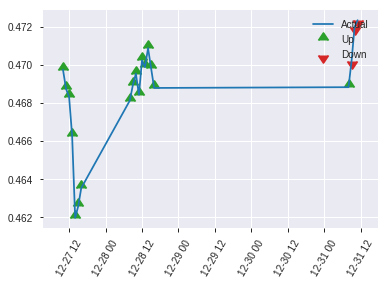


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.31644404057173475
RMSE: 0.5625335906163602
LogLoss: 0.9601121611751534
Mean Per-Class Error: 0.4128732849071832
AUC: 0.5740920096852301
pr_auc: 0.541557891423652
Gini: 0.14818401937046022
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.005723315826016494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    116  0.9831   (116.0/118.0)
1      0    105  0        (0.0/105.0)
Total  2    221  0.5202   (116.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00572332   0.644172  220
max f2                       0.00572332   0.819033  220
max f0point5                 0.738141     0.560254  91
max accuracy                 0.738141     0.591928  91
max precision                0.996154     1         0
max recall                   0.00572332   1         220
max specificity              0.996154     1         0
max absolute_mcc             0.907464     0.188792  32
max min_per_class_accuracy   0.679427     0.542857  108
max mean_per_class_accuracy  0.738141     0.587127  91

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 58.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.986027           1.41587   1.41587            0.666667         0.991266   0.666667                    0.991266            0.0190476       0.0190476                  41.5873   41.5873
    2        0.0224215                   0.980595           1.0619    1.27429            0.5              0.982348   0.6                         0.987699            0.00952381      0.0285714                  6.19048   27.4286
    3        0.0313901                   0.964428           2.12381   1.51701            1                0.976062   0.714286                    0.984374            0.0190476       0.047619                   112.381   51.7007
    4        0.0403587                   0.951201           0         1.17989            0                0.956575   0.555556                    0.978197            0               0.047619                   -100      17.9894
    5        0.0538117                   0.94839            2.12381   1.41587            1                0.949855   0.666667                    0.971111            0.0285714       0.0761905                  112.381   41.5873
    6        0.103139                    0.921722           1.35152   1.38509            0.636364         0.933492   0.652174                    0.953119            0.0666667       0.142857                   35.1515   38.5093
    7        0.152466                    0.905574           1.54459   1.43669            0.727273         0.913481   0.676471                    0.940295            0.0761905       0.219048                   54.4589   43.6695
    8        0.201794                    0.879081           0.579221  1.22709            0.272727         0.89532    0.577778                    0.929301            0.0285714       0.247619                   -42.0779  22.709
    9        0.300448                    0.818297           0.868831  1.10945            0.409091         0.850654   0.522388                    0.903477            0.0857143       0.333333                   -13.1169  10.9453
    10       0.399103                    0.739133           1.44805   1.19315            0.681818         0.775487   0.561798                    0.871839            0.142857        0.47619                    44.8052   19.3151
    11       0.502242                    0.646274           0.738716  1.09983            0.347826         0.710945   0.517857                    0.838798            0.0761905       0.552381                   -26.1284  9.98299
    12       0.600897                    0.549437           1.15844   1.10945            0.545455         0.589776   0.522388                    0.797914            0.114286        0.666667                   15.8442   10.9453
    13       0.699552                    0.420026           0.868831  1.07552            0.409091         0.489419   0.50641                     0.754408            0.0857143       0.752381                   -13.1169  7.55189
    14       0.798206                    0.263019           0.675758  1.02611            0.318182         0.333759   0.483146                    0.702418            0.0666667       0.819048                   -32.4242  2.61102
    15       0.896861                    0.139103           0.772294  0.99819            0.363636         0.200384   0.47                        0.647194            0.0761905       0.895238                   -22.7706  -0.180952
    16       1                           0.00219244         1.01573   1                  0.478261         0.0556133  0.470852                  

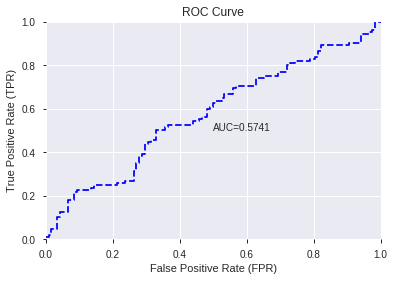

This function is available for GLM models only


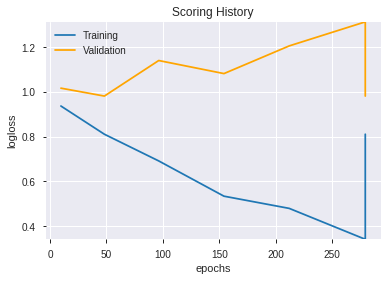

--2019-09-03 02:55:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_024736_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_024736_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_TRENDMODE',
 'SAREXT',
 'aroondown_12',
 'BOP',
 'aroonup_8',
 'days_in_month',
 'CORREL_24',
 'STOCHRSI_fastk',
 'weekday_name',
 'CORREL_20',
 'aroonup_14',
 'aroondown_8',
 'DX_12',
 'AROONOSC_24',
 'CORREL_30',
 'STOCHRSI_fastd',
 'AROONOSC_20',
 'aroonup_30',
 'aroonup_24',
 'AROONOSC_14',
 'MFI_14',
 'HT_DCPERIOD',
 'ADXR_8',
 'MFI_12',
 'AROONOSC_30',
 'STOCHF_fastd',
 'weekday',
 'dayofweek',
 'AROONOSC_8',
 'STOCH_slowk',
 'WILLR_8',
 'STOCHF_fastk',
 'PLUS_DI_12',
 'CCI_8',
 'CCI_12',
 'MACDFIX_hist_14',
 'WILLR_12',
 'WILLR_20',
 'WILLR_24',
 'MINUS_DI_20',
 'CCI_14',
 'LINEARREG_SLOPE_8',
 'CMO_30',
 'CCI_24',
 'MINUS_DM_8',
 'MINUS_DM_14',
 'CMO_12',
 'CMO_14',
 'RSI_12',
 'CMO_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190903_025512_model_1  0.551009  0.695709              0.495763  0.501278  0.25128

variable  relative_importance  scaled_importance  percentage
0        weekday_name             0.008239           1.000000    0.045455
1             weekday             0.007919           0.961150    0.043689
2           dayofweek             0.007901           0.958951    0.043589
3              SAREXT             0.007480           0.907875    0.041267
4           aroonup_8             0.006789           0.823995    0.037454
5           CORREL_20             0.006770           0.821679    0.037349
6       days_in_month             0.006575           0.798040    0.036275
7      STOCHRSI_fastk             0.006026           0.731362    0.033244
8                 BOP             0.005845           0.709391    0.032245
9               DX_12             0.005701           0.691931    0.031452
10    MACDFIX_hist_14             0.005680           0.689357    0.031335
11       STOCHF_fastk             0.005542           0.672613    0.030573
12            WILLR_8             0.005270           0.639646    0.029075
13           WILLR_12             0.005221           0.633671    0.028803
14           WILLR_20             0.005121           0.621511    0.028251
15         AROONOSC_8             0.005109           0.620125    0.028188
16           WILLR_24             0.004807           0.583464    0.026521
17             ADXR_8             0.004658           0.565323    0.025697
18       aroondown_12             0.004149           0.503591    0.022891
19              CCI_8             0.003816           0.463140    0.021052
20       HT_TRENDMODE             0.003744           0.454451    0.020657
21             CMO_30             0.003706           0.449840    0.020447
22        HT_DCPERIOD             0.003679           0.446553    0.020298
23     STOCHRSI_fastd             0.003536           0.429145    0.019507
24  LINEARREG_SLOPE_8             0.002952           0.358255    0.016284
25             CCI_24             0.002929           0.355539    0.016161
26             MFI_12             0.002918           0.354144    0.016098
27             MFI_14             0.002771           0.336349    0.015289
28              CMO_8             0.002540           0.308296    0.014014
29        AROONOSC_20             0.002483           0.301381    0.013699
30             CMO_14             0.002350           0.285212    0.012964
31             CCI_14             0.002323           0.281999    0.012818
32             CMO_12             0.002259           0.274194    0.012463
33         aroonup_30             0.002252           0.273383    0.012427
34             RSI_12             0.002248           0.272828    0.012401
35         aroonup_14             0.002105           0.255477    0.011613
36        aroondown_8             0.001970           0.239146    0.010870
37         MINUS_DM_8             0.001955           0.237261    0.010785
38        STOCH_slowk             0.001858           0.225531    0.010251
39       STOCHF_fastd             0.001846           0.224086    0.010186
40         PLUS_DI_12             0.001708           0.207267    0.009421
41        MINUS_DM_14             0.001599           0.194041    0.008820
42        AROONOSC_30             0.001575           0.191213    0.008692
43             CCI_12             0.001338           0.162425    0.007383
44        AROONOSC_24             0.001000           0.121386    0.005518
45        MINUS_DI_20             0.000772           0.093677    0.004258
46          CORREL_24             0.000672           0.081555    0.003707
47          CORREL_30             0.000618           0.074968    0.003408
48         aroonup_24             0.000534           0.064757    0.002944
49        AROONOSC_14             0.000401           0.048725    0.002215

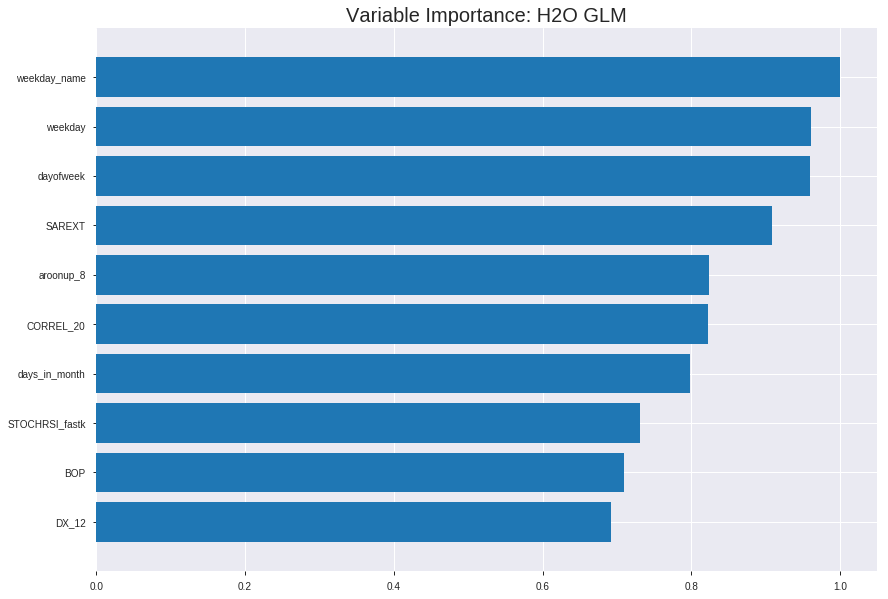

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_025512_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24810933518724773
RMSE: 0.4981057469927924
LogLoss: 0.6893579121254979
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2157.0498856314666
Residual deviance: 2148.0392541830524
AIC: 2250.0392541830524
AUC: 0.5685891255827468
pr_auc: 0.5839211443868362
Gini: 0.13717825116549354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4975665196675173: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      21   725   0.9718   (725.0/746.0)
1      10   802   0.0123   (10.0/812.0)
Total  31   1527  0.4718   (735.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497567     0.685763  377
max f2                       0.485166     0.844777  399
max f0point5                 0.501657     0.583882  355
max accuracy                 0.520221     0.557766  212
max precision                0.559738     1         0
max recall                   0.485166     1         399
max specificity              0.559738     1         0
max absolute_mcc             0.531728     0.119233  121
max min_per_class_accuracy   0.520614     0.554187  209
max mean_per_class_accuracy  0.520221     0.557271  212

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.551265           1.43904   1.43904            0.75             0.554048  0.75                        0.554048            0.0147783       0.0147783                  43.9039    43.9039
    2        0.0205392                   0.548276           1.1992    1.31912            0.625            0.549828  0.6875                      0.551938            0.0123153       0.0270936                  19.92      31.9119
    3        0.0301669                   0.545688           1.02332   1.22471            0.533333         0.546872  0.638298                    0.550321            0.00985222      0.0369458                  2.33169    22.4714
    4        0.0404365                   0.544274           1.1992    1.21823            0.625            0.544833  0.634921                    0.548927            0.0123153       0.0492611                  19.92      21.8234
    5        0.0500642                   0.542859           1.27915   1.22995            0.666667         0.543544  0.641026                    0.547892            0.0123153       0.0615764                  27.9146    22.9948
    6        0.100128                    0.539004           1.27915   1.25455            0.666667         0.540887  0.653846                    0.54439             0.0640394       0.125616                   27.9146    25.4547
    7        0.150193                    0.535946           1.00856   1.17255            0.525641         0.537557  0.611111                    0.542112            0.0504926       0.176108                   0.855753   17.2551
    8        0.200257                    0.533419           1.30375   1.20535            0.679487         0.534751  0.628205                    0.540272            0.0652709       0.241379                   30.3745    20.5349
    9        0.300385                    0.52878            1.03316   1.14795            0.538462         0.531072  0.598291                    0.537205            0.103448        0.344828                   3.31565    14.7952
    10       0.399872                    0.524569           0.965549  1.10257            0.503226         0.526691  0.574639                    0.534589            0.0960591       0.440887                   -3.4451    10.2571
    11       0.5                         0.520646           1.09465   1.10099            0.570513         0.522481  0.573813                    0.532165            0.109606        0.550493                   9.46539    10.0985
    12       0.600128                    0.516709           0.848664  1.05889            0.442308         0.518731  0.551872                    0.529923            0.0849754       0.635468                   -15.1336   5.88868
    13       0.699615                    0.513157           0.990307  1.04913            0.516129         0.514848  0.546789                    0.52778             0.0985222       0.73399                    -0.969331  4.91345
    14       0.799743                    0.509063           0.95936   1.03789            0.5              0.511035  0.540931                    0.525683            0.0960591       0.830049                   -4.06404   3.78947
    15       0.899872                    0.504073           0.885563  1.02094            0.461538         0.506673  0.532097                    0.523568            0.08867         0.918719                   -11.4437   2.09447
    16       1                           0.485166           0.811766  1                  0.423077         0.499729  0.521181                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.249589633973719
RMSE: 0.49958946543509003
LogLoss: 0.6923313803009273
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 616.8842253342874
Residual deviance: 617.5595912284272
AIC: 719.5595912284272
AUC: 0.5026533494753833
pr_auc: 0.5105199002003218
Gini: 0.005306698950766631
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49058793445871235: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    208  0.9905   (208.0/210.0)
1      1    235  0.0042   (1.0/236.0)
Total  3    443  0.4686   (209.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490588     0.692194  396
max f2                       0.485436     0.848921  399
max f0point5                 0.502591     0.585609  370
max accuracy                 0.514198     0.535874  262
max precision                0.525377     0.559524  153
max recall                   0.485436     1         399
max specificity              0.553533     0.995238  0
max absolute_mcc             0.548964     0.140651  16
max min_per_class_accuracy   0.520908     0.5       198
max mean_per_class_accuracy  0.514198     0.526816  262

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.551929           0.377966  0.377966           0.2              0.55269   0.2                         0.55269             0.00423729      0.00423729                 -62.2034  -62.2034
    2        0.0201794                   0.550054           0.472458  0.419962           0.25             0.551134  0.222222                    0.551999            0.00423729      0.00847458                 -52.7542  -58.0038
    3        0.0313901                   0.549283           0.377966  0.404964           0.2              0.549799  0.214286                    0.551213            0.00423729      0.0127119                  -62.2034  -59.5036
    4        0.0403587                   0.548216           0.472458  0.419962           0.25             0.548822  0.222222                    0.550682            0.00423729      0.0169492                  -52.7542  -58.0038
    5        0.0515695                   0.547027           1.51186   0.657332           0.8              0.547455  0.347826                    0.54998             0.0169492       0.0338983                  51.1864   -34.2668
    6        0.100897                    0.543628           1.03082   0.839925           0.545455         0.545553  0.444444                    0.547816            0.0508475       0.0847458                  3.08166   -16.0075
    7        0.150224                    0.538731           0.773112  0.817986           0.409091         0.5412    0.432836                    0.545643            0.0381356       0.122881                   -22.6888  -18.2014
    8        0.201794                    0.534041           1.15033   0.902919           0.608696         0.536223  0.477778                    0.543236            0.059322        0.182203                   15.0332   -9.7081
    9        0.300448                    0.528654           1.24557   1.01543            0.659091         0.530959  0.537313                    0.539205            0.122881        0.305085                   24.557    1.54313
    10       0.401345                    0.524458           1.0919    1.03466            0.577778         0.526412  0.547486                    0.535989            0.110169        0.415254                   9.19021   3.46558
    11       0.5                         0.520534           0.859014  1                  0.454545         0.522528  0.529148                    0.533333            0.0847458       0.5                        -14.0986  0
    12       0.600897                    0.517174           1.17589   1.02953            0.622222         0.518758  0.544776                    0.530885            0.118644        0.618644                   17.5895   2.95345
    13       0.699552                    0.512068           0.816063  0.99943            0.431818         0.51449   0.528846                    0.528573            0.0805085       0.699153                   -18.3937  -0.0570404
    14       0.800448                    0.50832            1.0919    1.01109            0.577778         0.510161  0.535014                    0.526252            0.110169        0.809322                   9.19021   1.10858
    15       0.899103                    0.504323           0.859014  0.9944             0.454545         0.506607  0.526185                    0.524097            0.0847458       0.894068                   -14.0986  -0.560041
    16       1                           0.485436           1.04991   1                  0.555556         0.499592  0.529148                    0.521624   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:55:13  0.000 sec   2            2.8       51            1.37872           1.38466
    2019-09-03 02:55:13  0.016 sec   4            1.8       51            1.37633           1.38587
    2019-09-03 02:55:13  0.033 sec   6            1.1       51            1.37319           1.38769
    2019-09-03 02:55:13  0.048 sec   8            0.68      51            1.36928           1.39026
    2019-09-03 02:55:13  0.060 sec   10           0.42      51            1.36467           1.39373

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6422018348623852)

('auc', 0.5510088781275223)

('logloss', 0.6957091070370731)

('mean_per_class_error', 0.4351896690879742)

('rmse', 0.5012784661154263)

('mse', 0.2512801005910345)

glm prediction progress: |████████████████████████████████████████████████| 100%


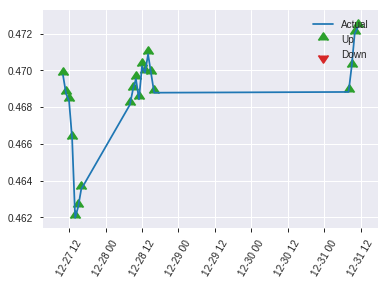


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2512801005910345
RMSE: 0.5012784661154263
LogLoss: 0.6957091070370731
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 310.6462559060497
Residual deviance: 310.2862617385346
AIC: 412.2862617385346
AUC: 0.5510088781275223
pr_auc: 0.5157206176642297
Gini: 0.10201775625504461
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49213425502590025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    117  0.9915   (117.0/118.0)
1      0    105  0        (0.0/105.0)
Total  1    222  0.5247   (117.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492134     0.642202  221
max f2                       0.492134     0.817757  221
max f0point5                 0.522149     0.546493  126
max accuracy                 0.535206     0.565022  51
max precision                0.551911     1         0
max recall                   0.492134     1         221
max specificity              0.551911     1         0
max absolute_mcc             0.522149     0.130669  126
max min_per_class_accuracy   0.52419      0.542857  109
max mean_per_class_accuracy  0.522149     0.56481   126

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 52.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.550251           2.12381   2.12381            1                0.550862  1                           0.550862            0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.5498             0         1.27429            0                0.550208  0.6                         0.550601            0               0.0285714                  -100      27.4286
    3        0.0313901                   0.548432           1.0619    1.21361            0.5              0.54902   0.571429                    0.550149            0.00952381      0.0380952                  6.19048   21.3605
    4        0.0403587                   0.547785           0         0.943915           0                0.548257  0.444444                    0.549729            0               0.0380952                  -100      -5.60847
    5        0.0538117                   0.54695            0.707937  0.884921           0.333333         0.547422  0.416667                    0.549152            0.00952381      0.047619                   -29.2063  -11.5079
    6        0.103139                    0.542416           1.73766   1.29275            0.818182         0.544439  0.608696                    0.546898            0.0857143       0.133333                   73.7662   29.2754
    7        0.152466                    0.539179           0.579221  1.0619             0.272727         0.54078   0.5                         0.544919            0.0285714       0.161905                   -42.0779  6.19048
    8        0.201794                    0.535665           1.73766   1.22709            0.818182         0.537723  0.577778                    0.54316             0.0857143       0.247619                   73.7662   22.709
    9        0.300448                    0.532919           0.965368  1.14115            0.454545         0.534658  0.537313                    0.540368            0.0952381       0.342857                   -3.4632   14.1151
    10       0.399103                    0.527778           0.965368  1.0977             0.454545         0.530439  0.516854                    0.537914            0.0952381       0.438095                   -3.4632   9.76993
    11       0.502242                    0.52405            1.10807   1.09983            0.521739         0.525805  0.517857                    0.535427            0.114286        0.552381                   10.8075   9.98299
    12       0.600897                    0.520751           1.15844   1.10945            0.545455         0.522473  0.522388                    0.5333              0.114286        0.666667                   15.8442   10.9453
    13       0.699552                    0.517436           0.579221  1.03468            0.272727         0.519095  0.487179                    0.531297            0.0571429       0.72381                    -42.0779  3.46764
    14       0.798206                    0.513351           0.868831  1.01418            0.409091         0.515677  0.477528                    0.529367            0.0857143       0.809524                   -13.1169  1.41787
    15       0.896861                    0.508577           0.965368  1.00881            0.454545         0.511101  0.475                       0.527357            0.0952381       0.904762                   -3.4632   0.880952
    16       1                           0.486537           0.923395  1                  0.434783         0.503497  0.470852                    0.524896       

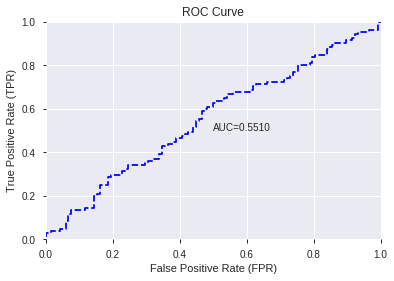

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


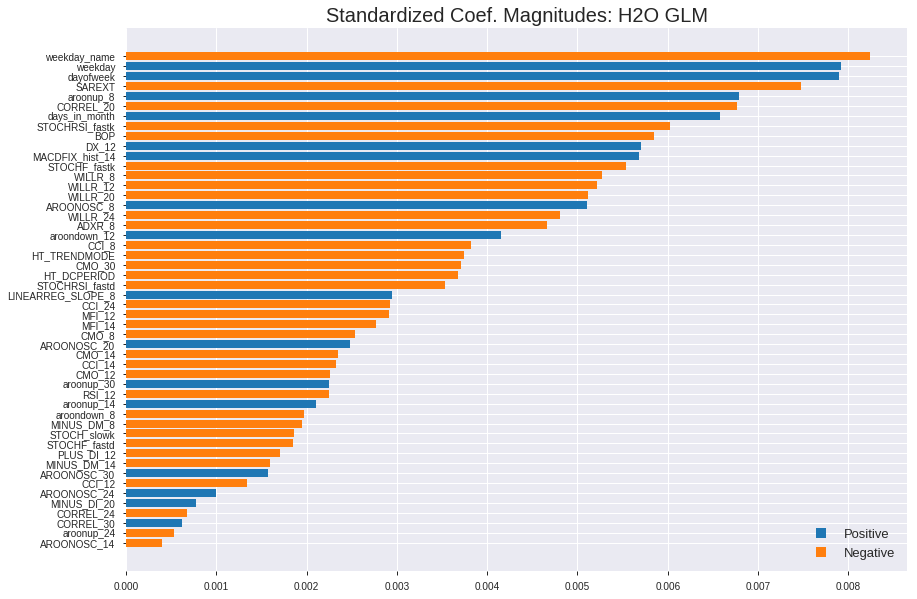

'log_likelihood'
--2019-09-03 02:55:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_025512_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_025512_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['weekday_name',
 'weekday',
 'dayofweek',
 'SAREXT',
 'aroonup_8',
 'CORREL_20',
 'days_in_month',
 'STOCHRSI_fastk',
 'BOP',
 'DX_12',
 'MACDFIX_hist_14',
 'STOCHF_fastk',
 'WILLR_8',
 'WILLR_12',
 'WILLR_20',
 'AROONOSC_8',
 'WILLR_24',
 'ADXR_8',
 'aroondown_12',
 'CCI_8',
 'HT_TRENDMODE',
 'CMO_30',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'LINEARREG_SLOPE_8',
 'CCI_24',
 'MFI_12',
 'MFI_14',
 'CMO_8',
 'AROONOSC_20',
 'CMO_14',
 'CCI_14',
 'CMO_12',
 'aroonup_30',
 'RSI_12',
 'aroonup_14',
 'aroondown_8',
 'MINUS_DM_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'PLUS_DI_12',
 'MINUS_DM_14',
 'AROONOSC_30',
 'CCI_12',
 'AROONOSC_24',
 'MINUS_DI_20',
 'CORREL_24',
 'CORREL_30',
 'aroonup_24',
 'AROONOSC_14']

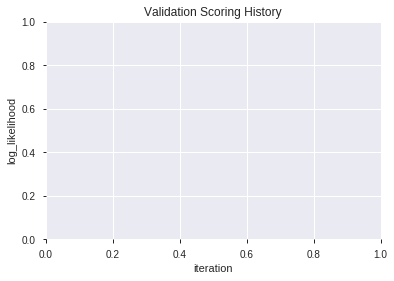

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_025528_model_2  0.602744  0.683050              0.492050  0.494957  0.244982
1  XGBoost_grid_1_AutoML_20190903_025528_model_6  0.588862  0.681453              0.495763  0.494305  0.244338
2  XGBoost_grid_1_AutoML_20190903_025528_model_7  0.583777  0.695674              0.479338  0.500481  0.250481
3               XGBoost_1_AutoML_20190903_025528  0.569734  0.695127              0.495763  0.500839  0.250840
4  XGBoost_grid_1_AutoML_20190903_025528_model_5  0.568765  0.714688              0.495763  0.508792  0.258869
5  XGBoost_grid_1_AutoML_20190903_025528_model_3  0.560129  0.697620              0.487813  0.501936  0.251939
6               XGBoost_2_AutoML_20190903_025528  0.554399  0.697078              0.487813  0.501708  0.251711
7  XGBoost_grid_1_AutoML_20190903_025528_model_1  0.554237  0.697592              0.491525  0.501986  0.251990
8               XGBoost_3_AutoML_20190903_025528  0.550847  0.702969              0.483575  0.504593  0.254614
9  XGBoost_grid_1_AutoML_20190903_025528_model_4  0.536239  0.700149              0.495763  0.503399  0.253411

variable  relative_importance  scaled_importance  percentage
0              SAREXT           331.726257           1.000000    0.066074
1                 BOP           255.746201           0.770956    0.050940
2     MACDFIX_hist_14           191.701508           0.577891    0.038184
3         HT_DCPERIOD           190.400925           0.573970    0.037925
4        STOCHF_fastk           185.910294           0.560433    0.037030
5              ADXR_8           182.372681           0.549769    0.036325
6              MFI_14           175.963272           0.530447    0.035049
7          PLUS_DI_12           167.197128           0.504021    0.033303
8         AROONOSC_30           158.505508           0.477820    0.031572
9          MINUS_DM_8           150.327866           0.453168    0.029943
10           WILLR_20           143.894135           0.433774    0.028661
11        MINUS_DI_20           142.368439           0.429174    0.028357
12              CCI_8           137.523285           0.414569    0.027392
13  LINEARREG_SLOPE_8           133.652298           0.402899    0.026621
14          CORREL_30           130.849869           0.394451    0.026063
15             CMO_30           126.637337           0.381753    0.025224
16        STOCH_slowk           121.556587           0.366436    0.024212
17             MFI_12           121.225838           0.365439    0.024146
18              DX_12           113.349388           0.341696    0.022577
19         aroonup_30           103.955894           0.313379    0.020706
20        MINUS_DM_14            97.186531           0.292972    0.019358
21          CORREL_20            94.772514           0.285695    0.018877
22            WILLR_8            90.914970           0.274066    0.018109
23             CMO_14            89.589630           0.270071    0.017845
24             CMO_12            89.432793           0.269598    0.017813
25          dayofweek            82.726242           0.249381    0.016478
26         AROONOSC_8            82.677361           0.249234    0.016468
27          aroonup_8            82.127708           0.247577    0.016358
28             CCI_14            81.610817           0.246019    0.016255
29     STOCHRSI_fastd            81.186363           0.244739    0.016171
30           WILLR_12            79.405609           0.239371    0.015816
31             CCI_24            72.612808           0.218894    0.014463
32       aroondown_12            71.798889           0.216440    0.014301
33        AROONOSC_20            69.724304           0.210186    0.013888
34        AROONOSC_14            68.643311           0.206928    0.013673
35     STOCHRSI_fastk            68.538635           0.206612    0.013652
36              CMO_8            65.571350           0.197667    0.013061
37             CCI_12            56.821171           0.171289    0.011318
38          CORREL_24            55.963203           0.168703    0.011147
39        AROONOSC_24            50.229298           0.151418    0.010005
40         aroonup_24            45.606873           0.137483    0.009084
41        aroondown_8            41.071041           0.123810    0.008181
42         aroonup_14            38.791473           0.116938    0.007727
43            weekday            25.699169           0.077471    0.005119
44           WILLR_24            25.587280           0.077134    0.005097
45       STOCHF_fastd            21.825270           0.065793    0.004347
46      days_in_month            18.171852           0.054780    0.003620
47       weekday_name             6.222002           0.018756    0.001239
48       HT_TRENDMODE             1.148272           0.003462    0.000229

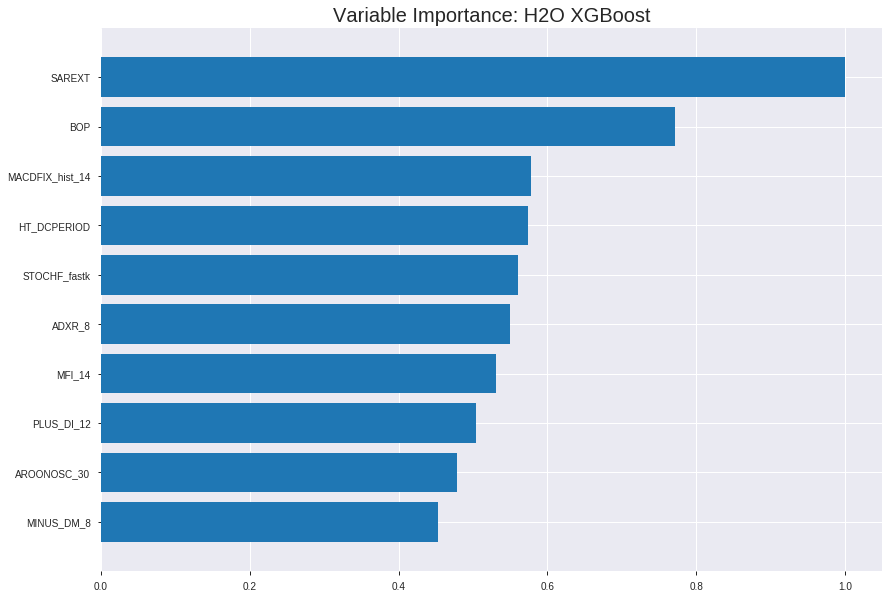

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_025528_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18921957962567035
RMSE: 0.43499376964006087
LogLoss: 0.5684217120042137
Mean Per-Class Error: 0.17143649546348994
AUC: 0.9041654010222006
pr_auc: 0.9013002521930596
Gini: 0.8083308020444011
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.520176370938619: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      617  129  0.1729   (129.0/746.0)
1      138  674  0.17     (138.0/812.0)
Total  755  803  0.1714   (267.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520176     0.834675  201
max f2                       0.439284     0.899638  289
max f0point5                 0.544217     0.850282  174
max accuracy                 0.520176     0.828626  201
max precision                0.750676     1         0
max recall                   0.36576      1         352
max specificity              0.750676     1         0
max absolute_mcc             0.520176     0.656849  201
max min_per_class_accuracy   0.520176     0.827078  201
max mean_per_class_accuracy  0.520176     0.828564  201

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.06 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.726749           1.91872    1.91872            1                0.738898  1                           0.738898            0.0197044       0.0197044                  91.8719   91.8719
    2        0.0205392                   0.713179           1.91872    1.91872            1                0.721156  1                           0.730027            0.0197044       0.0394089                  91.8719   91.8719
    3        0.0301669                   0.701248           1.91872    1.91872            1                0.70604   1                           0.722371            0.0184729       0.0578818                  91.8719   91.8719
    4        0.0404365                   0.692822           1.7988     1.88826            0.9375           0.696824  0.984127                    0.715883            0.0184729       0.0763547                  79.8799   88.8263
    5        0.0500642                   0.682384           1.91872    1.89412            1                0.68777   0.987179                    0.710477            0.0184729       0.0948276                  91.8719   89.412
    6        0.100128                    0.65461            1.79572    1.84492            0.935897         0.667058  0.961538                    0.688767            0.0899015       0.184729                   79.5724   84.4922
    7        0.150193                    0.638005           1.77113    1.82032            0.923077         0.646254  0.948718                    0.674596            0.08867         0.273399                   77.1125   82.0323
    8        0.200257                    0.618391           1.79572    1.81417            0.935897         0.627147  0.945513                    0.662734            0.0899015       0.3633                     79.5724   81.4174
    9        0.300385                    0.585452           1.70963    1.77933            0.891026         0.600929  0.92735                     0.642132            0.171182        0.534483                   70.9628   77.9325
    10       0.399872                    0.553541           1.54735    1.72161            0.806452         0.569313  0.897271                    0.624015            0.153941        0.688424                   54.7354   72.1612
    11       0.5                         0.526              1.20535    1.61823            0.628205         0.540129  0.843389                    0.607216            0.12069         0.809113                   20.5349   61.8227
    12       0.600128                    0.492343           0.860964   1.49188            0.448718         0.508006  0.77754                     0.590664            0.0862069       0.89532                    -13.9036  49.1881
    13       0.699615                    0.454808           0.606563   1.36599            0.316129         0.473505  0.711927                    0.574003            0.0603448       0.955665                   -39.3437  36.5987
    14       0.799743                    0.424248           0.344385   1.23808            0.179487         0.440138  0.645265                    0.557243            0.0344828       0.990148                   -65.5615  23.8082
    15       0.899872                    0.379579           0.0860964  1.1099             0.0448718        0.402524  0.578459                    0.540028            0.00862069      0.998768                   -91.3904  10.9901
    16       1                           0.244324           0.0122995  1                  0.00641026       0.346281  0.521181                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2530244371059787
RMSE: 0.5030153448017055
LogLoss: 0.6997851464770185
Mean Per-Class Error: 0.4448547215496368
AUC: 0.5304882970137208
pr_auc: 0.5416797632116779
Gini: 0.0609765940274416
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3456626236438751: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    204  0.9714   (204.0/210.0)
1      1    235  0.0042   (1.0/236.0)
Total  7    439  0.4596   (205.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345663     0.696296  392
max f2                       0.345663     0.849602  392
max f0point5                 0.471574     0.596515  278
max accuracy                 0.478435     0.565022  266
max precision                0.741086     1         0
max recall                   0.321941     1         398
max specificity              0.741086     1         0
max absolute_mcc             0.478435     0.117319  266
max min_per_class_accuracy   0.507348     0.495238  206
max mean_per_class_accuracy  0.478435     0.555145  266

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.721926           1.1339    1.1339             0.6              0.730689  0.6                         0.730689            0.0127119       0.0127119                  13.3898   13.3898
    2        0.0201794                   0.712888           0.944915  1.04991            0.5              0.716249  0.555556                    0.724271            0.00847458      0.0211864                  -5.50847  4.99058
    3        0.0313901                   0.699038           0.755932  0.944915           0.4              0.70628   0.5                         0.717846            0.00847458      0.029661                   -24.4068  -5.50847
    4        0.0403587                   0.687419           0.944915  0.944915           0.5              0.692038  0.5                         0.712111            0.00847458      0.0381356                  -5.50847  -5.50847
    5        0.0515695                   0.679935           0.755932  0.903832           0.4              0.683769  0.478261                    0.70595             0.00847458      0.0466102                  -24.4068  -9.6168
    6        0.100897                    0.644803           1.03082   0.965913           0.545455         0.659943  0.511111                    0.683457            0.0508475       0.0974576                  3.08166   -3.40866
    7        0.150224                    0.624647           0.859014  0.930812           0.454545         0.633978  0.492537                    0.66721             0.0423729       0.139831                   -14.0986  -6.9188
    8        0.201794                    0.605183           1.39683   1.04991            0.73913          0.613032  0.555556                    0.653365            0.0720339       0.211864                   39.6831   4.99058
    9        0.300448                    0.565156           0.987866  1.02953            0.522727         0.586548  0.544776                    0.631425            0.0974576       0.309322                   -1.21341  2.95345
    10       0.401345                    0.533723           1.0919    1.04521            0.577778         0.549503  0.553073                    0.61083             0.110169        0.419492                   9.19021   4.52135
    11       0.5                         0.507143           0.773112  0.991525           0.409091         0.519069  0.524664                    0.592725            0.0762712       0.495763                   -22.6888  -0.847458
    12       0.600897                    0.491414           1.51186   1.0789             0.8              0.498025  0.570896                    0.576823            0.152542        0.648305                   51.1864   7.88958
    13       0.699552                    0.472453           1.03082   1.07212            0.545455         0.48266   0.567308                    0.563544            0.101695        0.75                       3.08166   7.21154
    14       0.800448                    0.443021           0.713936  1.02697            0.377778         0.458723  0.543417                    0.550331            0.0720339       0.822034                   -28.6064  2.69667
    15       0.899103                    0.410518           0.901965  1.01325            0.477273         0.429691  0.53616                     0.537094            0.0889831       0.911017                   -9.80354  1.32508
    16       1                           0.321542           0.881921  1                  0.466667         0.377542  0.529148                    0.520996    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:55:33  0.708 sec   0                  0.5              0.693147            0.5             0                  1                0.478819                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 02:55:33  0.828 sec   5                  0.490214         0.673741            0.765636        0.696678           1.75331          0.297176                         0.500512           0.694174              0.496651          0.497343             0.903832           0.470852
    2019-09-03 02:55:33  0.906 sec   10                 0.482762         0.659151            0.803755        0.774834           1.80585          0.274069                         0.500246           0.69365               0.511996          0.522355             0.377966           0.459641
    2019-09-03 02:55:33  0.998 sec   15                 0.475174         0.644416            0.819471        0.803182           1.91872          0.252246                         0.501122           0.695453              0.510038          0.521067             0.377966           0.46861
    2019-09-03 02:55:33  1.074 sec   20                 0.468214         0.631025            0.841022        0.834679           1.91872          0.233633                         0.500277           0.693779              0.526604          0.534179             0.755932           0.461883
    2019-09-03 02:55:34  1.143 sec   25                 0.461923         0.618996            0.853906        0.848196           1.91872          0.223363                         0.49971            0.692676              0.539447          0.545244             0.755932           0.459641
    2019-09-03 02:55:34  1.211 sec   30                 0.456451         0.608574            0.865313        0.857935           1.91872          0.227856                         0.500054           0.693426              0.538519          0.546711             0.755932           0.452915
    2019-09-03 02:55:34  1.280 sec   35                 0.450495         0.597321            0.876378        0.871958           1.91872          0.220154                         0.500708           0.694847              0.538882          0.545086             0.755932           0.452915
    2019-09-03 02:55:34  1.349 sec   40                 0.445368         0.587701            0.885516        0.883778           1.91872          0.202824                         0.501276           0.696012              0.535825          0.545311             1.1339             0.459641
    2019-09-03 02:55:34  1.427 sec   45                 0.440362         0.578384            0.896172        0.894918           1.91872          0.191271                         0.501869           0.697289              0.534151          0.543792             1.1339             0.457399
    2019-09-03 02:55:34  1.498 sec   50                 0.434994         0.568422            0.904165        0.9013             1.91872          0.171374                         0.503015           0.699785              0.530488          0.54168              1.1339             0.459641

Variable Importances: 


variable         relative_importance    scaled_importance      percentage
---------------  ---------------------  ---------------------  ----------------------
SAREXT           331.72625732421875     1.0                    0.06607406436313346
BOP              255.74620056152344     0.7709555542103657     0.05094016691001092
MACDFIX_hist_14  191.70150756835938     0.5778906653777376     0.03818358501902265
HT_DCPERIOD      190.4009246826172      0.5739700143679773     0.03792453167185837
STOCHF_fastk     185.91029357910156     0.5604328553268508     0.037030076554081
---              ---                    ---                    ---
WILLR_24         25.5872802734375       0.07713372007338358    0.005096538384696666
STOCHF_fastd     21.82526969909668      0.0657930122117688     0.0043472117235248365
days_in_month    18.171852111816406     0.054779661575163806   0.003619514884708042
weekday_name     6.222001552581787      0.018756433701600534   0.0012393138076223992
HT_TRENDMODE     1.1482723951339722     0.0034615058946379606  0.00022871576327567446


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6143497757847534)

('F1', 0.6419753086419753)

('auc', 0.6027441485068604)

('logloss', 0.6830498896547746)

('mean_per_class_error', 0.39430992736077486)

('rmse', 0.49495656496374113)

('mse', 0.2449820012007061)

xgboost prediction progress: |████████████████████████████████████████████| 100%


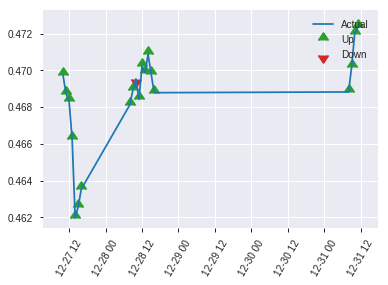


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2449820012007061
RMSE: 0.49495656496374113
LogLoss: 0.6830498896547746
Mean Per-Class Error: 0.39430992736077486
AUC: 0.6027441485068604
pr_auc: 0.5741208337069186
Gini: 0.20548829701372084
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34690287709236145: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    115  0.9746   (115.0/118.0)
1      1    104  0.0095   (1.0/105.0)
Total  4    219  0.5202   (116.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346903     0.641975  218
max f2                       0.307405     0.816485  222
max f0point5                 0.529918     0.582878  110
max accuracy                 0.567948     0.61435   76
max precision                0.712913     1         0
max recall                   0.307405     1         222
max specificity              0.712913     1         0
max absolute_mcc             0.567948     0.221911  76
max min_per_class_accuracy   0.529918     0.601695  110
max mean_per_class_accuracy  0.567948     0.60569   76

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.704453           1.41587   1.41587            0.666667         0.709664  0.666667                    0.709664            0.0190476       0.0190476                  41.5873   41.5873
    2        0.0224215                   0.692741           1.0619    1.27429            0.5              0.699196  0.6                         0.705477            0.00952381      0.0285714                  6.19048   27.4286
    3        0.0313901                   0.677648           2.12381   1.51701            1                0.683617  0.714286                    0.699231            0.0190476       0.047619                   112.381   51.7007
    4        0.0403587                   0.671761           2.12381   1.65185            1                0.67603   0.777778                    0.694075            0.0190476       0.0666667                  112.381   65.1852
    5        0.0538117                   0.66911            1.41587   1.59286            0.666667         0.670386  0.75                        0.688153            0.0190476       0.0857143                  41.5873   59.2857
    6        0.103139                    0.64098            1.35152   1.47743            0.636364         0.649994  0.695652                    0.669903            0.0666667       0.152381                   35.1515   47.7433
    7        0.152466                    0.608799           0.772294  1.2493             0.363636         0.621569  0.588235                    0.654266            0.0380952       0.190476                   -22.7706  24.93
    8        0.201794                    0.596862           1.54459   1.32148            0.727273         0.601574  0.622222                    0.641386            0.0761905       0.266667                   54.4589   32.1481
    9        0.300448                    0.574752           1.25498   1.29964            0.590909         0.586853  0.61194                     0.623479            0.12381         0.390476                   25.4978   29.9645
    10       0.399103                    0.548057           0.868831  1.19315            0.409091         0.563377  0.561798                    0.608623            0.0857143       0.47619                    -13.1169  19.3151
    11       0.502242                    0.529726           1.29275   1.21361            0.608696         0.538508  0.571429                    0.594224            0.133333        0.609524                   29.2754   21.3605
    12       0.600897                    0.496605           0.482684  1.0936             0.227273         0.512391  0.514925                    0.580789            0.047619        0.657143                   -51.7316  9.36034
    13       0.699552                    0.478588           0.965368  1.07552            0.454545         0.486589  0.50641                     0.567504            0.0952381       0.752381                   -3.4632   7.55189
    14       0.798206                    0.45059            0.868831  1.04997            0.409091         0.462502  0.494382                    0.554526            0.0857143       0.838095                   -13.1169  4.99732
    15       0.896861                    0.412541           0.579221  0.99819            0.272727         0.43215   0.47                        0.541065            0.0571429       0.895238                   -42.0779  -0.180952
    16       1                           0.307405           1.01573   1                  0.478261         0.372108  0.470852                    0.523639         

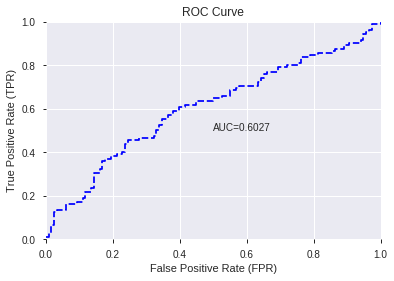

This function is available for GLM models only


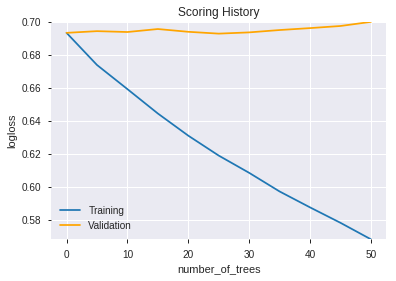

--2019-09-03 02:55:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_025528_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_025528_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SAREXT',
 'BOP',
 'MACDFIX_hist_14',
 'HT_DCPERIOD',
 'STOCHF_fastk',
 'ADXR_8',
 'MFI_14',
 'PLUS_DI_12',
 'AROONOSC_30',
 'MINUS_DM_8',
 'WILLR_20',
 'MINUS_DI_20',
 'CCI_8',
 'LINEARREG_SLOPE_8',
 'CORREL_30',
 'CMO_30',
 'STOCH_slowk',
 'MFI_12',
 'DX_12',
 'aroonup_30',
 'MINUS_DM_14',
 'CORREL_20',
 'WILLR_8',
 'CMO_14',
 'CMO_12',
 'dayofweek',
 'AROONOSC_8',
 'aroonup_8',
 'CCI_14',
 'STOCHRSI_fastd',
 'WILLR_12',
 'CCI_24',
 'aroondown_12',
 'AROONOSC_20',
 'AROONOSC_14',
 'STOCHRSI_fastk',
 'CMO_8',
 'CCI_12',
 'CORREL_24',
 'AROONOSC_24',
 'aroonup_24',
 'aroondown_8',
 'aroonup_14',
 'weekday',
 'WILLR_24',
 'STOCHF_fastd',
 'days_in_month',
 'weekday_name',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 917] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190903_025558  0.577885  1.314154              0.495763  0.592915  0.351548
1  DeepLearning_grid_1_AutoML_20190903_025558_model_3  0.551332  0.774913              0.440113  0.529380  0.280244
2  DeepLearning_grid_1_AutoML_20190903_025558_model_2  0.528410  0.858812              0.467676  0.549052  0.301458
3  DeepLearning_grid_1_AutoML_20190903_025558_model_6  0.517756  0.696784              0.491525  0.501782  0.251785
4  DeepLearning_grid_1_AutoML_20190903_025558_model_4  0.505004  0.946530              0.495763  0.576426  0.332267
5  DeepLearning_grid_1_AutoML_20190903_025558_model_9  0.500000  0.699211              0.500000  0.503018  0.253027
6  DeepLearning_grid_1_AutoML_20190903_025558_model_5  0.476271  0.699885              0.500000  0.503205  0.253215
7  DeepLearning_grid_1_AutoML_20190903_025558_model_7  0.461622  0.766492              0.500000  0.526218  0.276906
8  DeepLearning_grid_1_AutoML_20190903_025558_model_8  0.456013  0.717172              0.500000  0.511729  0.261867
9  DeepLearning_grid_1_AutoML_20190903_025558_model_1  0.442776  1.878062              0.495763  0.660414  0.436147

variable  relative_importance  scaled_importance  percentage
0                    CDLONNECK             1.000000           1.000000    0.001852
1                          BOP             0.888587           0.888587    0.001646
2     BBANDS_middleband_14_6_5             0.844355           0.844355    0.001564
3                      NATR_20             0.842828           0.842828    0.001561
4                       SAREXT             0.813281           0.813281    0.001507
...                        ...                  ...                ...         ...
1033   BBANDS_lowerband_12_4_3             0.258192           0.258192    0.000478
1034        LINEARREG_SLOPE_20             0.256713           0.256713    0.000476
1035   BBANDS_upperband_20_5_2             0.214931           0.214931    0.000398
1036                   KAMA_20             0.205403           0.205403    0.000380
1037                 MAVP_14_6             0.203155           0.203155    0.000376

[1038 rows x 4 columns]

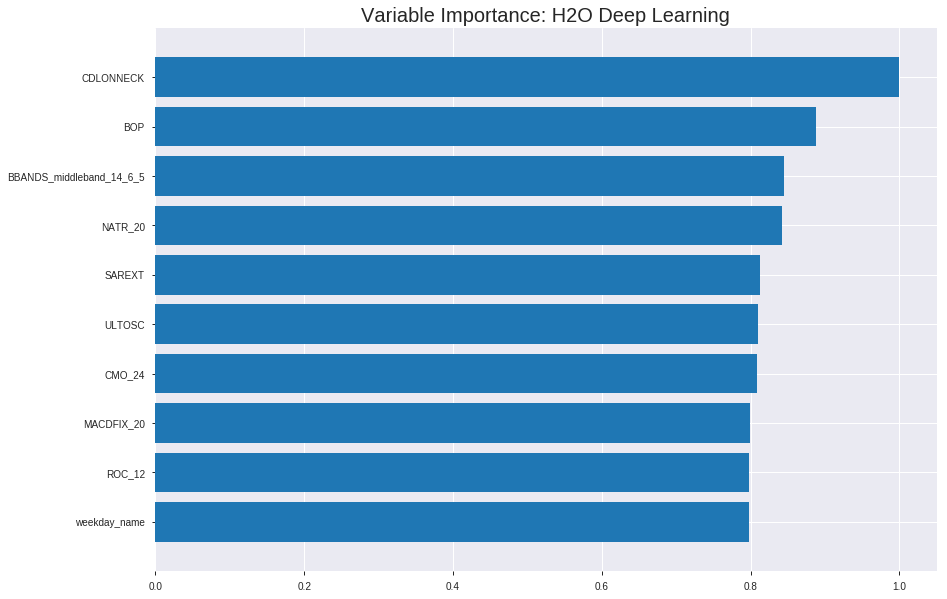

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190903_025558


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3070425330598014
RMSE: 0.5541141877445491
LogLoss: 1.022678973210992
Mean Per-Class Error: 0.4244855980665355
AUC: 0.5891701554431517
pr_auc: 0.6210364564871148
Gini: 0.1783403108863033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0019746192917391332: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   728   0.9759   (728.0/746.0)
1      9    803   0.0111   (9.0/812.0)
Total  27   1531  0.473    (737.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00197462   0.685446  397
max f2                       0.000105439  0.844777  399
max f0point5                 0.291844     0.595784  263
max accuracy                 0.291844     0.57638   263
max precision                0.998517     1         0
max recall                   0.000105439  1         399
max specificity              0.998517     1         0
max absolute_mcc             0.840618     0.158272  35
max min_per_class_accuracy   0.447631     0.571429  219
max mean_per_class_accuracy  0.483873     0.575514  205

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 40.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.944269           1.91872   1.91872            1                0.975873    1                           0.975873            0.0197044       0.0197044                  91.8719   91.8719
    2        0.0205392                   0.874211           1.67888   1.7988             0.875            0.905555    0.9375                      0.940714            0.0172414       0.0369458                  67.8879   79.8799
    3        0.0301669                   0.858555           1.53498   1.7146             0.8              0.864599    0.893617                    0.916422            0.0147783       0.0517241                  53.4975   71.46
    4        0.0404365                   0.842018           1.67888   1.70553            0.875            0.849437    0.888889                    0.89941             0.0172414       0.0689655                  67.8879   70.5528
    5        0.0500642                   0.837761           1.15123   1.59893            0.6              0.839873    0.833333                    0.887961            0.0110837       0.0800493                  15.1232   59.8933
    6        0.100128                    0.808036           1.22995   1.41444            0.641026         0.821165    0.737179                    0.854563            0.0615764       0.141626                   22.9948   41.444
    7        0.150193                    0.777432           0.910162  1.24635            0.474359         0.79548     0.649573                    0.834868            0.0455665       0.187192                   -8.98383  24.6348
    8        0.200257                    0.734615           0.983959  1.18075            0.512821         0.754903    0.615385                    0.814877            0.0492611       0.236453                   -1.60414  18.075
    9        0.300385                    0.645901           1.10695   1.15615            0.576923         0.680928    0.602564                    0.770227            0.110837        0.347291                   10.6953   15.6151
    10       0.399872                    0.572668           1.18837   1.16417            0.619355         0.609136    0.606742                    0.730149            0.118227        0.465517                   18.8368   16.4167
    11       0.5                         0.457001           1.04546   1.14039            0.544872         0.522004    0.594352                    0.688466            0.10468         0.570197                   4.5456    14.0394
    12       0.600128                    0.248453           0.897862  1.09993            0.467949         0.337823    0.573262                    0.629963            0.0899015       0.660099                   -10.2138  9.99289
    13       0.699615                    0.146018           0.779867  1.05442            0.406452         0.193609    0.549541                    0.567913            0.0775862       0.737685                   -22.0133  5.44154
    14       0.799743                    0.048685           0.910162  1.03635            0.474359         0.0889919   0.540128                    0.507952            0.091133        0.828818                   -8.98383  3.63548
    15       0.899872                    0.014448           0.971659  1.02916            0.50641          0.0297533   0.536377                    0.454743            0.0972906       0.926108                   -2.83409  2.91561
    16       1                           3.37924e-05        0.737969  1                  0.384615         0.00602671  0.521181     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3844936000548483
RMSE: 0.6200754793207423
LogLoss: 1.3615069649546834
Mean Per-Class Error: 0.432909604519774
AUC: 0.5491626311541566
pr_auc: 0.541838121730248
Gini: 0.09832526230831329
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00509113030426573: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   188  0.8952   (188.0/210.0)
1      7    229  0.0297   (7.0/236.0)
Total  29   417  0.4372   (195.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00509113   0.701378  382
max f2                       0.00138034   0.849602  396
max f0point5                 0.0510445    0.608892  313
max accuracy                 0.0510445    0.580717  313
max precision                0.997377     0.625     7
max recall                   0.000968032  1         399
max specificity              0.999999     0.995238  0
max absolute_mcc             0.0109416    0.163126  370
max min_per_class_accuracy   0.203404     0.533333  216
max mean_per_class_accuracy  0.0510445    0.56709   313

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 32.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.998805           1.1339    1.1339             0.6              0.999434    0.6                         0.999434            0.0127119       0.0127119                  13.3898   13.3898
    2        0.0201794                   0.996996           0.944915  1.04991            0.5              0.997707    0.555556                    0.998667            0.00847458      0.0211864                  -5.50847  4.99058
    3        0.0313901                   0.994471           0.377966  0.809927           0.2              0.995978    0.428571                    0.997706            0.00423729      0.0254237                  -62.2034  -19.0073
    4        0.0403587                   0.991519           1.41737   0.944915           0.75             0.99312     0.5                         0.996687            0.0127119       0.0381356                  41.7373   -5.50847
    5        0.0515695                   0.985746           0.755932  0.903832           0.4              0.988039    0.478261                    0.994807            0.00847458      0.0466102                  -24.4068  -9.6168
    6        0.100897                    0.904633           0.944915  0.923917           0.5              0.963947    0.488889                    0.97972             0.0466102       0.0932203                  -5.50847  -7.60829
    7        0.150224                    0.7855             1.03082   0.959018           0.545455         0.848909    0.507463                    0.936767            0.0508475       0.144068                   3.08166   -4.09815
    8        0.201794                    0.645568           0.821665  0.923917           0.434783         0.706651    0.488889                    0.87796             0.0423729       0.186441                   -17.8335  -7.60829
    9        0.300448                    0.451555           1.15967   1.00133            0.613636         0.545157    0.529851                    0.768681            0.114407        0.300847                   15.9669   0.132811
    10       0.401345                    0.295073           1.21789   1.05577            0.644444         0.374796    0.558659                    0.66966             0.122881        0.423729                   21.7891   5.57712
    11       0.5                         0.204031           1.07377   1.05932            0.568182         0.243298    0.560538                    0.585534            0.105932        0.529661                   7.37673   5.9322
    12       0.600897                    0.137922           1.0919    1.06479            0.577778         0.165817    0.563433                    0.51506             0.110169        0.639831                   9.19021   6.47926
    13       0.699552                    0.0694237          1.11672   1.07212            0.590909         0.101632    0.567308                    0.456756            0.110169        0.75                       11.6718   7.21154
    14       0.800448                    0.0368605          1.00791   1.06402            0.533333         0.0496645   0.563025                    0.405442            0.101695        0.851695                   0.79096   6.40222
    15       0.899103                    0.0080702          0.859014  1.04153            0.454545         0.0210501   0.551122                    0.363264            0.0847458       0.936441                   -14.0986  4.15275
    16       1                           0.000917173        0.629944  1                  0.333333         0.00379447  0.52


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:55:59  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:55:59  0.734 sec   6411 obs/sec      1         1             1558       0.638001         1.96784             -0.631109      0.528151        0.551144           1.31912          0.478819                         0.662232           2.25883               -0.760189        0.550081          0.556232             1.51186            0.44843
    2019-09-03 02:56:01  2.436 sec   8471 obs/sec      10        10            15580      0.554114         1.02268             -0.230378      0.58917         0.621036           1.91872          0.473042                         0.620075           1.36151               -0.543219        0.549163          0.541838             1.1339             0.43722

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
CDLONNECK                 1.0                    1.0                  0.0018524209357427385
BOP                       0.8885866403579712     0.8885866403579712   0.0016460364958204093
BBANDS_middleband_14_6_5  0.8443547487258911     0.8443547487258911   0.0015641004137336401
NATR_20                   0.8428284525871277     0.8428284525871277   0.0015612730708120515
SAREXT                    0.8132807016372681     0.8132807016372681   0.001506538198348419
---                       ---                    ---                  ---
BBANDS_lowerband_12_4_3   0.2581920921802521     0.2581920921802521   0.000478280436997918
LINEARREG_SLOPE_20        0.2567134499549866     0.2567134499549866   0.0004755413691833629
BBANDS_upperband_20_5_2   0.21493124961853027    0.21493124961853027  0.00039814314653871394
KAMA_20                   0.20540280640125275    0.20540280640125275  0.00038049245883799317
MAVP_14_6                 0.20315490663051605    0.20315490663051605  0.00037632840224122925


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5874439461883408)

('F1', 0.6422018348623852)

('auc', 0.5778853914447135)

('logloss', 1.314153538975202)

('mean_per_class_error', 0.42138821630347056)

('rmse', 0.5929145304035097)

('mse', 0.3515476403636144)

deeplearning prediction progress: |███████████████████████████████████████| 100%


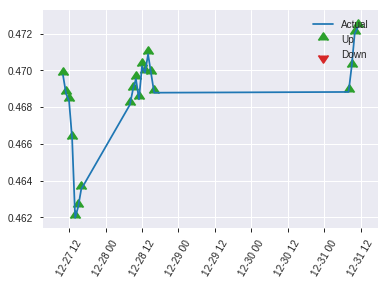


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3515476403636144
RMSE: 0.5929145304035097
LogLoss: 1.314153538975202
Mean Per-Class Error: 0.42138821630347056
AUC: 0.5778853914447135
pr_auc: 0.5446533535081461
Gini: 0.15577078288942703
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00023574789983317799: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    117  0.9915   (117.0/118.0)
1      0    105  0        (0.0/105.0)
Total  1    222  0.5247   (117.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000235748  0.642202  221
max f2                       0.000235748  0.817757  221
max f0point5                 0.112568     0.555556  110
max accuracy                 0.582885     0.587444  44
max precision                0.998549     1         0
max recall                   0.000235748  1         221
max specificity              0.998549     1         0
max absolute_mcc             0.582885     0.174862  44
max min_per_class_accuracy   0.112568     0.576271  110
max mean_per_class_accuracy  0.112568     0.578612  110

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 26.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.994325           1.41587   1.41587            0.666667         0.996415    0.666667                    0.996415            0.0190476       0.0190476                  41.5873   41.5873
    2        0.0224215                   0.987671           1.0619    1.27429            0.5              0.989963    0.6                         0.993834            0.00952381      0.0285714                  6.19048   27.4286
    3        0.0313901                   0.983677           1.0619    1.21361            0.5              0.985874    0.571429                    0.99156             0.00952381      0.0380952                  6.19048   21.3605
    4        0.0403587                   0.976934           1.0619    1.17989            0.5              0.981541    0.555556                    0.989333            0.00952381      0.047619                   6.19048   17.9894
    5        0.0538117                   0.970142           2.12381   1.41587            1                0.972588    0.666667                    0.985147            0.0285714       0.0761905                  112.381   41.5873
    6        0.103139                    0.85183            1.35152   1.38509            0.636364         0.929458    0.652174                    0.958513            0.0666667       0.142857                   35.1515   38.5093
    7        0.152466                    0.685749           1.15844   1.31176            0.545455         0.776182    0.617647                    0.899524            0.0571429       0.2                        15.8442   31.1765
    8        0.201794                    0.579995           1.54459   1.36868            0.727273         0.63372     0.644444                    0.83455             0.0761905       0.27619                    54.4589   36.8677
    9        0.300448                    0.312222           0.675758  1.14115            0.318182         0.44941     0.537313                    0.708086            0.0666667       0.342857                   -32.4242  14.1151
    10       0.399103                    0.175603           1.0619    1.12156            0.5              0.238123    0.52809                     0.591915            0.104762        0.447619                   6.19048   12.1562
    11       0.502242                    0.10966            1.29275   1.15672            0.608696         0.134102    0.544643                    0.4979              0.133333        0.580952                   29.2754   15.6718
    12       0.600897                    0.0621566          0.772294  1.0936             0.363636         0.0852305   0.514925                    0.430148            0.0761905       0.657143                   -22.7706  9.36034
    13       0.699552                    0.0352552          0.965368  1.07552            0.454545         0.0450779   0.50641                     0.375843            0.0952381       0.752381                   -3.4632   7.55189
    14       0.798206                    0.0167154          0.868831  1.04997            0.409091         0.0256965   0.494382                    0.332567            0.0857143       0.838095                   -13.1169  4.99732
    15       0.896861                    0.00693278         0.772294  1.01943            0.363636         0.0111626   0.48                        0.297212            0.0761905       0.914286                   -22.7706  1.94286
    16       1                           0.000145924        0.831056  1                  0.391304         0.00298558  0.470852 

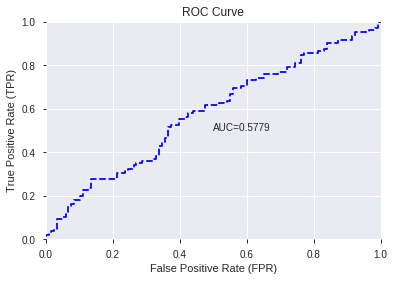

This function is available for GLM models only


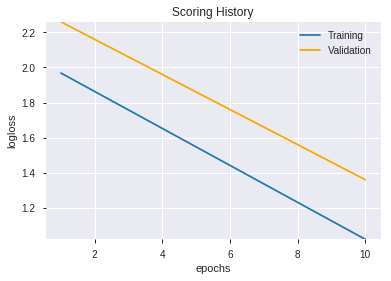

--2019-09-03 03:18:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190903_025558',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190903_025558',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_bcbc'

['CDLONNECK',
 'BOP',
 'BBANDS_middleband_14_6_5',
 'NATR_20',
 'SAREXT',
 'ULTOSC',
 'CMO_24',
 'MACDFIX_20',
 'ROC_12',
 'weekday_name',
 'STOCHF_fastk',
 'MACDFIX_hist_12',
 'ADXR_14',
 'aroonup_8',
 'STOCHRSI_fastd',
 'MACDFIX_signal_24',
 'MFI_14',
 'MIDPRICE_24',
 'CMO_20',
 'SQRT',
 'CDLRISEFALL3METHODS',
 'STOCHRSI_fastk',
 'BBANDS_middleband_30_2_2',
 'MACDFIX_hist_24',
 'BBANDS_lowerband_12_5_4',
 'CDL3OUTSIDE',
 'days_in_month',
 'MIDPRICE_20',
 'MFI_24',
 'BBANDS_middleband_12_4_5',
 'MAVP_14_3',
 'MOM_24',
 'BBANDS_lowerband_8_6_4',
 'BBANDS_middleband_12_0_2',
 'BBANDS_upperband_20_6_5',
 'BBANDS_middleband_24_1_2',
 'LINEARREG_ANGLE_24',
 'CMO_12',
 'STOCH_slowk',
 'BETA_20',
 'MULT',
 'VAR_24',
 'WMA_24',
 'BETA_24',
 'BBANDS_lowerband_30_7_2',
 'CDL3LINESTRIKE',
 'CDL3BLACKCROWS',
 'SMA_20',
 'BBANDS_upperband_24_0_4',
 'WILLR_14',
 'BBANDS_upperband_24_6_5',
 'BBANDS_upperband_8_2_2',
 'BBANDS_upperband_30_2_5',
 'BBANDS_upperband_20_0_4',
 'BBANDS_upperband_14_1_2',


In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_031845_model_1  0.570541  0.69417              0.487288  0.500517  0.250517

variable  relative_importance  scaled_importance  percentage
0                 weekday_name             0.008311           1.000000    0.009929
1           CDLCLOSINGMARUBOZU             0.007942           0.955551    0.009488
2                    dayofweek             0.007758           0.933461    0.009268
3                      weekday             0.007755           0.933099    0.009265
4                       SAREXT             0.007671           0.923017    0.009165
...                        ...                  ...                ...         ...
1033   BBANDS_middleband_8_1_3             0.000004           0.000511    0.000005
1034                 MAVP_24_3             0.000004           0.000510    0.000005
1035   BBANDS_upperband_12_7_2             0.000004           0.000471    0.000005
1036                       EXP             0.000004           0.000448    0.000004
1037  BBANDS_middleband_24_1_2             0.000002           0.000285    0.000003

[1038 rows x 4 columns]

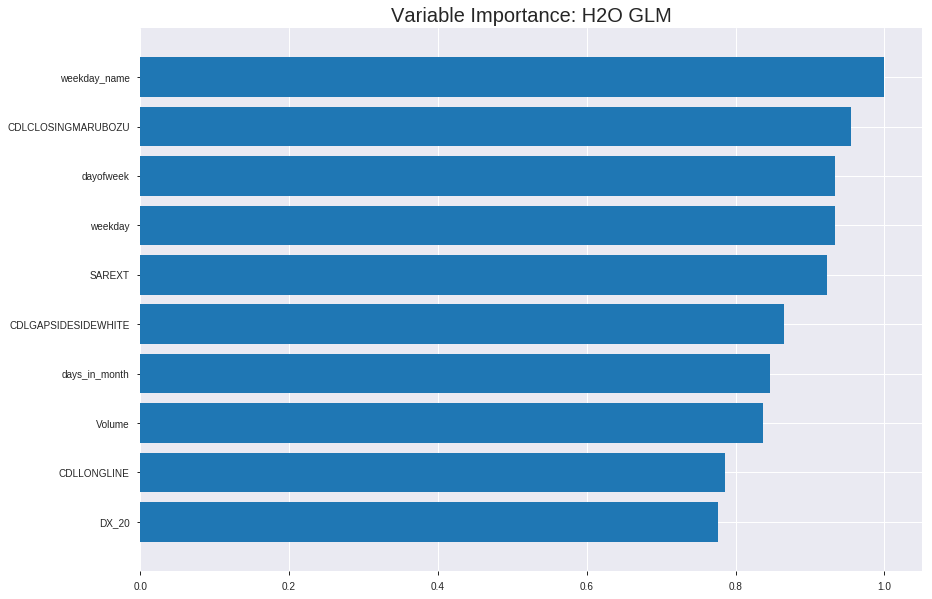

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_031845_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2455030848851611
RMSE: 0.4954826786933738
LogLoss: 0.6841201541166592
Null degrees of freedom: 1557
Residual degrees of freedom: 519
Null deviance: 2157.0498856314666
Residual deviance: 2131.71840022751
AIC: 4209.71840022751
AUC: 0.6143570305999815
pr_auc: 0.6209187416037079
Gini: 0.22871406119996296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47632994370423504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      30   716   0.9598   (716.0/746.0)
1      14   798   0.0172   (14.0/812.0)
Total  44   1514  0.4685   (730.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47633      0.686156  368
max f2                       0.452883     0.845305  396
max f0point5                 0.518996     0.608173  212
max accuracy                 0.523367     0.591784  191
max precision                0.604235     1         0
max recall                   0.452883     1         396
max specificity              0.604235     1         0
max absolute_mcc             0.528941     0.19548   168
max min_per_class_accuracy   0.521129     0.58867   202
max mean_per_class_accuracy  0.528667     0.594689  169

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.576104           1.7988    1.7988             0.9375           0.587497  0.9375                      0.587497            0.0184729       0.0184729                  79.8799   79.8799
    2        0.0205392                   0.569938           1.31912   1.55896            0.6875           0.572736  0.8125                      0.580117            0.0135468       0.0320197                  31.9119   55.8959
    3        0.0301669                   0.567074           1.15123   1.42883            0.6              0.568156  0.744681                    0.576299            0.0110837       0.0431034                  15.1232   42.8833
    4        0.0404365                   0.564877           0.95936   1.3096             0.5              0.566244  0.68254                     0.573746            0.00985222      0.0529557                  -4.06404  30.9602
    5        0.0500642                   0.561416           1.02332   1.25455            0.533333         0.563306  0.653846                    0.571738            0.00985222      0.0628079                  2.33169   25.4547
    6        0.100128                    0.550816           1.25455   1.25455            0.653846         0.554928  0.653846                    0.563333            0.0628079       0.125616                   25.4547   25.4547
    7        0.150193                    0.545138           1.30375   1.27095            0.679487         0.547775  0.662393                    0.558147            0.0652709       0.190887                   30.3745   27.0946
    8        0.200257                    0.540384           1.20535   1.25455            0.628205         0.542747  0.653846                    0.554297            0.0603448       0.251232                   20.5349   25.4547
    9        0.300385                    0.532921           1.10695   1.20535            0.576923         0.536507  0.628205                    0.548367            0.110837        0.362069                   10.6953   20.5349
    10       0.399872                    0.527115           1.27502   1.22268            0.664516         0.529962  0.637239                    0.543788            0.126847        0.488916                   27.502    22.2683
    11       0.5                         0.521267           0.971659  1.17241            0.50641          0.524118  0.61104                     0.539849            0.0972906       0.586207                   -2.83409  17.2414
    12       0.600128                    0.515407           0.934761  1.13276            0.487179         0.518248  0.590374                    0.536245            0.0935961       0.679803                   -6.52394  13.2763
    13       0.699615                    0.508752           0.866518  1.0949             0.451613         0.512147  0.570642                    0.532818            0.0862069       0.76601                    -13.3482  9.49022
    14       0.799743                    0.50241            0.897862  1.07023            0.467949         0.505846  0.557785                    0.529441            0.0899015       0.855911                   -10.2138  7.02326
    15       0.899872                    0.491389           0.71337   1.03052            0.371795         0.497185  0.53709                     0.525852            0.0714286       0.92734                    -28.663   3.05247
    16       1                           0.439865           0.725669  1                  0.378205         0.479201  0.521181                    0.521181         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.250013350085328
RMSE: 0.500013349907108
LogLoss: 0.6932009037721395
Null degrees of freedom: 445
Residual degrees of freedom: -593
Null deviance: 616.8842253342874
Residual deviance: 618.3352061647485
AIC: 2696.3352061647483
AUC: 0.5104015334947538
pr_auc: 0.5123528401644676
Gini: 0.020803066989507624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.469045033540124: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    208  0.9905   (208.0/210.0)
1      1    235  0.0042   (1.0/236.0)
Total  3    443  0.4686   (209.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469045     0.692194  396
max f2                       0.447036     0.848921  399
max f0point5                 0.499503     0.589474  369
max accuracy                 0.520933     0.55157   243
max precision                0.596887     1         0
max recall                   0.447036     1         399
max specificity              0.596887     1         0
max absolute_mcc             0.570119     0.117192  16
max min_per_class_accuracy   0.52498      0.514286  204
max mean_per_class_accuracy  0.520933     0.545319  243

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.583799           0.755932  0.755932           0.4              0.587187  0.4                         0.587187            0.00847458      0.00847458                 -24.4068  -24.4068
    2        0.0201794                   0.577384           0.472458  0.629944           0.25             0.581647  0.333333                    0.584725            0.00423729      0.0127119                  -52.7542  -37.0056
    3        0.0313901                   0.574102           0.377966  0.539952           0.2              0.575576  0.285714                    0.581458            0.00423729      0.0169492                  -62.2034  -46.0048
    4        0.0403587                   0.56923            0.472458  0.524953           0.25             0.570857  0.277778                    0.579102            0.00423729      0.0211864                  -52.7542  -47.5047
    5        0.0515695                   0.567463           0.755932  0.575166           0.4              0.568615  0.304348                    0.576822            0.00847458      0.029661                   -24.4068  -42.4834
    6        0.100897                    0.556078           1.03082   0.797928           0.545455         0.561011  0.422222                    0.569092            0.0508475       0.0805085                  3.08166   -20.2072
    7        0.150224                    0.547885           0.687211  0.761573           0.363636         0.551879  0.402985                    0.56344             0.0338983       0.114407                   -31.2789  -23.8427
    8        0.201794                    0.542098           1.39683   0.923917           0.73913          0.544724  0.488889                    0.558657            0.0720339       0.186441                   39.6831   -7.60829
    9        0.300448                    0.535033           1.24557   1.02953            0.659091         0.538102  0.544776                    0.551908            0.122881        0.309322                   24.557    2.95345
    10       0.401345                    0.53067            0.881921  0.992425           0.466667         0.532516  0.52514                     0.547033            0.0889831       0.398305                   -11.8079  -0.757504
    11       0.5                         0.525194           1.15967   1.02542            0.613636         0.528367  0.542601                    0.54335             0.114407        0.512712                   15.9669   2.54237
    12       0.600897                    0.521264           1.25989   1.06479            0.666667         0.523082  0.563433                    0.539947            0.127119        0.639831                   25.9887   6.47926
    13       0.699552                    0.517123           0.730162  1.0176             0.386364         0.519416  0.538462                    0.537051            0.0720339       0.711864                   -26.9838  1.7601
    14       0.800448                    0.511691           1.04991   1.02167            0.555556         0.514579  0.540616                    0.534219            0.105932        0.817797                   4.99058   2.16731
    15       0.899103                    0.502743           0.859014  1.00383            0.454545         0.507682  0.531172                    0.531307            0.0847458       0.902542                   -14.0986  0.382518
    16       1                           0.447036           0.965913  1                  0.511111         0.491132  0.529148                    0.52725


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:18:49  0.000 sec   2            2.9       1039          1.36824           1.3864
    2019-09-03 03:18:51  1.936 sec   4            2.1       1039          1.36417           1.38734
    2019-09-03 03:18:53  3.883 sec   6            1.5       1039          1.35953           1.38871
    2019-09-03 03:18:55  5.809 sec   8            1.1       1039          1.35425           1.39053
    2019-09-03 03:18:57  7.762 sec   10           0.81      1039          1.34832           1.39259

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5919282511210763)

('F1', 0.6461538461538462)

('auc', 0.5705407586763519)

('logloss', 0.6941699863167469)

('mean_per_class_error', 0.4081517352703794)

('rmse', 0.5005168134891901)

('mse', 0.2505170805853727)

glm prediction progress: |████████████████████████████████████████████████| 100%


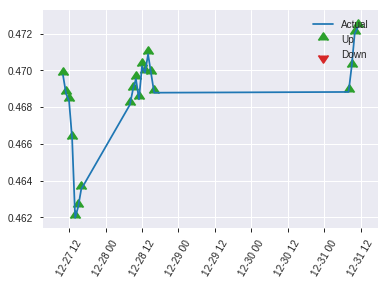


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2505170805853727
RMSE: 0.5005168134891901
LogLoss: 0.6941699863167469
Null degrees of freedom: 222
Residual degrees of freedom: -816
Null deviance: 310.6462559060497
Residual deviance: 309.5998138972691
AIC: 2387.599813897269
AUC: 0.5705407586763519
pr_auc: 0.52901994785498
Gini: 0.1410815173527038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48652464660249045: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    115  0.9746   (115.0/118.0)
1      0    105  0        (0.0/105.0)
Total  3    220  0.5157   (115.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486525     0.646154  219
max f2                       0.486525     0.820313  219
max f0point5                 0.529963     0.568807  109
max accuracy                 0.530302     0.591928  107
max precision                0.603482     1         0
max recall                   0.486525     1         219
max specificity              0.603482     1         0
max absolute_mcc             0.529963     0.183401  109
max min_per_class_accuracy   0.529963     0.590476  109
max mean_per_class_accuracy  0.529963     0.591848  109

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 53.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.58555            2.12381   2.12381            1                0.593339  1                           0.593339            0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.576628           1.0619    1.69905            0.5              0.582168  0.8                         0.58887             0.00952381      0.0380952                  6.19048   69.9048
    3        0.0313901                   0.571451           0         1.21361            0                0.572379  0.571429                    0.584159            0               0.0380952                  -100      21.3605
    4        0.0403587                   0.569602           2.12381   1.41587            1                0.570895  0.666667                    0.581211            0.0190476       0.0571429                  112.381   41.5873
    5        0.0538117                   0.569053           0.707937  1.23889            0.333333         0.569283  0.583333                    0.578229            0.00952381      0.0666667                  -29.2063  23.8889
    6        0.103139                    0.559369           0.965368  1.10807            0.454545         0.563541  0.521739                    0.571205            0.047619        0.114286                   -3.4632   10.8075
    7        0.152466                    0.554206           0.965368  1.0619             0.454545         0.556693  0.5                         0.56651             0.047619        0.161905                   -3.4632   6.19048
    8        0.201794                    0.54834            1.15844   1.0855             0.545455         0.551157  0.511111                    0.562757            0.0571429       0.219048                   15.8442   8.55026
    9        0.300448                    0.540788           1.25498   1.14115            0.590909         0.543896  0.537313                    0.556564            0.12381         0.342857                   25.4978   14.1151
    10       0.399103                    0.533462           1.35152   1.19315            0.636364         0.537022  0.561798                    0.551733            0.133333        0.47619                    35.1515   19.3151
    11       0.502242                    0.529642           1.10807   1.17568            0.521739         0.531629  0.553571                    0.547605            0.114286        0.590476                   10.8075   17.568
    12       0.600897                    0.525185           0.579221  1.07775            0.272727         0.527064  0.507463                    0.544232            0.0571429       0.647619                   -42.0779  7.77541
    13       0.699552                    0.521189           0.965368  1.0619             0.454545         0.522903  0.5                         0.541224            0.0952381       0.742857                   -3.4632   6.19048
    14       0.798206                    0.513872           0.868831  1.03804            0.409091         0.517878  0.488764                    0.538339            0.0857143       0.828571                   -13.1169  3.80417
    15       0.896861                    0.505557           0.675758  0.99819            0.318182         0.509838  0.47                        0.535204            0.0666667       0.895238                   -32.4242  -0.180952
    16       1                           0.437474           1.01573   1                  0.478261         0.494004  0.470852                    0.530954        

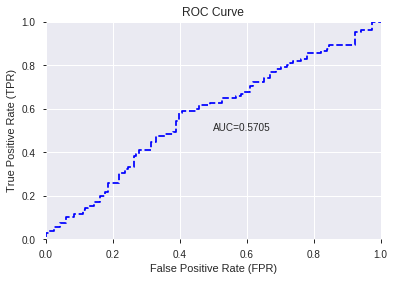

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


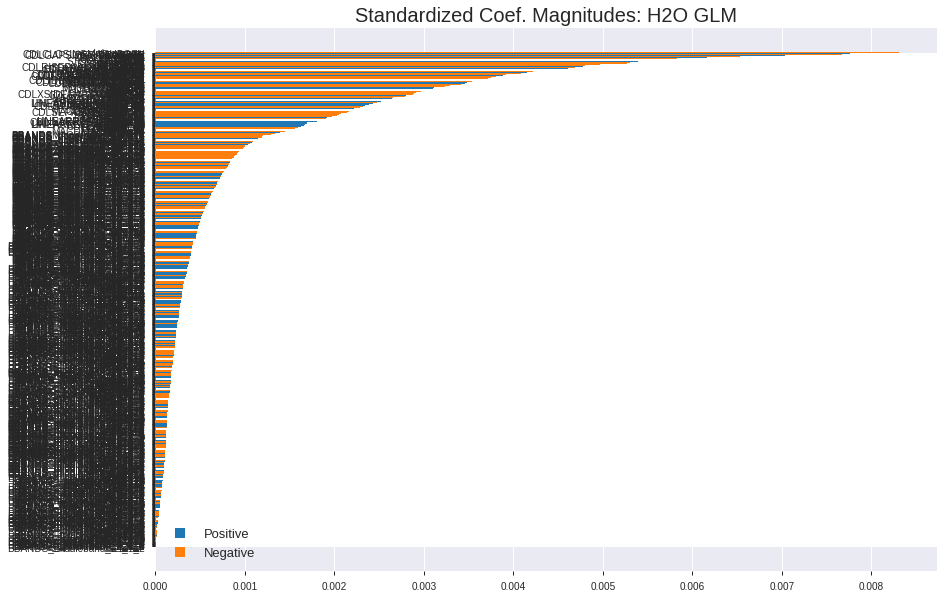

'log_likelihood'
--2019-09-03 03:19:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_031845_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_031845_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['weekday_name',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'weekday',
 'SAREXT',
 'CDLGAPSIDESIDEWHITE',
 'days_in_month',
 'Volume',
 'CDLLONGLINE',
 'DX_20',
 'DX_24',
 'DX_14',
 'CDLHAMMER',
 'DX_12',
 'STOCHRSI_fastk',
 'SUB',
 'BOP',
 'WILLR_14',
 'DIV',
 'quarter',
 'aroonup_8',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLHARAMI',
 'WILLR_12',
 'WILLR_20',
 'DX_30',
 'CORREL_20',
 'day',
 'CDLRISEFALL3METHODS',
 'DX_8',
 'CDLHARAMICROSS',
 'WILLR_24',
 'CDLADVANCEBLOCK',
 'HT_PHASOR_inphase',
 'AROONOSC_8',
 'hour',
 'CDL3LINESTRIKE',
 'CORREL_14',
 'TRANGE',
 'WILLR_30',
 'CDLHANGINGMAN',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'MFI_30',
 'aroondown_12',
 'CDL3WHITESOLDIERS',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'ADXR_14',
 'CDLSPINNINGTOP',
 'CDLONNECK',
 'CCI_8',
 'MACDFIX_hist_20',
 'STOCHRSI_fastd',
 'ADXR_12',
 'CDLIDENTICAL3CROWS',
 'MACDFIX_hist_24',
 'CDLTHRUSTING',
 'dayofyear',
 'CDLCOUNTERATTACK',
 'CDLHIGHWAVE',
 'CDL3BLACKCROWS',
 'MACDFIX_hist_14',
 'week',
 'weekofyear',
 'ar

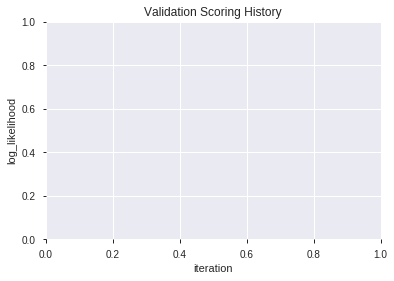

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_031934_model_3  0.575303  0.689193              0.458676  0.497995  0.247999
1               XGBoost_3_AutoML_20190903_031934  0.574576  0.689344              0.478814  0.498176  0.248179
2  XGBoost_grid_1_AutoML_20190903_031934_model_6  0.569734  0.695224              0.483051  0.500934  0.250935
3  XGBoost_grid_1_AutoML_20190903_031934_model_4  0.566828  0.691674              0.441162  0.499333  0.249334
4               XGBoost_1_AutoML_20190903_031934  0.563761  0.700105              0.468725  0.503205  0.253216
5  XGBoost_grid_1_AutoML_20190903_031934_model_2  0.563196  0.692188              0.474576  0.499481  0.249481
6               XGBoost_2_AutoML_20190903_031934  0.550282  0.695649              0.459201  0.501227  0.251228
7  XGBoost_grid_1_AutoML_20190903_031934_model_5  0.532526  0.742502              0.500000  0.520887  0.271323
8  XGBoost_grid_1_AutoML_20190903_031934_model_1  0.530508  0.707771              0.500000  0.506897  0.256944
9  XGBoost_grid_1_AutoML_20190903_031934_model_7  0.515900  0.727315              0.453349  0.515390  0.265626

variable  relative_importance  scaled_importance  percentage
0                        BOP           141.307571           1.000000    0.024702
1                     Volume           131.512375           0.930682    0.022990
2                     SAREXT           103.155846           0.730009    0.018033
3                   WILLR_20            79.953415           0.565811    0.013977
4                        SUB            78.274620           0.553931    0.013683
..                       ...                  ...                ...         ...
317  BBANDS_upperband_12_2_5             1.271791           0.009000    0.000222
318  BBANDS_lowerband_20_0_2             1.251093           0.008854    0.000219
319                    month             1.013970           0.007176    0.000177
320  BBANDS_upperband_12_7_4             0.806561           0.005708    0.000141
321  BBANDS_upperband_20_1_3             0.085930           0.000608    0.000015

[322 rows x 4 columns]

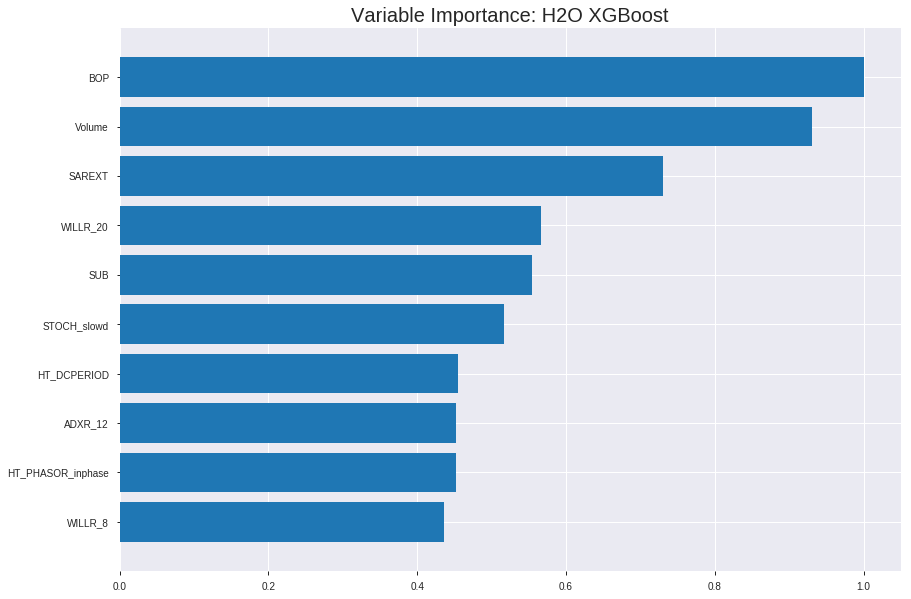

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_031934_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17158696105774957
RMSE: 0.4142305650935836
LogLoss: 0.5306687064050476
Mean Per-Class Error: 0.13622406529404774
AUC: 0.9382214173457124
pr_auc: 0.937716185551907
Gini: 0.8764428346914248
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5042556822299957: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      608  138  0.185    (138.0/746.0)
1      78   734  0.0961   (78.0/812.0)
Total  686  872  0.1386   (216.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504256     0.871734  211
max f2                       0.467239     0.916784  242
max f0point5                 0.558882     0.886628  163
max accuracy                 0.524283     0.863286  193
max precision                0.784635     1         0
max recall                   0.363992     1         326
max specificity              0.784635     1         0
max absolute_mcc             0.524283     0.72692   193
max min_per_class_accuracy   0.521608     0.860837  196
max mean_per_class_accuracy  0.524283     0.863776  193

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.08 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.752058           1.91872    1.91872            1                0.768228  1                           0.768228            0.0197044       0.0197044                  91.8719   91.8719
    2        0.0205392                   0.739318           1.91872    1.91872            1                0.744523  1                           0.756376            0.0197044       0.0394089                  91.8719   91.8719
    3        0.0301669                   0.726848           1.91872    1.91872            1                0.732526  1                           0.748764            0.0184729       0.0578818                  91.8719   91.8719
    4        0.0404365                   0.720733           1.91872    1.91872            1                0.723831  1                           0.742432            0.0197044       0.0775862                  91.8719   91.8719
    5        0.0500642                   0.714963           1.7908     1.89412            0.933333         0.718196  0.987179                    0.737771            0.0172414       0.0948276                  79.0805   89.412
    6        0.100128                    0.683551           1.89412    1.89412            0.987179         0.696856  0.987179                    0.717313            0.0948276       0.189655                   89.412    89.412
    7        0.150193                    0.660716           1.84492    1.87772            0.961538         0.671323  0.978632                    0.701983            0.0923645       0.28202                    84.4922   87.7721
    8        0.200257                    0.642623           1.84492    1.86952            0.961538         0.651799  0.974359                    0.689437            0.0923645       0.374384                   84.4922   86.9521
    9        0.300385                    0.603197           1.82032    1.85312            0.948718         0.622098  0.965812                    0.666991            0.182266        0.55665                    82.0323   85.3122
    10       0.399872                    0.568535           1.60925    1.79245            0.83871          0.586851  0.934189                    0.647053            0.160099        0.716749                   60.9248   79.2447
    11       0.5                         0.525609           1.30375    1.69458            0.679487         0.546929  0.883184                    0.627002            0.130542        0.847291                   30.3745   69.4581
    12       0.600128                    0.48801            0.824065   1.54934            0.429487         0.507108  0.807487                    0.606998            0.0825123       0.929803                   -17.5935  54.934
    13       0.699615                    0.442814           0.470396   1.39591            0.245161         0.464019  0.727523                    0.586666            0.046798        0.976601                   -52.9604  39.5912
    14       0.799743                    0.400819           0.159893   1.24116            0.0833333        0.421757  0.64687                     0.56602             0.0160099       0.992611                   -84.0107  24.1162
    15       0.899872                    0.351709           0.0737969  1.11127            0.0384615        0.377906  0.579173                    0.545088            0.00738916      1                          -92.6203  11.127
    16       1                           0.177305           0          1                  0                0.302117  0.521181                    0.5



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2520727447928529
RMSE: 0.5020684662402658
LogLoss: 0.6977340059733711
Mean Per-Class Error: 0.4674939467312349
AUC: 0.5305589184826472
pr_auc: 0.5397376231247192
Gini: 0.06111783696529449
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35817527770996094: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   199  0.9476   (199.0/210.0)
1      3    233  0.0127   (3.0/236.0)
Total  14   432  0.4529   (202.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358175     0.697605  385
max f2                       0.282952     0.849532  398
max f0point5                 0.400331     0.596652  357
max accuracy                 0.400331     0.556054  357
max precision                0.750236     1         0
max recall                   0.282952     1         398
max specificity              0.750236     1         0
max absolute_mcc             0.358175     0.113556  385
max min_per_class_accuracy   0.525921     0.525424  203
max mean_per_class_accuracy  0.400331     0.532506  357

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.714742           1.1339    1.1339             0.6              0.72676   0.6                         0.72676             0.0127119       0.0127119                  13.3898   13.3898
    2        0.0201794                   0.689326           0.944915  1.04991            0.5              0.700791  0.555556                    0.715219            0.00847458      0.0211864                  -5.50847  4.99058
    3        0.0313901                   0.683406           0.755932  0.944915           0.4              0.685926  0.5                         0.704757            0.00847458      0.029661                   -24.4068  -5.50847
    4        0.0403587                   0.672197           0.472458  0.839925           0.25             0.679195  0.444444                    0.699077            0.00423729      0.0338983                  -52.7542  -16.0075
    5        0.0515695                   0.666913           1.1339    0.903832           0.6              0.669431  0.478261                    0.692632            0.0127119       0.0466102                  13.3898   -9.6168
    6        0.100897                    0.6387             0.944915  0.923917           0.5              0.653249  0.488889                    0.673378            0.0466102       0.0932203                  -5.50847  -7.60829
    7        0.150224                    0.619293           1.03082   0.959018           0.545455         0.627976  0.507463                    0.65847             0.0508475       0.144068                   3.08166   -4.09815
    8        0.201794                    0.60378            1.2325    1.02891            0.652174         0.61137   0.544444                    0.646433            0.0635593       0.207627                   23.2498   2.89077
    9        0.300448                    0.573482           1.11672   1.05774            0.590909         0.588321  0.559701                    0.627351            0.110169        0.317797                   11.6718   5.7741
    10       0.401345                    0.550182           1.00791   1.04521            0.533333         0.561665  0.553073                    0.610838            0.101695        0.419492                   0.79096   4.52135
    11       0.5                         0.525436           1.07377   1.05085            0.568182         0.536088  0.556054                    0.596089            0.105932        0.525424                   7.37673   5.08475
    12       0.600897                    0.497468           0.965913  1.03659            0.511111         0.510597  0.548507                    0.581734            0.0974576       0.622881                   -3.40866  3.65861
    13       0.699552                    0.467467           1.03082   1.03577            0.545455         0.482965  0.548077                    0.567805            0.101695        0.724576                   3.08166   3.57725
    14       0.800448                    0.445627           0.881921  1.01638            0.466667         0.457412  0.537815                    0.55389             0.0889831       0.813559                   -11.8079  1.63794
    15       0.899103                    0.404479           1.15967   1.0321             0.613636         0.426508  0.546135                    0.539913            0.114407        0.927966                   15.9669   3.21019
    16       1                           0.268664           0.713936  1                  0.377778         0.364589  0.529148                    0.522223      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:19:58  7.270 sec   0                  0.5              0.693147            0.5             0                  1                0.478819                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 03:19:59  8.440 sec   5                  0.488327         0.670018            0.761984        0.761408           1.81212          0.327985                         0.498896           0.69094               0.530145          0.531065             1.1339             0.457399
    2019-09-03 03:19:59  8.799 sec   10                 0.476958         0.647833            0.808365        0.807859           1.7988           0.295892                         0.498395           0.689947              0.53634           0.535598             0.755932           0.466368
    2019-09-03 03:20:00  9.148 sec   15                 0.468669         0.631889            0.848045        0.845557           1.7988           0.247754                         0.497688           0.688497              0.545097          0.556172             1.1339             0.452915
    2019-09-03 03:20:00  9.487 sec   20                 0.45953          0.614433            0.867968        0.863856           1.7988           0.208601                         0.498831           0.690844              0.537994          0.544376             0.755932           0.464126
    2019-09-03 03:20:00  9.842 sec   25                 0.451194         0.598707            0.889176        0.89016            1.7988           0.188703                         0.499444           0.692111              0.53185           0.538683             1.1339             0.441704
    2019-09-03 03:20:01  10.195 sec  30                 0.442048         0.581563            0.900194        0.900818           1.91872          0.191271                         0.499025           0.691313              0.541021          0.544002             1.1339             0.450673
    2019-09-03 03:20:01  10.545 sec  35                 0.435539         0.56943             0.910744        0.913219           1.91872          0.175866                         0.499594           0.692487              0.536098          0.542578             1.51186            0.450673
    2019-09-03 03:20:02  10.919 sec  40                 0.426517         0.552782            0.921158        0.923793           1.91872          0.154044                         0.501027           0.695502              0.532587          0.541564             1.1339             0.464126
    2019-09-03 03:20:02  11.275 sec  45                 0.420514         0.541982            0.931057        0.932213           1.91872          0.143132                         0.501758           0.697064              0.528803          0.536498             1.51186            0.461883
    2019-09-03 03:20:02  11.635 sec  50                 0.414231         0.530669            0.938221        0.937716           1.91872          0.138639                         0.502068           0.697734              0.530559          0.539738             1.1339             0.452915

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      141.3075714111328      1.0                    0.024701903576329905
Volume                   131.5123748779297      0.9306817289732897     0.022989610329350204
SAREXT                   103.15584564208984     0.7300093307948734     0.018032620099116083
WILLR_20                 79.95341491699219      0.565811259216738      0.013976615167573668
SUB                      78.27462005615234      0.5539308281536678     0.013683145905008472
---                      ---                    ---                    ---
BBANDS_upperband_12_2_5  1.2717914581298828     0.0090001649977383     0.00022232120794519095
BBANDS_lowerband_20_0_2  1.2510929107666016     0.008853686311871858   0.00021870290557093056
month                    1.0139703750610352     0.0071756266485601084  0.0001772516375724751
BBANDS_upperband_12_7_4  0.8065605163574219     0.0057078365179084635  0.0001409944272948295
BBANDS_upperband_20_1_3  0.08592987060546875    0.0006081052115421101  1.5021356299776903e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.6560509554140127)

('auc', 0.5753026634382566)

('logloss', 0.6891928634291755)

('mean_per_class_error', 0.4351896690879742)

('rmse', 0.4979952155666102)

('mse', 0.24799923472723456)

xgboost prediction progress: |████████████████████████████████████████████| 100%


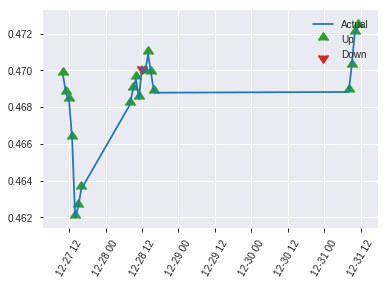


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24799923472723456
RMSE: 0.4979952155666102
LogLoss: 0.6891928634291755
Mean Per-Class Error: 0.4351896690879742
AUC: 0.5753026634382566
pr_auc: 0.5342567191940958
Gini: 0.1506053268765133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37301957607269287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   106  0.8983   (106.0/118.0)
1      2    103  0.019    (2.0/105.0)
Total  14   209  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37302      0.656051  208
max f2                       0.361982     0.821485  212
max f0point5                 0.469218     0.548697  155
max accuracy                 0.592459     0.573991  57
max precision                0.717992     1         0
max recall                   0.340125     1         219
max specificity              0.717992     1         0
max absolute_mcc             0.37302      0.17007   208
max min_per_class_accuracy   0.521407     0.542373  110
max mean_per_class_accuracy  0.504774     0.56481   126

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.700483           2.12381   2.12381            1                0.710347  1                           0.710347            0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.694252           0         1.27429            0                0.695139  0.6                         0.704264            0               0.0285714                  -100      27.4286
    3        0.0313901                   0.691415           1.0619    1.21361            0.5              0.693479  0.571429                    0.701182            0.00952381      0.0380952                  6.19048   21.3605
    4        0.0403587                   0.67354            1.0619    1.17989            0.5              0.686079  0.555556                    0.697826            0.00952381      0.047619                   6.19048   17.9894
    5        0.0538117                   0.669808           1.41587   1.23889            0.666667         0.671466  0.583333                    0.691236            0.0190476       0.0666667                  41.5873   23.8889
    6        0.103139                    0.650073           1.35152   1.29275            0.636364         0.657434  0.608696                    0.67507             0.0666667       0.133333                   35.1515   29.2754
    7        0.152466                    0.631256           1.15844   1.2493             0.545455         0.638844  0.588235                    0.66335             0.0571429       0.190476                   15.8442   24.93
    8        0.201794                    0.618373           0.965368  1.17989            0.454545         0.624346  0.555556                    0.653816            0.047619        0.238095                   -3.4632   17.9894
    9        0.300448                    0.578774           1.15844   1.17285            0.545455         0.594723  0.552239                    0.634412            0.114286        0.352381                   15.8442   17.285
    10       0.399103                    0.555365           0.965368  1.12156            0.454545         0.566589  0.52809                     0.617647            0.0952381       0.447619                   -3.4632   12.1562
    11       0.502242                    0.519402           0.923395  1.08087            0.434783         0.534212  0.508929                    0.600513            0.0952381       0.542857                   -7.66046  8.08673
    12       0.600897                    0.499767           1.15844   1.0936             0.545455         0.507922  0.514925                    0.585311            0.114286        0.657143                   15.8442   9.36034
    13       0.699552                    0.469125           1.0619    1.08913            0.5              0.483079  0.512821                    0.570894            0.104762        0.761905                   6.19048   8.91331
    14       0.798206                    0.44678            0.579221  1.02611            0.272727         0.459766  0.483146                    0.557159            0.0571429       0.819048                   -42.0779  2.61102
    15       0.896861                    0.395084           1.0619    1.03005            0.5              0.417656  0.485                       0.541814            0.104762        0.92381                    6.19048   3.00476
    16       1                           0.327915           0.738716  1                  0.347826         0.365124  0.470852                    0.52359             

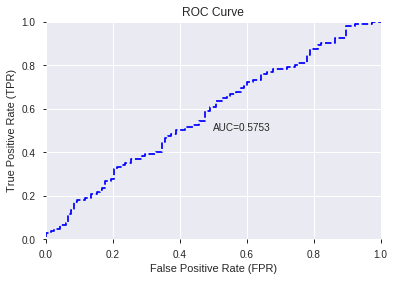

This function is available for GLM models only


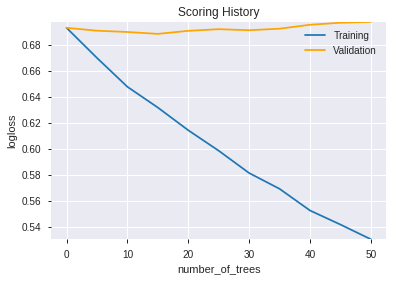

--2019-09-03 03:20:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_031934_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_031934_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'Volume',
 'SAREXT',
 'WILLR_20',
 'SUB',
 'STOCH_slowd',
 'HT_DCPERIOD',
 'ADXR_12',
 'HT_PHASOR_inphase',
 'WILLR_8',
 'STOCHRSI_fastk',
 'PLUS_DM_24',
 'PLUS_DI_30',
 'HT_PHASOR_quadrature',
 'MFI_30',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'STDDEV_20',
 'BBANDS_upperband_20_0_5',
 'DX_20',
 'dayofyear',
 'BETA_14',
 'PLUS_DI_8',
 'ADX_8',
 'NATR_20',
 'WILLR_14',
 'BBANDS_lowerband_14_0_5',
 'CORREL_30',
 'ROC_24',
 'PLUS_DM_14',
 'PLUS_DI_20',
 'aroonup_20',
 'aroondown_30',
 'VAR_20',
 'ADXR_14',
 'CCI_20',
 'BETA_30',
 'ROC_12',
 'STDDEV_24',
 'DIV',
 'DX_12',
 'MACDEXT_hist',
 'MACDFIX_hist_14',
 'LINEARREG_SLOPE_30',
 'BETA_20',
 'MFI_12',
 'PLUS_DM_20',
 'PLUS_DI_14',
 'dayofweek',
 'MINUS_DM_8',
 'AROONOSC_14',
 'CORREL_24',
 'BBANDS_lowerband_12_6_5',
 'ROC_20',
 'aroonup_30',
 'TRANGE',
 'LINEARREG_ANGLE_8',
 'LINEARREG_ANGLE_30',
 'CMO_24',
 'BBANDS_lowerband_14_1_2',
 'TRIX_12',
 'aroondown_20',
 'DX_8',
 'AROONOSC_20',
 'CCI_24',
 'CCI_30',
 'LINEARREG_INTERCEPT_

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

59

['BBANDS_upperband_14_4_4',
 'BBANDS_lowerband_14_4_5',
 'MAVP_20_5',
 'BBANDS_lowerband_20_5_4',
 'MA_20_7',
 'BBANDS_lowerband_30_0_2',
 'BOP',
 'aroondown_8',
 'MOM_8',
 'aroonup_12',
 'CCI_12',
 'CMO_12',
 'MFI_12',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'ROC_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'ADXR_14',
 'aroondown_14',
 'aroonup_14',
 'AROONOSC_14',
 'MINUS_DI_14',
 'MOM_14',
 'ROC_14',
 'ROCR_14',
 'DX_20',
 'MACDFIX_hist_20',
 'MINUS_DI_20',
 'ROCP_20',
 'ROCP_24',
 'RSI_24',
 'WILLR_24',
 'aroondown_30',
 'CCI_30',
 'MINUS_DI_30',
 'PLUS_DI_30',
 'ROCP_30',
 'RSI_30',
 'MACDEXT',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'ATR_8',
 'ATR_12',
 'ATR_14',
 'ATR_20',
 'NATR_20',
 'NATR_24',
 'ATR_30',
 'TRANGE',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLSPINNINGTOP',
 'VAR_8',
 'BETA_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_032139_model_7  0.599031  0.686193              0.460250  0.496349  0.246362
1               DeepLearning_1_AutoML_20190903_032139  0.586925  0.710886              0.479338  0.504093  0.254109
2  DeepLearning_grid_1_AutoML_20190903_032139_model_2  0.549153  0.965971              0.500000  0.562891  0.316847
3  DeepLearning_grid_1_AutoML_20190903_032139_model_6  0.548103  0.730599              0.471913  0.515363  0.265599
4  DeepLearning_grid_1_AutoML_20190903_032139_model_3  0.547619  0.948254              0.491525  0.556565  0.309765
5  DeepLearning_grid_1_AutoML_20190903_032139_model_4  0.545843  0.896565              0.492050  0.553813  0.306709
6  DeepLearning_grid_1_AutoML_20190903_032139_model_5  0.533333  0.704774              0.468725  0.505076  0.255101
7  DeepLearning_grid_1_AutoML_20190903_032139_model_9  0.527199  0.687418              0.466102  0.497253  0.247261
8  DeepLearning_grid_1_AutoML_20190903_032139_model_1  0.524536  1.986424              0.495763  0.642217  0.412442
9  DeepLearning_grid_1_AutoML_20190903_032139_model_8  0.524092  0.694468              0.466102  0.500636  0.250636

variable  relative_importance  scaled_importance  percentage
0            STOCHRSI_fastk             1.000000           1.000000    0.018293
1                    RSI_30             0.978746           0.978746    0.017904
2                     VAR_8             0.967617           0.967617    0.017701
3                     ATR_8             0.962384           0.962384    0.017605
4                aroonup_12             0.960679           0.960679    0.017574
5               aroondown_8             0.960449           0.960449    0.017570
6               MINUS_DI_30             0.953946           0.953946    0.017451
7                  WILLR_12             0.952673           0.952673    0.017427
8              aroondown_14             0.951823           0.951823    0.017412
9                    MOM_14             0.951184           0.951184    0.017400
10                  MACDEXT             0.947966           0.947966    0.017341
11  BBANDS_lowerband_14_4_5             0.946619           0.946619    0.017317
12                MAVP_20_5             0.945965           0.945965    0.017305
13               PLUS_DI_30             0.945795           0.945795    0.017302
14        HT_PHASOR_inphase             0.945609           0.945609    0.017298
15                   RSI_24             0.944583           0.944583    0.017279
16                  NATR_20             0.943473           0.943473    0.017259
17                   ROC_14             0.943331           0.943331    0.017256
18  BBANDS_lowerband_30_0_2             0.941704           0.941704    0.017227
19             aroondown_30             0.941162           0.941162    0.017217
20     HT_PHASOR_quadrature             0.939846           0.939846    0.017193
21                   CCI_12             0.939237           0.939237    0.017182
22                   TRANGE             0.937265           0.937265    0.017146
23                    DX_20             0.935880           0.935880    0.017120
24  BBANDS_upperband_14_4_4             0.934602           0.934602    0.017097
25                  ROCP_24             0.933927           0.933927    0.017084
26  BBANDS_lowerband_20_5_4             0.933542           0.933542    0.017077
27                   ROC_12             0.929865           0.929865    0.017010
28                  ROCP_30             0.926770           0.926770    0.016954
29                    ADOSC             0.926020           0.926020    0.016940
30              AROONOSC_14             0.923810           0.923810    0.016899
31                   CCI_30             0.923604           0.923604    0.016896
32               PLUS_DI_12             0.922646           0.922646    0.016878
33                  NATR_24             0.921698           0.921698    0.016861
34                   RSI_12             0.920844           0.920844    0.016845
35                 WILLR_24             0.918785           0.918785    0.016807
36           CDLSPINNINGTOP             0.916488           0.916488    0.016765
37                      BOP             0.915681           0.915681    0.016751
38                    MOM_8             0.915617           0.915617    0.016750
39                  MA_20_7             0.915563           0.915563    0.016749
40          MACDFIX_hist_20             0.911983           0.911983    0.016683
41                  BETA_12             0.911676           0.911676    0.016677
42                  ADXR_14             0.911455           0.911455    0.016673
43              MINUS_DI_14             0.910634           0.910634    0.016658
44                   ULTOSC             0.907074           0.907074    0.016593
45              MINUS_DI_12             0.904869           0.904869    0.016553
46              MINUS_DI_20             0.904606           0.904606    0.016548
47                   MFI_12             0.903849           0.903849    0.016534
48                   CMO_12             0.902506           0.902506    0.016510
49                 

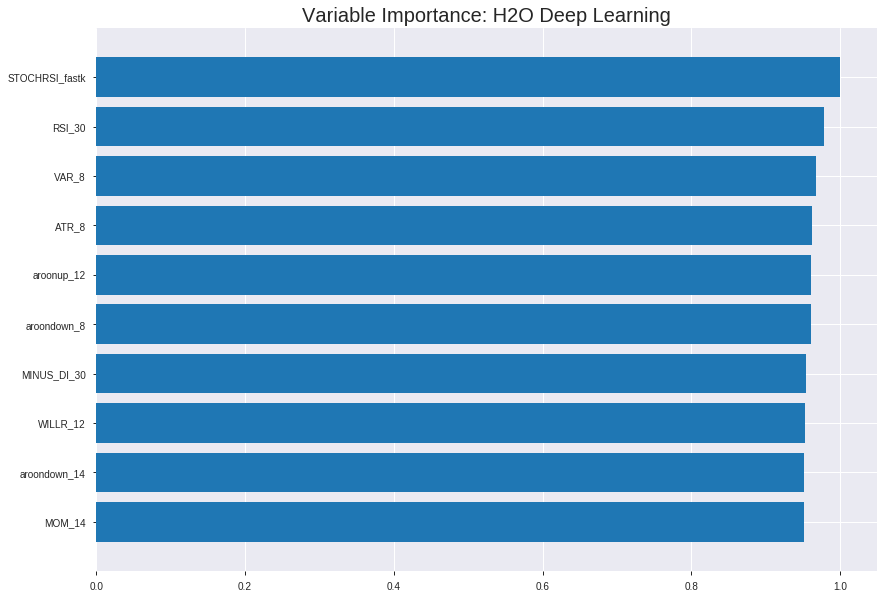

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_032139_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2461481806199161
RMSE: 0.4961332286996267
LogLoss: 0.684821620630609
Mean Per-Class Error: 0.3999689641965689
AUC: 0.6440325413700656
pr_auc: 0.6428969327792874
Gini: 0.2880650827401312
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.303116690532506: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      151  595   0.7976   (595.0/746.0)
1      52   760   0.064    (52.0/812.0)
Total  203  1355  0.4153   (647.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303117     0.701431  312
max f2                       0.155217     0.847263  383
max f0point5                 0.379381     0.619943  244
max accuracy                 0.385515     0.602696  236
max precision                0.777135     0.8       13
max recall                   0.070096     1         395
max specificity              0.859006     0.99866   0
max absolute_mcc             0.318552     0.211442  301
max min_per_class_accuracy   0.399341     0.591153  217
max mean_per_class_accuracy  0.394355     0.600031  223

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 41.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.771521           1.43904   1.43904            0.75             0.805687  0.75                        0.805687            0.0147783       0.0147783                  43.9039   43.9039
    2        0.0205392                   0.72746            1.31912   1.37908            0.6875           0.747307  0.71875                     0.776497            0.0135468       0.0283251                  31.9119   37.9079
    3        0.0301669                   0.690944           1.40706   1.38801            0.733333         0.710369  0.723404                    0.755393            0.0135468       0.0418719                  40.7061   38.801
    4        0.0404365                   0.665899           1.7988    1.49234            0.9375           0.678407  0.777778                    0.735841            0.0184729       0.0603448                  79.8799   49.2337
    5        0.0500642                   0.635581           1.15123   1.42674            0.6              0.648979  0.74359                     0.719137            0.0110837       0.0714286                  15.1232   42.674
    6        0.100128                    0.561165           1.32834   1.37754            0.692308         0.592538  0.717949                    0.655837            0.0665025       0.137931                   32.8344   37.7542
    7        0.150193                    0.507819           1.35294   1.36934            0.705128         0.533603  0.713675                    0.615092            0.067734        0.205665                   35.2943   36.9342
    8        0.200257                    0.473279           1.40214   1.37754            0.730769         0.490065  0.717949                    0.583836            0.070197        0.275862                   40.2141   37.7542
    9        0.300385                    0.432931           1.05776   1.27095            0.551282         0.450561  0.662393                    0.539411            0.105911        0.381773                   5.77555   27.0946
    10       0.399872                    0.410932           1.0522    1.21652            0.548387         0.421818  0.634029                    0.510154            0.10468         0.486453                   5.22009   21.6523
    11       0.5                         0.399678           1.02086   1.17734            0.532051         0.404852  0.613607                    0.489067            0.102217        0.58867                    2.0857    17.734
    12       0.600128                    0.388443           0.983959  1.14508            0.512821         0.394286  0.596791                    0.473253            0.0985222       0.687192                   -1.60414  14.5075
    13       0.699615                    0.369591           0.965549  1.11955            0.503226         0.38029   0.583486                    0.460033            0.0960591       0.783251                   -3.4451   11.9546
    14       0.799743                    0.338843           0.934761  1.09641            0.487179         0.355936  0.571429                    0.447               0.0935961       0.876847                   -6.52394  9.6411
    15       0.899872                    0.271311           0.71337   1.05379            0.371795         0.313708  0.549215                    0.432169            0.0714286       0.948276                   -28.663   5.37902
    16       1                           0.0449093          0.516578  1                  0.269231         0.211651  0.521181                    0.410089            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2673645098381184
RMSE: 0.5170730217658995
LogLoss: 0.7302283114429506
Mean Per-Class Error: 0.46277239709443097
AUC: 0.5267453591606134
pr_auc: 0.5479089554144552
Gini: 0.05349071832122676
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19497979676370947: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    210  1        (210.0/210.0)
1      0    236  0        (0.0/236.0)
Total  0    446  0.4709   (210.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.19498      0.692082   399
max f2                       0.19498      0.848921   399
max f0point5                 0.331792     0.594406   325
max accuracy                 0.332191     0.556054   324
max precision                0.694653     0.75       3
max recall                   0.19498      1          399
max specificity              0.766001     0.995238   0
max absolute_mcc             0.287846     0.0982697  362
max min_per_class_accuracy   0.400344     0.504762   199
max mean_per_class_accuracy  0.332191     0.537228   324

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 40.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.678053           1.1339    1.1339             0.6              0.715248  0.6                         0.715248            0.0127119       0.0127119                  13.3898   13.3898
    2        0.0201794                   0.63873            1.41737   1.25989            0.75             0.654775  0.666667                    0.688371            0.0127119       0.0254237                  41.7373   25.9887
    3        0.0313901                   0.612582           0.755932  1.0799             0.4              0.62528   0.571429                    0.665838            0.00847458      0.0338983                  -24.4068  7.99031
    4        0.0403587                   0.589907           1.41737   1.1549             0.75             0.597164  0.611111                    0.650577            0.0127119       0.0466102                  41.7373   15.4896
    5        0.0515695                   0.585519           0.377966  0.985999           0.2              0.587057  0.521739                    0.636769            0.00423729      0.0508475                  -62.2034  -1.40015
    6        0.100897                    0.527968           1.20262   1.0919             0.636364         0.555006  0.577778                    0.596796            0.059322        0.110169                   20.2619   9.19021
    7        0.150224                    0.496679           1.11672   1.10005            0.590909         0.51178   0.58209                     0.56888             0.0550847       0.165254                   11.6718   10.0051
    8        0.201794                    0.467705           0.821665  1.02891            0.434783         0.481786  0.544444                    0.546623            0.0423729       0.207627                   -17.8335  2.89077
    9        0.300448                    0.438653           0.944915  1.00133            0.5              0.451837  0.529851                    0.515499            0.0932203       0.300847                   -5.50847  0.132811
    10       0.401345                    0.413096           1.1339    1.03466            0.6              0.425721  0.547486                    0.492929            0.114407        0.415254                   13.3898   3.46558
    11       0.5                         0.400344           0.901965  1.00847            0.477273         0.405725  0.533632                    0.475723            0.0889831       0.504237                   -9.80354  0.847458
    12       0.600897                    0.385366           1.00791   1.00838            0.533333         0.393742  0.533582                    0.461957            0.101695        0.605932                   0.79096   0.837971
    13       0.699552                    0.361194           1.15967   1.02972            0.613636         0.37566   0.544872                    0.449787            0.114407        0.720339                   15.9669   2.97153
    14       0.800448                    0.342435           1.0919    1.03755            0.577778         0.351337  0.54902                     0.437378            0.110169        0.830508                   9.19021   3.7554
    15       0.899103                    0.294708           0.944915  1.02739            0.5              0.321331  0.543641                    0.424644            0.0932203       0.923729                   -5.50847  2.73892
    16       1                           0.19498            0.755932  1                  0.4              0.256368  0.529148                    0.407666      


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:25:33  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:25:38  5.321 sec   234 obs/sec       0.664955  1             1036       0.661034         1.63401             -0.751008      0.569927        0.581373           1.1992           0.468549                         0.681653           1.77323               -0.864939        0.493362          0.510484             0.755932           0.466368
    2019-09-03 03:25:47  14.969 sec  463 obs/sec       3.94031   6             6139       0.496133         0.684822            0.0136372      0.644033        0.642897           1.43904          0.415276                         0.517073           0.730228              -0.0731049       0.526745          0.547909             1.1339             0.470852
    2019-09-03 03:25:56  23.305 sec  539 obs/sec       7.19576   11            11211      0.658959         1.35799             -0.74003       0.697041        0.69728            1.7988           0.396021                         0.671491           1.44765               -0.809749        0.489558          0.521348             0.755932           0.46861
    2019-09-03 03:26:04  31.612 sec  581 obs/sec       10.5398   16            16421      0.462598         0.619801            0.142473       0.71826         0.708993           1.55896          0.367137                         0.536049           0.806171              -0.153313        0.523961          0.545357             0.755932           0.46861
    2019-09-03 03:26:12  40.055 sec  602 obs/sec       13.8607   21            21595      0.55791          0.888727            -0.247294      0.758346        0.754171           1.67888          0.344673                         0.622532           1.22148               -0.555468        0.553117          0.568465             1.1339             0.439462
    2019-09-03 03:26:22  49.600 sec  624 obs/sec       17.8601   27            27826      0.432357         0.55152             0.250925       0.801013        0.800211           1.91872          0.313864                         0.552087           0.889443              -0.223359        0.529782          0.568195             1.1339             0.461883
    2019-09-03 03:26:31  58.919 sec  640 obs/sec       21.8145   33            33987      0.429047         0.553482            0.26235        0.810029        0.799821           1.7988           0.287548                         0.554234           0.98613               -0.232893        0.553632          0.563022             0.755932           0.44843
    2019-09-03 03:26:32  59.770 sec  639 obs/sec       21.8145   33            33987      0.496133         0.684822            0.0136372      0.644033        0.642897           1.43904          0.415276                         0.517073           0.730228              -0.0731049       0.526745          0.547909             1.1339             0.470852

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
STOCHRSI_fastk  1.0                    1.0                  0.01829315201961191
RSI_30          0.9787458777427673     0.9787458777427673   0.017904347130116936
VAR_8           0.967616856098175      0.967616856098175    0.017700762245342855
ATR_8           0.9623842835426331     0.9623842835426331   0.017605042000130678
aroonup_12      0.9606789946556091     0.9606789946556091   0.017573846891282992
---             ---                    ---                  ---
PLUS_DM_12      0.8878747224807739     0.8878747224807739   0.016242027272711533
ATR_12          0.8803526759147644     0.8803526759147644   0.01610442533138092
ROCR_12         0.8797532916069031     0.8797532916069031   0.016093460703119043
ROCR_14         0.8766220808029175     0.8766220808029175   0.016036180987876285
ROCR100_12      0.8659558296203613     0.8659558296203613   0.015841061633514418


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6143497757847534)

('F1', 0.6493506493506493)

('auc', 0.5990314769975786)

('logloss', 0.686192526011228)

('mean_per_class_error', 0.38696529459241324)

('rmse', 0.4963486979149359)

('mse', 0.2463620299218523)

deeplearning prediction progress: |███████████████████████████████████████| 100%


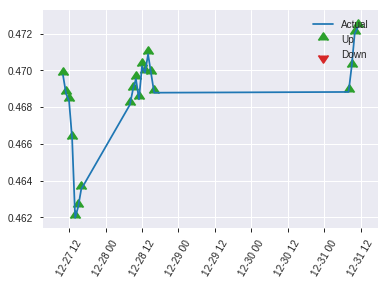


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2463620299218523
RMSE: 0.4963486979149359
LogLoss: 0.686192526011228
Mean Per-Class Error: 0.38696529459241324
AUC: 0.5990314769975786
pr_auc: 0.5479704885051679
Gini: 0.19806295399515728
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29059377574561585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   103  0.8729   (103.0/118.0)
1      5    100  0.0476   (5.0/105.0)
Total  20   203  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290594     0.649351  202
max f2                       0.22504      0.820313  219
max f0point5                 0.414455     0.590476  104
max accuracy                 0.414455     0.61435   104
max precision                0.568232     0.7       9
max recall                   0.22504      1         219
max specificity              0.720062     0.991525  0
max absolute_mcc             0.414455     0.226069  104
max min_per_class_accuracy   0.414455     0.590476  104
max mean_per_class_accuracy  0.414455     0.613035  104

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 41.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.628377           1.41587   1.41587            0.666667         0.67104   0.666667                    0.67104             0.0190476       0.0190476                  41.5873   41.5873
    2        0.0224215                   0.608715           0         0.849524           0                0.624221  0.4                         0.652313            0               0.0190476                  -100      -15.0476
    3        0.0313901                   0.580913           2.12381   1.21361            1                0.587926  0.571429                    0.633916            0.0190476       0.0380952                  112.381   21.3605
    4        0.0403587                   0.568691           2.12381   1.41587            1                0.576075  0.666667                    0.621063            0.0190476       0.0571429                  112.381   41.5873
    5        0.0538117                   0.565892           1.41587   1.41587            0.666667         0.567094  0.666667                    0.607571            0.0190476       0.0761905                  41.5873   41.5873
    6        0.103139                    0.534376           0.965368  1.20041            0.454545         0.551616  0.565217                    0.58081             0.047619        0.12381                    -3.4632   20.0414
    7        0.152466                    0.506902           1.35152   1.2493             0.636364         0.520868  0.588235                    0.561417            0.0666667       0.190476                   35.1515   24.93
    8        0.201794                    0.476142           1.15844   1.22709            0.545455         0.490117  0.577778                    0.543988            0.0571429       0.247619                   15.8442   22.709
    9        0.300448                    0.449466           1.15844   1.20455            0.545455         0.462446  0.567164                    0.517213            0.114286        0.361905                   15.8442   20.4549
    10       0.399103                    0.426961           1.35152   1.24088            0.636364         0.436723  0.58427                     0.497317            0.133333        0.495238                   35.1515   24.0877
    11       0.502242                    0.40818            0.923395  1.17568            0.434783         0.416656  0.553571                    0.480752            0.0952381       0.590476                   -7.66046  17.568
    12       0.600897                    0.396558           0.579221  1.07775            0.272727         0.40191   0.507463                    0.467808            0.0571429       0.647619                   -42.0779  7.77541
    13       0.699552                    0.369011           1.15844   1.08913            0.545455         0.384347  0.512821                    0.456038            0.114286        0.761905                   15.8442   8.91331
    14       0.798206                    0.335437           1.0619    1.08577            0.5              0.352225  0.511236                    0.443207            0.104762        0.866667                   6.19048   8.57678
    15       0.896861                    0.296361           0.772294  1.05129            0.363636         0.321116  0.495                       0.429777            0.0761905       0.942857                   -22.7706  5.12857
    16       1                           0.201874           0.554037  1                  0.26087          0.259166  0.470852                    0.412181            

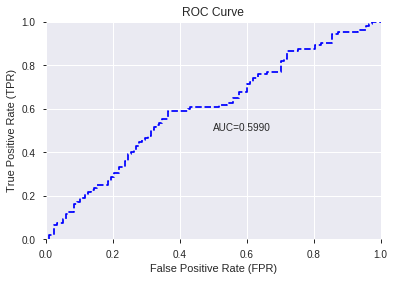

This function is available for GLM models only


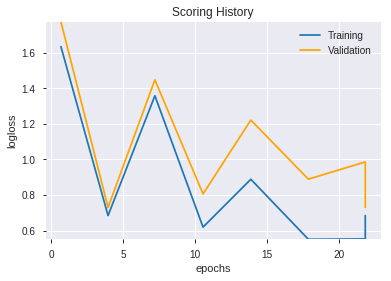

--2019-09-03 03:28:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_032139_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_032139_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHRSI_fastk',
 'RSI_30',
 'VAR_8',
 'ATR_8',
 'aroonup_12',
 'aroondown_8',
 'MINUS_DI_30',
 'WILLR_12',
 'aroondown_14',
 'MOM_14',
 'MACDEXT',
 'BBANDS_lowerband_14_4_5',
 'MAVP_20_5',
 'PLUS_DI_30',
 'HT_PHASOR_inphase',
 'RSI_24',
 'NATR_20',
 'ROC_14',
 'BBANDS_lowerband_30_0_2',
 'aroondown_30',
 'HT_PHASOR_quadrature',
 'CCI_12',
 'TRANGE',
 'DX_20',
 'BBANDS_upperband_14_4_4',
 'ROCP_24',
 'BBANDS_lowerband_20_5_4',
 'ROC_12',
 'ROCP_30',
 'ADOSC',
 'AROONOSC_14',
 'CCI_30',
 'PLUS_DI_12',
 'NATR_24',
 'RSI_12',
 'WILLR_24',
 'CDLSPINNINGTOP',
 'BOP',
 'MOM_8',
 'MA_20_7',
 'MACDFIX_hist_20',
 'BETA_12',
 'ADXR_14',
 'MINUS_DI_14',
 'ULTOSC',
 'MINUS_DI_12',
 'MINUS_DI_20',
 'MFI_12',
 'CMO_12',
 'ATR_20',
 'ROCP_20',
 'aroonup_14',
 'ATR_30',
 'ATR_14',
 'PLUS_DM_12',
 'ATR_12',
 'ROCR_12',
 'ROCR_14',
 'ROCR100_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190903_032828_model_1  0.541001  0.694483              0.478814  0.500669  0.25067

variable  relative_importance  scaled_importance  percentage
0                     DX_20             0.015299           1.000000    0.049402
1            STOCHRSI_fastk             0.014942           0.976624    0.048247
2                   ADXR_14             0.014596           0.953998    0.047129
3                  WILLR_12             0.014530           0.949711    0.046917
4         HT_PHASOR_inphase             0.014302           0.934821    0.046182
5                       BOP             0.014057           0.918819    0.045391
6                    TRANGE             0.013511           0.883129    0.043628
7           MACDFIX_hist_20             0.013273           0.867528    0.042857
8                  WILLR_24             0.012776           0.835092    0.041255
9                PLUS_DI_30             0.012142           0.793637    0.039207
10           CDLSPINNINGTOP             0.009760           0.637949    0.031516
11                    MOM_8             0.009748           0.637129    0.031475
12                   MFI_12             0.008948           0.584855    0.028893
13             aroondown_14             0.008474           0.553890    0.027363
14                   RSI_30             0.007993           0.522451    0.025810
15               aroonup_12             0.007724           0.504822    0.024939
16                   CCI_30             0.007447           0.486752    0.024046
17                   RSI_24             0.007273           0.475398    0.023486
18                   CMO_12             0.005488           0.358730    0.017722
19                   RSI_12             0.005476           0.357914    0.017682
20                  BETA_12             0.005400           0.352963    0.017437
21                  ROCP_20             0.005332           0.348491    0.017216
22  BBANDS_upperband_14_4_4             0.005084           0.332298    0.016416
23               aroonup_14             0.005019           0.328073    0.016207
24              aroondown_8             0.004928           0.322119    0.015913
25               PLUS_DI_12             0.004706           0.307606    0.015196
26                    VAR_8             0.004392           0.287065    0.014182
27              MINUS_DI_30             0.003638           0.237780    0.011747
28                  ROCP_24             0.003502           0.228921    0.011309
29                   CCI_12             0.003352           0.219087    0.010823
30             aroondown_30             0.003270           0.213718    0.010558
31                  MACDEXT             0.002848           0.186130    0.009195
32                    ATR_8             0.002475           0.161753    0.007991
33                    ADOSC             0.002241           0.146489    0.007237
34                   ULTOSC             0.002221           0.145168    0.007172
35              MINUS_DI_12             0.002190           0.143110    0.007070
36  BBANDS_lowerband_14_4_5             0.002149           0.140452    0.006939
37                   ROC_12             0.002041           0.133408    0.006591
38               ROCR100_12             0.002017           0.131819    0.006512
39                  ROCR_12             0.002009           0.131316    0.006487
40                MAVP_20_5             0.001961           0.128202    0.006333
41              AROONOSC_14             0.001943           0.127029    0.006275
42                   ATR_20             0.001880           0.122899    0.006071
43                  NATR_20             0.001833           0.119805    0.005919
44                  MA_20_7             0.001734           0.113353    0.005600
45               PLUS_DM_12             0.001639           0.107123    0.005292
46                  NATR_24             0.001628           0.106410    0.005257
47  BBANDS_lowerband_20_5_4             0.001619           0.105844    0.005229
48                   ATR_14             0.001457           0.095224    0.004704
49              MIN

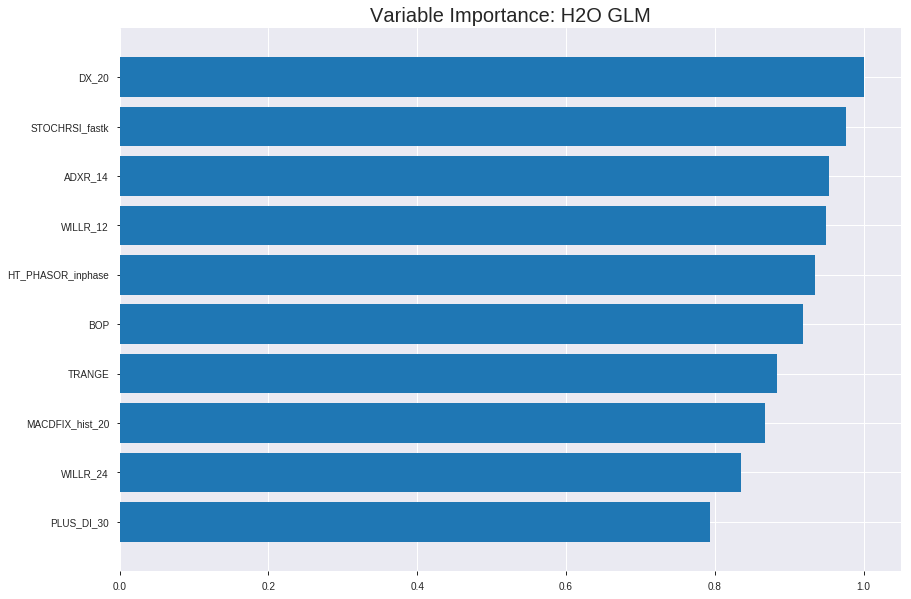

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_032828_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24784643382254323
RMSE: 0.4978417758912396
LogLoss: 0.6888285737559182
Null degrees of freedom: 1557
Residual degrees of freedom: 1498
Null deviance: 2157.0498856314666
Residual deviance: 2146.389835823441
AIC: 2266.389835823441
AUC: 0.569918877692521
pr_auc: 0.5816885537006161
Gini: 0.13983775538504206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.480725933601064: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    745   0.9987   (745.0/746.0)
1      0    812   0        (0.0/812.0)
Total  1    1557  0.4782   (745.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480726     0.685521  398
max f2                       0.480726     0.844953  398
max f0point5                 0.50446      0.596091  323
max accuracy                 0.505714     0.564185  316
max precision                0.585462     1         0
max recall                   0.480726     1         398
max specificity              0.585462     1         0
max absolute_mcc             0.50446      0.137865  323
max min_per_class_accuracy   0.519791     0.537534  218
max mean_per_class_accuracy  0.533286     0.551742  128

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.560446           1.07928   1.07928            0.5625           0.569578  0.5625                      0.569578            0.0110837       0.0110837                  7.92796    7.92796
    2        0.0205392                   0.556671           1.43904   1.25916            0.75             0.558413  0.65625                     0.563996            0.0147783       0.0258621                  43.9039    25.9159
    3        0.0301669                   0.554307           1.53498   1.34719            0.8              0.555418  0.702128                    0.561258            0.0147783       0.0406404                  53.4975    34.7186
    4        0.0404365                   0.552138           0.95936   1.24869            0.5              0.553205  0.650794                    0.559213            0.00985222      0.0504926                  -4.06404   24.869
    5        0.0500642                   0.550004           0.895402  1.18075            0.466667         0.551026  0.615385                    0.557638            0.00862069      0.0591133                  -10.4598   18.075
    6        0.100128                    0.543493           1.27915   1.22995            0.666667         0.54638   0.641026                    0.552009            0.0640394       0.123153                   27.9146    22.9948
    7        0.150193                    0.538562           1.27915   1.24635            0.666667         0.540697  0.649573                    0.548238            0.0640394       0.187192                   27.9146    24.6348
    8        0.200257                    0.534749           1.10695   1.2115             0.576923         0.536697  0.63141                     0.545353            0.0554187       0.242611                   10.6953    21.1499
    9        0.300385                    0.529513           0.94706   1.12335            0.49359          0.531735  0.58547                     0.540814            0.0948276       0.337438                   -5.29399   12.3353
    10       0.399872                    0.524148           0.95317   1.08101            0.496774         0.527034  0.563403                    0.537385            0.0948276       0.432266                   -4.68298   8.10119
    11       0.5                         0.519929           1.03316   1.07143            0.538462         0.521916  0.558408                    0.534288            0.103448        0.535714                   3.31565    7.14286
    12       0.600128                    0.515321           1.05776   1.06915            0.551282         0.517633  0.557219                    0.531509            0.105911        0.641626                   5.77555    6.91473
    13       0.699615                    0.511336           1.00269   1.0597             0.522581         0.513377  0.552294                    0.52893             0.0997537       0.741379                   0.268552   5.96963
    14       0.799743                    0.506883           0.996258  1.05175            0.519231         0.509187  0.548154                    0.526459            0.0997537       0.841133                   -0.374195  5.17538
    15       0.899872                    0.501342           0.860964  1.03052            0.448718         0.504436  0.53709                     0.524008            0.0862069       0.92734                    -13.9036   3.05247
    16       1                           0.472137           0.725669  1                  0.378205         0.495773  0.521181                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2490207931410918
RMSE: 0.4990198324125924
LogLoss: 0.6911960655848928
Null degrees of freedom: 445
Residual degrees of freedom: 386
Null deviance: 616.8842253342874
Residual deviance: 616.5468905017243
AIC: 736.5468905017243
AUC: 0.5315577078288942
pr_auc: 0.5273074174707849
Gini: 0.06311541565778844
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4825864759436649: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    209  0.9952   (209.0/210.0)
1      0    236  0        (0.0/236.0)
Total  1    445  0.4686   (209.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482586     0.693098  398
max f2                       0.482586     0.849532  398
max f0point5                 0.505903     0.598715  330
max accuracy                 0.506553     0.56278   326
max precision                0.527722     0.573529  126
max recall                   0.482586     1         398
max specificity              0.566941     0.995238  0
max absolute_mcc             0.505903     0.115815  330
max min_per_class_accuracy   0.519653     0.528571  202
max mean_per_class_accuracy  0.512402     0.549314  265

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 52.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.559365           0         0                  0                0.563372  0                           0.563372            0               0                          -100      -100
    2        0.0201794                   0.557296           1.88983   0.839925           1                0.558886  0.444444                    0.561378            0.0169492       0.0169492                  88.9831   -16.0075
    3        0.0313901                   0.555736           1.1339    0.944915           0.6              0.556655  0.5                         0.559691            0.0127119       0.029661                   13.3898   -5.50847
    4        0.0403587                   0.554351           0.472458  0.839925           0.25             0.555139  0.444444                    0.55868             0.00423729      0.0338983                  -52.7542  -16.0075
    5        0.0515695                   0.551275           0.755932  0.821665           0.4              0.553138  0.434783                    0.557475            0.00847458      0.0423729                  -24.4068  -17.8335
    6        0.100897                    0.543287           0.687211  0.755932           0.363636         0.547587  0.4                         0.552641            0.0338983       0.0762712                  -31.2789  -24.4068
    7        0.150224                    0.537417           1.11672   0.874399           0.590909         0.540539  0.462687                    0.548667            0.0550847       0.131356                   11.6718   -12.5601
    8        0.201794                    0.532214           1.15033   0.944915           0.608696         0.53467   0.5                         0.54509             0.059322        0.190678                   15.0332   -5.50847
    9        0.300448                    0.527778           1.33147   1.07184            0.704545         0.530034  0.567164                    0.540146            0.131356        0.322034                   33.1471   7.18442
    10       0.401345                    0.523695           0.923917  1.03466            0.488889         0.52561   0.547486                    0.536492            0.0932203       0.415254                   -7.60829  3.46558
    11       0.5                         0.519734           1.11672   1.05085            0.590909         0.521746  0.556054                    0.533582            0.110169        0.525424                   11.6718   5.08475
    12       0.600897                    0.51472            1.04991   1.05069            0.555556         0.517574  0.55597                     0.530894            0.105932        0.631356                   4.99058   5.06893
    13       0.699552                    0.510755           0.987866  1.04183            0.522727         0.512538  0.551282                    0.528306            0.0974576       0.728814                   -1.21341  4.18296
    14       0.800448                    0.507683           1.04991   1.04285            0.555556         0.509391  0.551821                    0.525921            0.105932        0.834746                   4.99058   4.28476
    15       0.899103                    0.501384           0.901965  1.02739            0.477273         0.504352  0.543641                    0.523555            0.0889831       0.923729                   -9.80354  2.73892
    16       1                           0.480063           0.755932  1                  0.4              0.494991  0.529148                    0.520673     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:28:28  0.000 sec   2            2.6       60            1.38107           1.38247
    2019-09-03 03:28:28  0.016 sec   4            1.6       60            1.3796            1.3824
    2019-09-03 03:28:28  0.034 sec   6            1         60            1.37766           1.38239
    2019-09-03 03:28:28  0.059 sec   8            0.62      60            1.37522           1.38251
    2019-09-03 03:28:28  0.086 sec   10           0.39      60            1.37235           1.38284
    2019-09-03 03:28:28  0.112 sec   12           0.24      60            1.36916           1.3834
    2019-09-03 03:28:28  0.138 sec   14           0.15      60            1.36581           1.38427
    2019-09-03 03:28:28  0.155 sec   16           0.092     60            1.36246           1.38538

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.6501547987616099)

('auc', 0.541000807102502)

('logloss', 0.6944826887242755)

('mean_per_class_error', 0.4502824858757062)

('rmse', 0.500669124681054)

('mse', 0.2506695724088927)

glm prediction progress: |████████████████████████████████████████████████| 100%


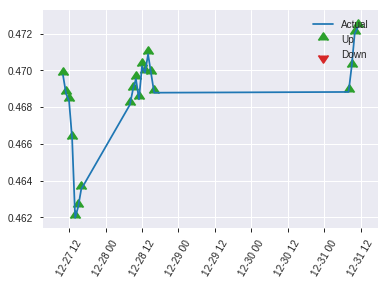


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2506695724088927
RMSE: 0.500669124681054
LogLoss: 0.6944826887242755
Null degrees of freedom: 222
Residual degrees of freedom: 163
Null deviance: 310.6462559060497
Residual deviance: 309.7392791710269
AIC: 429.7392791710269
AUC: 0.541000807102502
pr_auc: 0.5329271169528613
Gini: 0.08200161420500396
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49714774634191905: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    113  0.9576   (113.0/118.0)
1      0    105  0        (0.0/105.0)
Total  5    218  0.5067   (113.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497148     0.650155  217
max f2                       0.497148     0.822884  217
max f0point5                 0.502014     0.545256  202
max accuracy                 0.546604     0.573991  17
max precision                0.573553     1         0
max recall                   0.497148     1         217
max specificity              0.573553     1         0
max absolute_mcc             0.546604     0.182206  17
max min_per_class_accuracy   0.522927     0.533898  111
max mean_per_class_accuracy  0.546604     0.549718  17

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 52.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.556318           2.12381   2.12381            1                0.56278   1                           0.56278             0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.554537           2.12381   2.12381            1                0.555306  1                           0.559791            0.0190476       0.047619                   112.381   112.381
    3        0.0313901                   0.551244           1.0619    1.82041            0.5              0.55265   0.857143                    0.557751            0.00952381      0.0571429                  6.19048   82.0408
    4        0.0403587                   0.550497           1.0619    1.65185            0.5              0.550967  0.777778                    0.556243            0.00952381      0.0666667                  6.19048   65.1852
    5        0.0538117                   0.550289           1.41587   1.59286            0.666667         0.550373  0.75                        0.554776            0.0190476       0.0857143                  41.5873   59.2857
    6        0.103139                    0.544652           0.965368  1.29275            0.454545         0.547251  0.608696                    0.551177            0.047619        0.133333                   -3.4632   29.2754
    7        0.152466                    0.541981           0.772294  1.12437            0.363636         0.54325   0.529412                    0.548612            0.0380952       0.171429                   -22.7706  12.437
    8        0.201794                    0.538933           0.772294  1.03831            0.363636         0.540451  0.488889                    0.546617            0.0380952       0.209524                   -22.7706  3.83069
    9        0.300448                    0.533853           1.15844   1.07775            0.545455         0.535937  0.507463                    0.54311             0.114286        0.32381                    15.8442   7.77541
    10       0.399103                    0.528201           1.0619    1.07384            0.5              0.530572  0.505618                    0.540011            0.104762        0.428571                   6.19048   7.38363
    11       0.502242                    0.522927           1.10807   1.08087            0.521739         0.525656  0.508929                    0.537063            0.114286        0.542857                   10.8075   8.08673
    12       0.600897                    0.517551           0.675758  1.01436            0.318182         0.519811  0.477612                    0.534231            0.0666667       0.609524                   -32.4242  1.43568
    13       0.699552                    0.512107           1.15844   1.03468            0.545455         0.514135  0.487179                    0.531397            0.114286        0.72381                    15.8442   3.46764
    14       0.798206                    0.508642           1.15844   1.04997            0.545455         0.510229  0.494382                    0.52878             0.114286        0.838095                   15.8442   4.99732
    15       0.896861                    0.502647           0.868831  1.03005            0.409091         0.505485  0.485                       0.526218            0.0857143       0.92381                    -13.1169  3.00476
    16       1                           0.486468           0.738716  1                  0.347826         0.498457  0.470852                    0.523355          

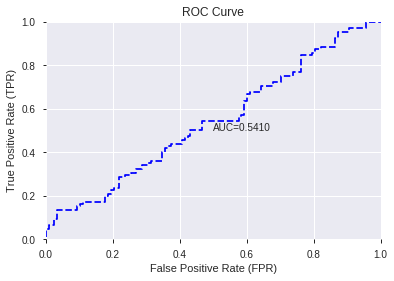

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


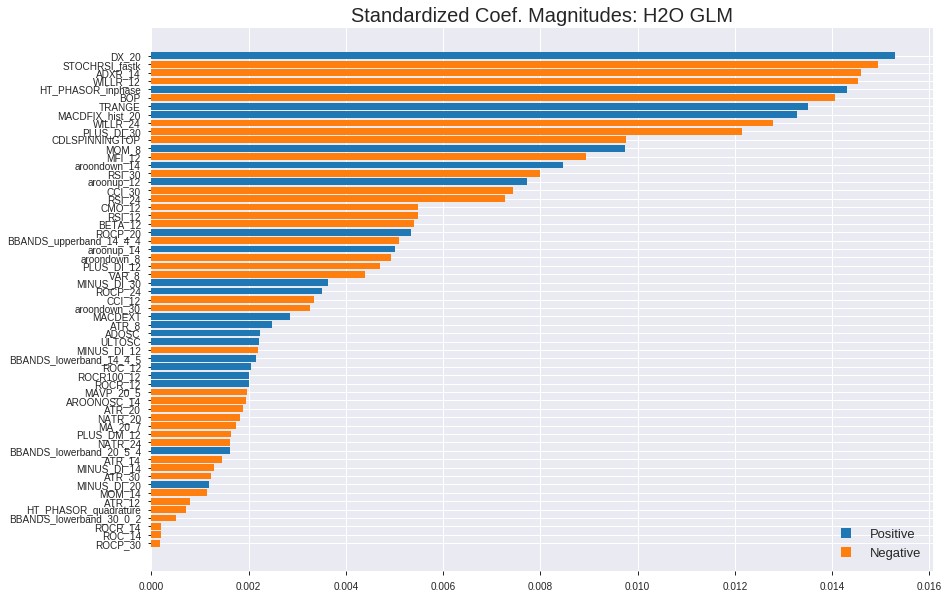

'log_likelihood'
--2019-09-03 03:28:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_032828_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_032828_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['DX_20',
 'STOCHRSI_fastk',
 'ADXR_14',
 'WILLR_12',
 'HT_PHASOR_inphase',
 'BOP',
 'TRANGE',
 'MACDFIX_hist_20',
 'WILLR_24',
 'PLUS_DI_30',
 'CDLSPINNINGTOP',
 'MOM_8',
 'MFI_12',
 'aroondown_14',
 'RSI_30',
 'aroonup_12',
 'CCI_30',
 'RSI_24',
 'CMO_12',
 'RSI_12',
 'BETA_12',
 'ROCP_20',
 'BBANDS_upperband_14_4_4',
 'aroonup_14',
 'aroondown_8',
 'PLUS_DI_12',
 'VAR_8',
 'MINUS_DI_30',
 'ROCP_24',
 'CCI_12',
 'aroondown_30',
 'MACDEXT',
 'ATR_8',
 'ADOSC',
 'ULTOSC',
 'MINUS_DI_12',
 'BBANDS_lowerband_14_4_5',
 'ROC_12',
 'ROCR100_12',
 'ROCR_12',
 'MAVP_20_5',
 'AROONOSC_14',
 'ATR_20',
 'NATR_20',
 'MA_20_7',
 'PLUS_DM_12',
 'NATR_24',
 'BBANDS_lowerband_20_5_4',
 'ATR_14',
 'MINUS_DI_14',
 'ATR_30',
 'MINUS_DI_20',
 'MOM_14',
 'ATR_12',
 'HT_PHASOR_quadrature',
 'BBANDS_lowerband_30_0_2',
 'ROCR_14',
 'ROC_14',
 'ROCP_30']

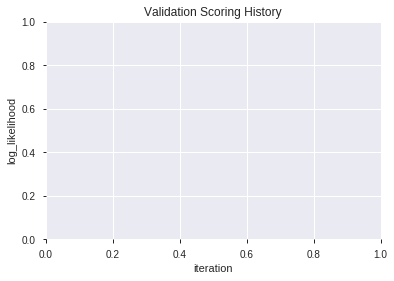

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190903_032844  0.559322  0.693160              0.500000  0.499909  0.249909
1  XGBoost_grid_1_AutoML_20190903_032844_model_3  0.556497  0.696223              0.445964  0.501302  0.251304
2               XGBoost_2_AutoML_20190903_032844  0.555448  0.693395              0.483575  0.499815  0.249815
3  XGBoost_grid_1_AutoML_20190903_032844_model_6  0.553188  0.689099              0.470864  0.498029  0.248033
4  XGBoost_grid_1_AutoML_20190903_032844_model_7  0.541646  0.706969              0.465537  0.506285  0.256325
5  XGBoost_grid_1_AutoML_20190903_032844_model_4  0.540355  0.693907              0.487288  0.500361  0.250361
6  XGBoost_grid_1_AutoML_20190903_032844_model_2  0.538499  0.698622              0.491525  0.502600  0.252606
7               XGBoost_1_AutoML_20190903_032844  0.530993  0.716029              0.495763  0.510387  0.260495
8  XGBoost_grid_1_AutoML_20190903_032844_model_1  0.508878  0.708809              0.491525  0.507540  0.257597
9  XGBoost_grid_1_AutoML_20190903_032844_model_5  0.505892  0.746045              0.460250  0.522972  0.273500

variable  relative_importance  scaled_importance  percentage
0                PLUS_DI_30           242.146118           1.000000    0.050079
1                    TRANGE           213.953369           0.883571    0.044248
2         HT_PHASOR_inphase           192.407333           0.794592    0.039792
3      HT_PHASOR_quadrature           181.725174           0.750477    0.037583
4                       BOP           171.569366           0.708537    0.035483
5                   BETA_12           170.124802           0.702571    0.035184
6                     ADOSC           154.231537           0.636936    0.031897
7                    RSI_30           118.834473           0.490755    0.024577
8   BBANDS_lowerband_14_4_5           118.353912           0.488771    0.024477
9   BBANDS_upperband_14_4_4           114.855087           0.474321    0.023754
10                  ADXR_14           110.663910           0.457013    0.022887
11                    MOM_8           109.579811           0.452536    0.022663
12             aroondown_30           107.349304           0.443324    0.022201
13                   MFI_12            99.402832           0.410508    0.020558
14                   CCI_30            89.536629           0.369763    0.018517
15  BBANDS_lowerband_20_5_4            88.799706           0.366720    0.018365
16          MACDFIX_hist_20            87.824440           0.362692    0.018163
17                   CMO_12            87.618248           0.361840    0.018121
18                 WILLR_12            86.677269           0.357954    0.017926
19                   MOM_14            85.601852           0.353513    0.017704
20           STOCHRSI_fastk            83.871666           0.346368    0.017346
21                    DX_20            83.866684           0.346347    0.017345
22                   ROC_12            83.021683           0.342858    0.017170
23                    ATR_8            81.350861           0.335958    0.016824
24              MINUS_DI_30            80.444511           0.332215    0.016637
25                  ROCP_30            79.299164           0.327485    0.016400
26                   CCI_12            79.284996           0.327426    0.016397
27                 WILLR_24            76.958939           0.317820    0.015916
28               PLUS_DI_12            76.733734           0.316890    0.015870
29                    VAR_8            74.382347           0.307180    0.015383
30              MINUS_DI_12            74.370514           0.307131    0.015381
31                  ROCP_24            73.838165           0.304932    0.015271
32                   ATR_30            73.548561           0.303736    0.015211
33              MINUS_DI_20            72.812431           0.300696    0.015059
34                  MACDEXT            69.468681           0.286887    0.014367
35                  ROCP_20            68.478546           0.282798    0.014162
36                   RSI_12            68.349060           0.282264    0.014135
37                   ULTOSC            67.982361           0.280749    0.014060
38               PLUS_DM_12            67.045029           0.276878    0.013866
39                   ROC_14            63.634342           0.262793    0.013160
40                  NATR_24            61.764359           0.255071    0.012774
41  BBANDS_lowerband_30_0_2            61.110352           0.252370    0.012638
42                   ATR_14            56.875252           0.234880    0.011763
43                  MA_20_7            53.029297           0.218997    0.010967
44              AROONOSC_14            52.087330           0.215107    0.010772
45              MINUS_DI_14            50.144905           0.207085    0.010371
46                  NATR_20            49.302921           0.203608    0.010196
47             aroondown_14            39.858154           0.164604    0.008243
48               aroonup_14            36.100121           0.149084    0.007466
49                 

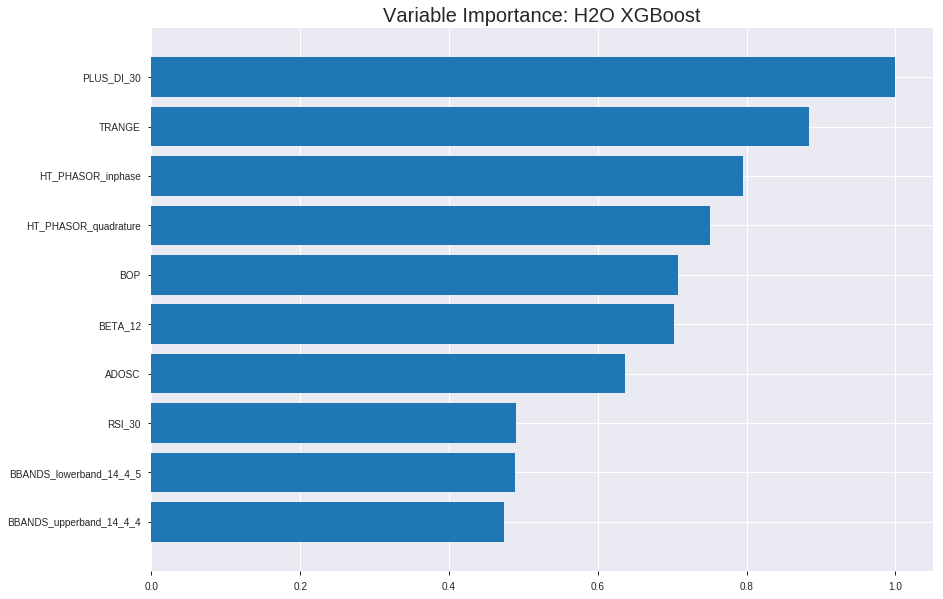

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190903_032844


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17859022365921054
RMSE: 0.4225993654268905
LogLoss: 0.5461296852962997
Mean Per-Class Error: 0.13716669528123715
AUC: 0.9373530751858846
pr_auc: 0.9392814034029952
Gini: 0.8747061503717692
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5266297459602356: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      647  99   0.1327   (99.0/746.0)
1      115  697  0.1416   (115.0/812.0)
Total  762  796  0.1374   (214.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52663      0.866915  186
max f2                       0.447064     0.9172    258
max f0point5                 0.555183     0.88141   160
max accuracy                 0.52663      0.862644  186
max precision                0.75289      1         0
max recall                   0.340202     1         352
max specificity              0.75289      1         0
max absolute_mcc             0.52663      0.725188  186
max min_per_class_accuracy   0.52663      0.858374  186
max mean_per_class_accuracy  0.52663      0.862833  186

Gains/Lift Table: Avg response rate: 52.12 %, avg score: 52.05 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.72655            1.91872    1.91872            1                0.738018  1                           0.738018            0.0197044       0.0197044                  91.8719   91.8719
    2        0.0205392                   0.714296           1.7988     1.85876            0.9375           0.71928   0.96875                     0.728649            0.0184729       0.0381773                  79.8799   85.8759
    3        0.0301669                   0.704039           1.91872    1.8779             1                0.708935  0.978723                    0.722357            0.0184729       0.0566502                  91.8719   87.7895
    4        0.0404365                   0.697943           1.91872    1.88826            1                0.701125  0.984127                    0.716965            0.0197044       0.0763547                  91.8719   88.8263
    5        0.0500642                   0.691666           1.91872    1.89412            1                0.694803  0.987179                    0.712703            0.0184729       0.0948276                  91.8719   89.412
    6        0.10077                     0.663134           1.89443    1.89428            0.987342         0.677073  0.987261                    0.694775            0.0960591       0.190887                   89.4432   89.4277
    7        0.150193                    0.643945           1.91872    1.90232            1                0.654079  0.991453                    0.681383            0.0948276       0.285714                   91.8719   90.232
    8        0.200257                    0.626545           1.84492    1.88797            0.961538         0.634753  0.983974                    0.669726            0.0923645       0.378079                   84.4922   88.7971
    9        0.300385                    0.595096           1.80802    1.86132            0.942308         0.612612  0.970085                    0.650688            0.181034        0.559113                   80.8024   86.1322
    10       0.399872                    0.561767           1.53498    1.78013            0.8              0.579104  0.927769                    0.632878            0.152709        0.711823                   53.4975   78.0128
    11       0.5                         0.529583           1.35294    1.69458            0.705128         0.545957  0.883184                    0.615471            0.135468        0.847291                   35.2943   69.4581
    12       0.600128                    0.488737           0.774867   1.54113            0.403846         0.508865  0.803209                    0.597685            0.0775862       0.924877                   -22.5133  54.1132
    13       0.699615                    0.454003           0.544669   1.39943            0.283871         0.471404  0.729358                    0.579727            0.0541872       0.979064                   -45.5331  39.9433
    14       0.799743                    0.414001           0.159893   1.24424            0.0833333        0.434242  0.648475                    0.561512            0.0160099       0.995074                   -84.0107  24.4242
    15       0.899872                    0.368033           0.0368984  1.1099             0.0192308        0.390713  0.578459                    0.542508            0.00369458      0.998768                   -96.3102  10.9901
    16       1                           0.195902           0.0122995  1                  0.00641026       0.322968  0.521181                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24851135408001354
RMSE: 0.49850913139080366
LogLoss: 0.6904129104980066
Mean Per-Class Error: 0.4195520581113801
AUC: 0.560502421307506
pr_auc: 0.5762072789496288
Gini: 0.1210048426150121
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32949841022491455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    206  0.981    (206.0/210.0)
1      0    236  0        (0.0/236.0)
Total  4    442  0.4619   (206.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329498     0.696165  395
max f2                       0.329498     0.851371  395
max f0point5                 0.512995     0.599442  187
max accuracy                 0.512995     0.578475  187
max precision                0.717324     0.75      3
max recall                   0.329498     1         395
max specificity              0.746703     0.995238  0
max absolute_mcc             0.512995     0.160896  187
max min_per_class_accuracy   0.50671      0.559322  199
max mean_per_class_accuracy  0.512995     0.580448  187

Gains/Lift Table: Avg response rate: 52.91 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.706431           1.1339    1.1339             0.6              0.723573  0.6                         0.723573            0.0127119       0.0127119                  13.3898   13.3898
    2        0.0201794                   0.685354           0.944915  1.04991            0.5              0.694903  0.555556                    0.710831            0.00847458      0.0211864                  -5.50847  4.99058
    3        0.0313901                   0.67704            1.51186   1.21489            0.8              0.680228  0.642857                    0.699901            0.0169492       0.0381356                  51.1864   21.4891
    4        0.0403587                   0.665955           1.88983   1.36488            1                0.672758  0.722222                    0.693869            0.0169492       0.0550847                  88.9831   36.4878
    5        0.0515695                   0.661542           0.755932  1.2325             0.4              0.662969  0.652174                    0.687152            0.00847458      0.0635593                  -24.4068  23.2498
    6        0.100897                    0.6294             1.11672   1.17589            0.590909         0.643014  0.622222                    0.665573            0.0550847       0.118644                   11.6718   17.5895
    7        0.150224                    0.610985           0.773112  1.04364            0.409091         0.621137  0.552239                    0.650982            0.0381356       0.15678                    -22.6888  4.36377
    8        0.201794                    0.586987           1.15033   1.0709             0.608696         0.597258  0.566667                    0.637253            0.059322        0.216102                   15.0332   7.0904
    9        0.300448                    0.555931           1.28852   1.14236            0.681818         0.570852  0.604478                    0.61545             0.127119        0.34322                    28.8521   14.236
    10       0.401345                    0.535715           1.25989   1.17191            0.666667         0.544946  0.620112                    0.597725            0.127119        0.470339                   25.9887   17.1906
    11       0.5                         0.50671            0.859014  1.11017            0.454545         0.518703  0.587444                    0.582134            0.0847458       0.555085                   -14.0986  11.0169
    12       0.600897                    0.485469           0.755932  1.05069            0.4              0.494966  0.55597                     0.567497            0.0762712       0.631356                   -24.4068  5.06893
    13       0.699552                    0.461881           0.944915  1.03577            0.5              0.472895  0.548077                    0.554156            0.0932203       0.724576                   -5.50847  3.57725
    14       0.800448                    0.431228           0.923917  1.02167            0.488889         0.448914  0.540616                    0.54089             0.0932203       0.817797                   -7.60829  2.16731
    15       0.899103                    0.393683           0.901965  1.00854            0.477273         0.411504  0.533666                    0.526693            0.0889831       0.90678                    -9.80354  0.853798
    16       1                           0.301449           0.923917  1                  0.488889         0.36091   0.529148                    0.509966          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:28:47  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.478819                         0.5                0.693147              0.5               0                    1                  0.470852
    2019-09-03 03:28:47  0.129 sec   5                  0.486867         0.66717             0.794654        0.801619           1.91872          0.280488                         0.499534           0.692216              0.516233          0.518684             0.629944           0.457399
    2019-09-03 03:28:47  0.185 sec   10                 0.477295         0.648547            0.83767         0.84103            1.91872          0.255456                         0.497074           0.687295              0.557405          0.563862             1.1339             0.452915
    2019-09-03 03:28:47  0.240 sec   15                 0.469465         0.633513            0.863371        0.865184           1.91872          0.223363                         0.498188           0.689522              0.545793          0.558864             0.755932           0.455157
    2019-09-03 03:28:47  0.302 sec   20                 0.459891         0.615309            0.884085        0.88762            1.91872          0.200257                         0.49812            0.689393              0.549122          0.560221             1.1339             0.461883
    2019-09-03 03:28:47  0.361 sec   25                 0.452065         0.600535            0.898196        0.900913           1.91872          0.184852                         0.497728           0.688624              0.553521          0.563599             0.755932           0.457399
    2019-09-03 03:28:47  0.419 sec   30                 0.445477         0.588221            0.906264        0.909382           1.91872          0.182285                         0.498222           0.689679              0.552573          0.56219              0.755932           0.457399
    2019-09-03 03:28:47  0.475 sec   35                 0.440722         0.57936             0.913928        0.917382           1.91872          0.169448                         0.499427           0.692183              0.548497          0.558859             1.1339             0.459641
    2019-09-03 03:28:47  0.539 sec   40                 0.434089         0.567119            0.922382        0.925833           1.91872          0.154685                         0.49907            0.691403              0.550545          0.566898             1.1339             0.459641
    2019-09-03 03:28:48  0.596 sec   45                 0.428459         0.556777            0.927403        0.930843           1.91872          0.153402                         0.498597           0.690482              0.557859          0.576154             1.1339             0.459641
    2019-09-03 03:28:48  0.652 sec   50                 0.422599         0.54613             0.937353        0.939281           1.91872          0.137356                         0.498509           0.690413              0.560502          0.576207             1.1339             0.461883

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
PLUS_DI_30            242.1461181640625      1.0                   0.05007900750309683
TRANGE                213.953369140625       0.8835713360296946    0.04424837556655236
HT_PHASOR_inphase     192.40733337402344     0.794591855664854     0.03979237150173986
HT_PHASOR_quadrature  181.7251739501953      0.7504773371054833    0.03758316019580962
BOP                   171.56936645507812     0.708536514051544     0.03548280540340535
---                   ---                    ---                   ---
aroondown_8           29.547962188720703     0.12202533913304743   0.006110907874011817
aroonup_12            22.25180435180664      0.09189411963536108   0.004601966306709725
ROCR_12               16.28087615966797      0.06723575121958843   0.0033670996898021205
ROCR_14               8.230337142944336      0.03398913517733121   0.0017021421555693417
ROCR100_12            3.5515589714050293     0.014667007666002407  0.0007345091869537132


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5829596412556054)

('F1', 0.6402439024390244)

('auc', 0.559322033898305)

('logloss', 0.693159820311101)

('mean_per_class_error', 0.4223970944309927)

('rmse', 0.4999091043640992)

('mse', 0.2499091126261158)

xgboost prediction progress: |████████████████████████████████████████████| 100%


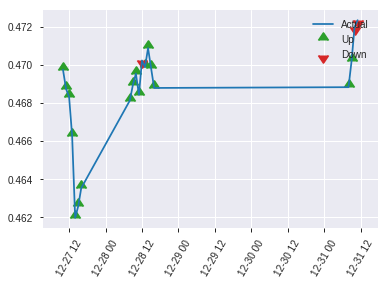


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2499091126261158
RMSE: 0.4999091043640992
LogLoss: 0.693159820311101
Mean Per-Class Error: 0.4223970944309927
AUC: 0.559322033898305
pr_auc: 0.5448039931098717
Gini: 0.11864406779661008
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30314841866493225: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    105  0        (0.0/105.0)
Total  0    223  0.5291   (118.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303148     0.640244  222
max f2                       0.303148     0.816485  222
max f0point5                 0.540321     0.548387  89
max accuracy                 0.540852     0.58296   87
max precision                0.716415     1         0
max recall                   0.303148     1         222
max specificity              0.716415     1         0
max absolute_mcc             0.673482     0.176276  5
max min_per_class_accuracy   0.512171     0.559322  110
max mean_per_class_accuracy  0.540321     0.577603  89

Gains/Lift Table: Avg response rate: 47.09 %, avg score: 51.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.690012           2.12381   2.12381            1                0.706261  1                           0.706261            0.0285714       0.0285714                  112.381   112.381
    2        0.0224215                   0.675383           2.12381   2.12381            1                0.680399  1                           0.695916            0.0190476       0.047619                   112.381   112.381
    3        0.0313901                   0.664424           1.0619    1.82041            0.5              0.66963   0.857143                    0.688406            0.00952381      0.0571429                  6.19048   82.0408
    4        0.0403587                   0.655531           1.0619    1.65185            0.5              0.661685  0.777778                    0.682468            0.00952381      0.0666667                  6.19048   65.1852
    5        0.0538117                   0.647919           0.707937  1.41587            0.333333         0.651753  0.666667                    0.674789            0.00952381      0.0761905                  -29.2063  41.5873
    6        0.103139                    0.63456            1.15844   1.29275            0.545455         0.641091  0.608696                    0.658673            0.0571429       0.133333                   15.8442   29.2754
    7        0.152466                    0.617528           0.579221  1.0619             0.272727         0.627312  0.5                         0.648527            0.0285714       0.161905                   -42.0779  6.19048
    8        0.201794                    0.590639           1.54459   1.17989            0.727273         0.602487  0.555556                    0.637273            0.0761905       0.238095                   54.4589   17.9894
    9        0.300448                    0.561776           1.25498   1.20455            0.590909         0.574483  0.567164                    0.616655            0.12381         0.361905                   25.4978   20.4549
    10       0.399103                    0.54038            1.15844   1.19315            0.545455         0.549963  0.561798                    0.60017             0.114286        0.47619                    15.8442   19.3151
    11       0.502242                    0.508295           0.831056  1.11879            0.391304         0.525278  0.526786                    0.58479             0.0857143       0.561905                   -16.8944  11.8793
    12       0.600897                    0.481075           0.675758  1.04606            0.318182         0.494427  0.492537                    0.569954            0.0666667       0.628571                   -32.4242  4.60554
    13       0.699552                    0.46365            1.0619    1.04829            0.5              0.47138   0.49359                     0.556053            0.104762        0.733333                   6.19048   4.82906
    14       0.798206                    0.432441           0.868831  1.02611            0.409091         0.448788  0.483146                    0.542795            0.0857143       0.819048                   -13.1169  2.61102
    15       0.896861                    0.396664           0.772294  0.99819            0.363636         0.414081  0.47                        0.528637            0.0761905       0.895238                   -22.7706  -0.180952
    16       1                           0.303148           1.01573   1                  0.478261         0.357766  0.470852                    0.511013       

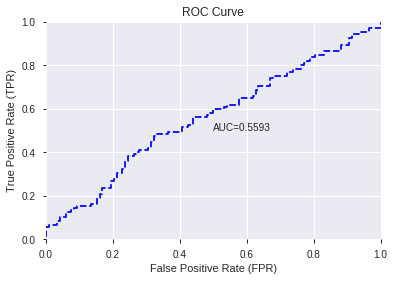

This function is available for GLM models only


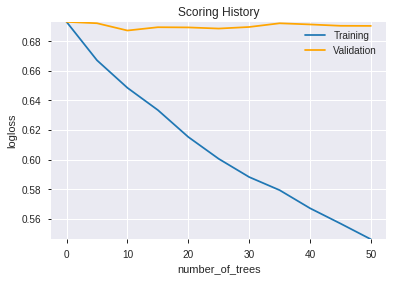

--2019-09-03 03:29:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.56
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.56|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190903_032844',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190903_032844',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_bcbc',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_bcbc',
   'ty

['PLUS_DI_30',
 'TRANGE',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'BOP',
 'BETA_12',
 'ADOSC',
 'RSI_30',
 'BBANDS_lowerband_14_4_5',
 'BBANDS_upperband_14_4_4',
 'ADXR_14',
 'MOM_8',
 'aroondown_30',
 'MFI_12',
 'CCI_30',
 'BBANDS_lowerband_20_5_4',
 'MACDFIX_hist_20',
 'CMO_12',
 'WILLR_12',
 'MOM_14',
 'STOCHRSI_fastk',
 'DX_20',
 'ROC_12',
 'ATR_8',
 'MINUS_DI_30',
 'ROCP_30',
 'CCI_12',
 'WILLR_24',
 'PLUS_DI_12',
 'VAR_8',
 'MINUS_DI_12',
 'ROCP_24',
 'ATR_30',
 'MINUS_DI_20',
 'MACDEXT',
 'ROCP_20',
 'RSI_12',
 'ULTOSC',
 'PLUS_DM_12',
 'ROC_14',
 'NATR_24',
 'BBANDS_lowerband_30_0_2',
 'ATR_14',
 'MA_20_7',
 'AROONOSC_14',
 'MINUS_DI_14',
 'NATR_20',
 'aroondown_14',
 'aroonup_14',
 'ATR_12',
 'RSI_24',
 'MAVP_20_5',
 'ATR_20',
 'CDLSPINNINGTOP',
 'aroondown_8',
 'aroonup_12',
 'ROCR_12',
 'ROCR_14',
 'ROCR100_12']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.619
GLM             0.592
XGBoost         0.614
dtype: float64

DeepLearning    GLM  XGBoost
All          0.578  0.592    0.574
DLF          0.619  0.565    0.614
Fwe          0.587  0.592    0.574
RFE          0.614  0.574    0.583
XGBF         0.592  0.565    0.614





F1


DeepLearning    0.649
GLM             0.650
XGBoost         0.656
dtype: float64

DeepLearning    GLM  XGBoost
All          0.648  0.646    0.656
DLF          0.640  0.642    0.642
Fwe          0.642  0.646    0.656
RFE          0.649  0.650    0.640
XGBF         0.644  0.642    0.642





auc


DeepLearning    0.599
GLM             0.571
XGBoost         0.603
dtype: float64

DeepLearning    GLM  XGBoost
All          0.564  0.571    0.575
DLF          0.576  0.551    0.603
Fwe          0.578  0.571    0.575
RFE          0.599  0.541    0.559
XGBF         0.574  0.551    0.603





logloss


DeepLearning    1.314
GLM             0.696
XGBoost         0.693
dtype: float64

DeepLearning    GLM  XGBoost
All          0.693  0.694    0.689
DLF          0.814  0.696    0.683
Fwe          1.314  0.694    0.689
RFE          0.686  0.694    0.693
XGBF         0.960  0.696    0.683





mean_per_class_error


DeepLearning    0.424
GLM             0.450
XGBoost         0.435
dtype: float64

DeepLearning    GLM  XGBoost
All          0.424  0.408    0.435
DLF          0.395  0.435    0.394
Fwe          0.421  0.408    0.435
RFE          0.387  0.450    0.422
XGBF         0.413  0.435    0.394





rmse


DeepLearning    0.593
GLM             0.501
XGBoost         0.500
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.501    0.498
DLF          0.533  0.501    0.495
Fwe          0.593  0.501    0.498
RFE          0.496  0.501    0.500
XGBF         0.563  0.501    0.495





mse


DeepLearning    0.352
GLM             0.251
XGBoost         0.250
dtype: float64

DeepLearning    GLM  XGBoost
All          0.250  0.251    0.248
DLF          0.284  0.251    0.245
Fwe          0.352  0.251    0.248
RFE          0.246  0.251    0.250
XGBF         0.316  0.251    0.245

{'F1':       DeepLearning    GLM  XGBoost
 All          0.648    NaN      NaN
 DLF          0.640    NaN      NaN
 DLF            NaN  0.642      NaN
 DLF            NaN    NaN    0.642
 All            NaN  0.646      NaN
 All            NaN    NaN    0.656
 XGBF         0.644    NaN      NaN
 XGBF           NaN  0.642      NaN
 XGBF           NaN    NaN    0.642
 Fwe          0.642    NaN      NaN
 Fwe            NaN  0.646      NaN
 Fwe            NaN    NaN    0.656
 RFE          0.649    NaN      NaN
 RFE            NaN  0.650      NaN
 RFE            NaN    NaN    0.640,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.578    NaN      NaN
 DLF          0.619    NaN      NaN
 DLF            NaN  0.565      NaN
 DLF            NaN    NaN    0.614
 All            NaN  0.592      NaN
 All            NaN    NaN    0.574
 XGBF         0.592    NaN      NaN
 XGBF           NaN  0.565      NaN
 XGBF           NaN    NaN    0.614
 Fwe          0.587    NaN      NaN
 Fwe     